In [3]:
%reload_ext autoreload
%autoreload 2

import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

PARENT_DIR = r'D:\projects\diverters\src'
CURR_DIR = os.path.join(PARENT_DIR, 'conductivity_effect')
sys.path.append(PARENT_DIR)

import linearization.surface as surface
import conductivity_effect.solve
from materials.presets import SampleMaterial
from parametric_solver.solver import NodeContext

In [5]:
solver = conductivity_effect.solve.solve()

Solving [1/20]		Time Remaining: Unknown
Sample: kdoped_rhenium_kdoped_rhenium_elastic_low
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\kdoped_rhenium_kdoped_rhenium_elastic_low.pkl ...
Solving [2/20]		Time Remaining:  0h:00m:19s
Sample: kdoped_rhenium_kdoped_rhenium_elastic_nominal
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\kdoped_rhenium_kdoped_rhenium_elastic_nominal.pkl ...
Solving [3/20]		Time Remaining:  0h:00m:18s
Sample: kdoped_rhenium_kdoped_rhenium_elastic_high2
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\kdoped_rhenium_kdoped_rhenium_elastic_high2.pkl ...
Solving [4/20]		Time Remaining:  0h:00m:17s
Sample: kdoped_rhenium_kdoped_rhenium_elastic_high
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\kdoped_rhenium_kdoped_rhenium_elastic_high.pkl ...
Solving [5/20]		Time Remaining:  0h:00m:16s
Sample: wl10_roedig_wl10_roedig_elastic_low
Loading cached res

In [6]:
HEAT_LOADS = ['low', 'nominal', 'high2', 'high']

sims = [
    (SampleMaterial.W_3RHENIUM, SampleMaterial.W_3RHENIUM, False),
    (SampleMaterial.WL10, SampleMaterial.WL10, False),
    (SampleMaterial.WL10, SampleMaterial.PURE_W, False),
    (SampleMaterial.W_3RHENIUM, SampleMaterial.W_3RHENIUM, True),
    (SampleMaterial.WL10, SampleMaterial.PURE_W, True)
]

def get_result(_conductivity, _structural, _plastic, _case):
    print("Result: ", _conductivity, _structural, _plastic, _case)
    return solver.result_from_name(conductivity_effect.solve.sample_name(_conductivity, _structural, _plastic, _case))


def max_eqv_stresses(_conductivity, _structural, _plastic, _nodes=None):
    max_stresses = []
    for _case in HEAT_LOADS:
        _result = get_result(_conductivity, _structural, _plastic, _case)
        
        if not _nodes:
            _nodes = _result.valid_nodes()

        max_stresses.append(max([_result.eqv_stress(node) for node in _nodes]))

    return max_stresses

def plot_bar_graph(_data, title, stress=True):
    labels = ['3% Re, 3% Re (E)', 'WL10, WL10 (E)', 'WL10, W (E)', '3% Re, 3% Re (P)', 'WL10, W (P)']
    bar_width = 0.20
    indexes = np.arange(len(_data))

    colors = ['blue', 'yellow', 'red', 'grey']
    for i in range(4):
        plt.bar(indexes + i * bar_width, [item[i] for item in _data], bar_width, color=colors[i])
    
    plt.xticks(indexes + bar_width, labels)
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.25)
    plt.title(title)

    colors = {'low':'blue', 'nominal':'yellow', 'high':'red', 'high (legacy)':'grey'}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)

    if stress:
        plt.ylabel("Max Stress (MPa)")
    else:
        plt.ylabel("Max Strain (m/m)")
    
    plt.show()

def plot_eqv_stresses(title, _nodes=None):
    eqv_stress_data = []
    for sim in sims:
        print(f"Conductivity: {sim[0].value}, Structural: {sim[1].value}, {'plastic' if sim[2] else 'elastic'}")
        stresses = max_eqv_stresses(*sim, _nodes=_nodes)
    
        sim_eqv_data = []
        for case, stress in zip(HEAT_LOADS, stresses):
            sim_eqv_data.append(stress)
            print(f"{case}: {stress} MPa")
    
        eqv_stress_data.append(sim_eqv_data)
        print()
    
    plot_bar_graph(eqv_stress_data, title)

In [7]:
nodeContext = NodeContext(r"D:\projects\diverters\src\conductivity_effect\in\kdoped_rhenium_high.inp")
nodeContext.add_component('cool_surf1')
nodeContext.add_component('cool_surf2')
nodeContext.run()

press_bound_nodes = nodeContext.nodes('cool_surf1') + nodeContext.nodes('cool_surf2')
print(f"Read {len(press_bound_nodes)} pressure boundary nodes.")

Connecting to APDL ...
Connected.
Caching cool_surf1 ...
Caching cool_surf2 ...
Read 885 pressure boundary nodes.


Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, elastic
Result:  SampleMaterial.W_3RHENIUM SampleMaterial.W_3RHENIUM False low
Result:  SampleMaterial.W_3RHENIUM SampleMaterial.W_3RHENIUM False nominal
Result:  SampleMaterial.W_3RHENIUM SampleMaterial.W_3RHENIUM False high2
Result:  SampleMaterial.W_3RHENIUM SampleMaterial.W_3RHENIUM False high
low: 134.4124463820941 MPa
nominal: 286.578681155569 MPa
high2: 509.00349517844194 MPa
high: 161.76573495071636 MPa

Conductivity: wl10_roedig, Structural: wl10_roedig, elastic
Result:  SampleMaterial.WL10 SampleMaterial.WL10 False low
Result:  SampleMaterial.WL10 SampleMaterial.WL10 False nominal
Result:  SampleMaterial.WL10 SampleMaterial.WL10 False high2
Result:  SampleMaterial.WL10 SampleMaterial.WL10 False high
low: 158.16153783065784 MPa
nominal: 533.6695933970225 MPa
high2: 836.6551563653973 MPa
high: 268.1782987245414 MPa

Conductivity: wl10_roedig, Structural: pure_w, elastic
Result:  SampleMaterial.WL10 SampleMaterial.PURE_W 

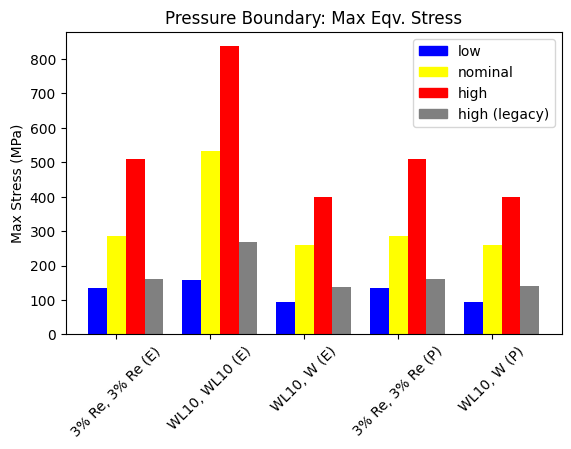

In [8]:
plot_eqv_stresses("Pressure Boundary: Max Eqv. Stress", _nodes=press_bound_nodes)

In [9]:
def read_node_data():
    _node_data = []
    with open("D:\\projects\\diverters\\src\\results\\hemj_v2\\line_nodes_side.txt") as f:
        for line in f:
            try:
                _data = line.split()
                _node_data.append([int(_data[0]), float(_data[1]), float(_data[2]), float(_data[3])])
            except ValueError:
                continue
    _node_data.sort(key=lambda x: x[3])
    return _node_data

def eval_linear_stress(_result, node_data, mode='linear'):
    nodes = [_data[0] for _data in node_data]
    positions = np.array([[_data[1], _data[2], _data[3]] for _data in node_data])
    
    if mode == 'linear':
        linear_stresses = _result.linearized_stress_tensor(nodes, positions)
    elif mode == 'membrane':
        linear_stresses = _result.membrane_stress_tensor(nodes, positions)
    elif mode == 'bending':
        linear_stresses = _result.bending_stress_tensor(nodes, positions)
    else:
        linear_stresses = None

    linear_von_mises = [tensor for tensor in linear_stresses]
    return max(linear_von_mises)

def max_lin_stresses(_conductivity, _structural, _plastic, node_data, _nodes=None, mode='linear'):
    max_stresses = []
    for _case in HEAT_LOADS:
        _result = get_result(_conductivity, _structural, _plastic, _case)
        max_stresses.append(eval_linear_stress(_result, node_data, mode=mode))

    return max_stresses

def plot_lin_stresses(title, _nodes=None, mode='linear'):
    eqv_stress_data = []
    for sim in sims:
        print(f"Conductivity: {sim[0].value}, Structural: {sim[1].value}, {'plastic' if sim[2] else 'elastic'}")
        stresses = max_lin_stresses(*sim, _nodes=_nodes, mode=mode)
    
        sim_eqv_data = []
        for case, stress in zip(HEAT_LOADS, stresses):
            sim_eqv_data.append(stress)
            print(f"{case}: {stress} MPa")
    
        eqv_stress_data.append(sim_eqv_data)
        print()
    
    plot_bar_graph(eqv_stress_data, title)

In [10]:
def sample_name(_conductivity, _structural, _plastic, _case):
    return f"{_conductivity.value}_{_structural.value}_{'plastic' if _plastic else 'elastic'}_{_case}"


def plot_property(stress_result, _property, _label, _title, _filename):
    if _property == 'total':
        property_result = stress_result['membrane'] + stress_result['bending']
    else:
        property_result = stress_result[_property]

    point_cloud = pv.PolyData(stress_result["location"])
    point_cloud[_label] = property_result

    plotter = pv.Plotter()
    plotter.add_mesh(point_cloud, cmap='turbo', point_size=12)
    plotter.view_vector((10, 10, 10), (0, 0, 0))
    plotter.camera.roll = 240
    plotter.add_title(_title)
    plotter.render()
    plotter.screenshot(os.path.join(PARENT_DIR, 'conductivity_effect', 'out', 'plots', _filename + '_' + _property + '.png'))
    plotter.show(jupyter_backend='static')


def plot_linearization(stress, legacy=False):
    NODES_DIR = os.path.join(PARENT_DIR, 'inp', 'nodes')
    TOP_SURFACE_PATH = os.path.join(NODES_DIR, 'ts.node.loc')
    BOTTOM_SURFACE_PATH = os.path.join(NODES_DIR, 'bs.node.loc')
    ALL_LOCS_PATH = os.path.join(NODES_DIR, 'all.node.loc')
    
    membrane_data = []
    bending_data = []
    linearized_data = []
    
    for conductivity, structural, plastic in sims:
        membrane_curr = []
        bending_curr = []
        linearized_curr = []
    
        for case in HEAT_LOADS:
            curr_name = sample_name(conductivity, structural, plastic, case)
            curr_result = solver.result_from_name(curr_name)
            
            if stress:
                dataframe = curr_result.stress_dataframe()
            else:
                dataframe = curr_result.strain_dataframe().iloc[:, :6]
            
            stress_result = surface.linearize_surface(
                TOP_SURFACE_PATH,
                BOTTOM_SURFACE_PATH,
                dataframe,
                ALL_LOCS_PATH,
                None,
                not stress and not legacy
            )
    
            print(f"Conductivity: {conductivity.value}")
            print(f"Structural: {structural.value}")
            print(f"Type: {'Plastic' if plastic else 'Elastic'}")
            print(f"Heat Loading: {case}")
    
            if stress:
                unit_label = "Stress (MPa)"
                mode = "Stress"
            else:
                unit_label = "Strain (m/m)"
                mode = "Strain"

            ss_name = curr_name + ("_stress" if stress else "_strain")
            plot_property(stress_result, "membrane", unit_label, f"Membrane {mode}", ss_name)
            plot_property(stress_result, "bending", unit_label, f"Bending {mode}", ss_name)
            plot_property(stress_result, "total", unit_label, f"Linearized {mode}", ss_name)
    
            total_result = stress_result['membrane'] + stress_result['bending']
    
            membrane_curr.append(max(stress_result['membrane']))
            bending_curr.append(max(stress_result['bending']))
            linearized_curr.append(max(total_result))
    
        print(f"Max Membrane: {membrane_curr}")
        print(f"Max Bending: {bending_curr}")
        print(f"Max Linearized: {linearized_curr}")
        print("____________________________________")
        membrane_data.append(membrane_curr)
        bending_data.append(bending_curr)
        linearized_data.append(linearized_curr)
        
    return membrane_data, bending_data, linearized_data

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: low


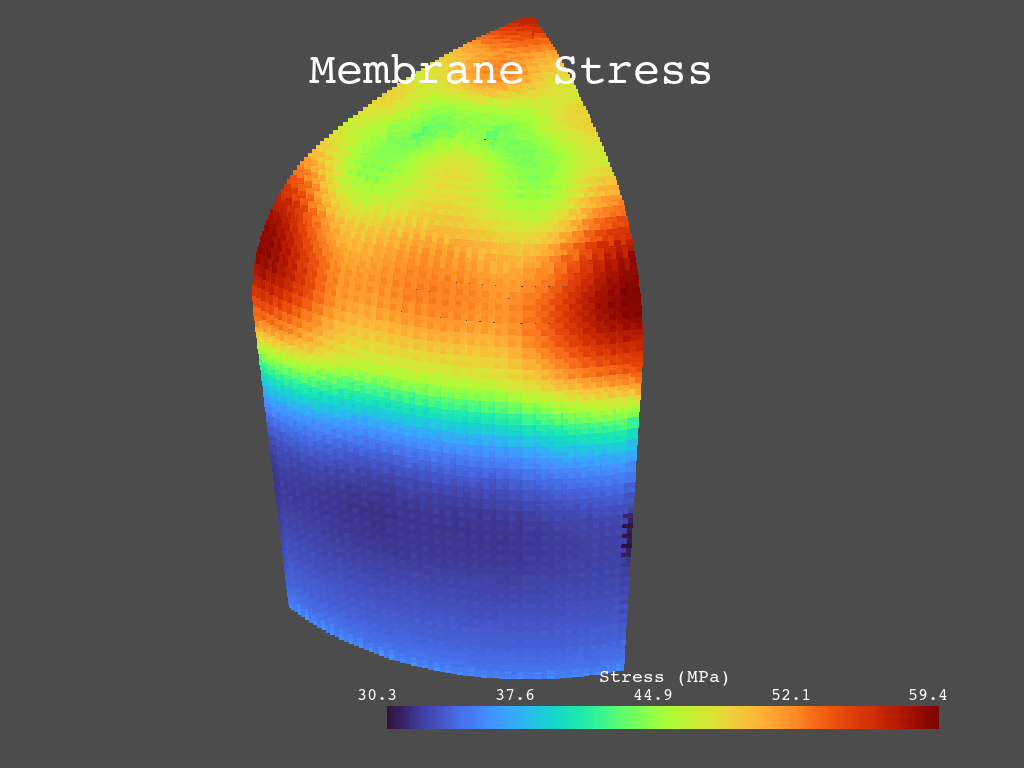

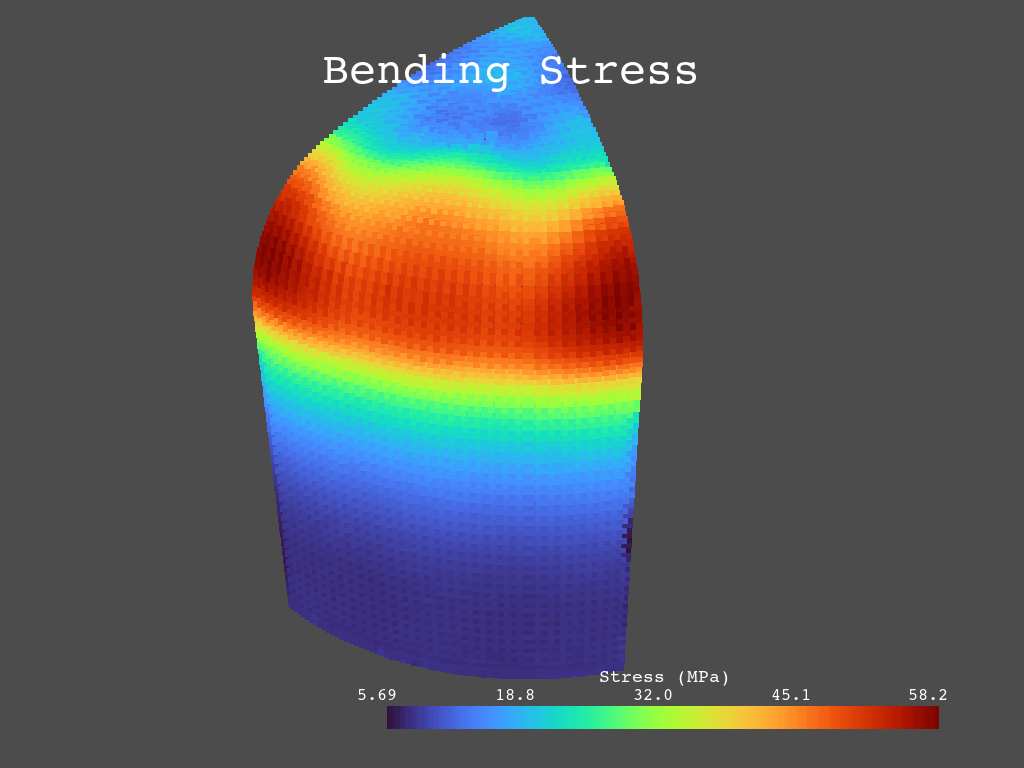

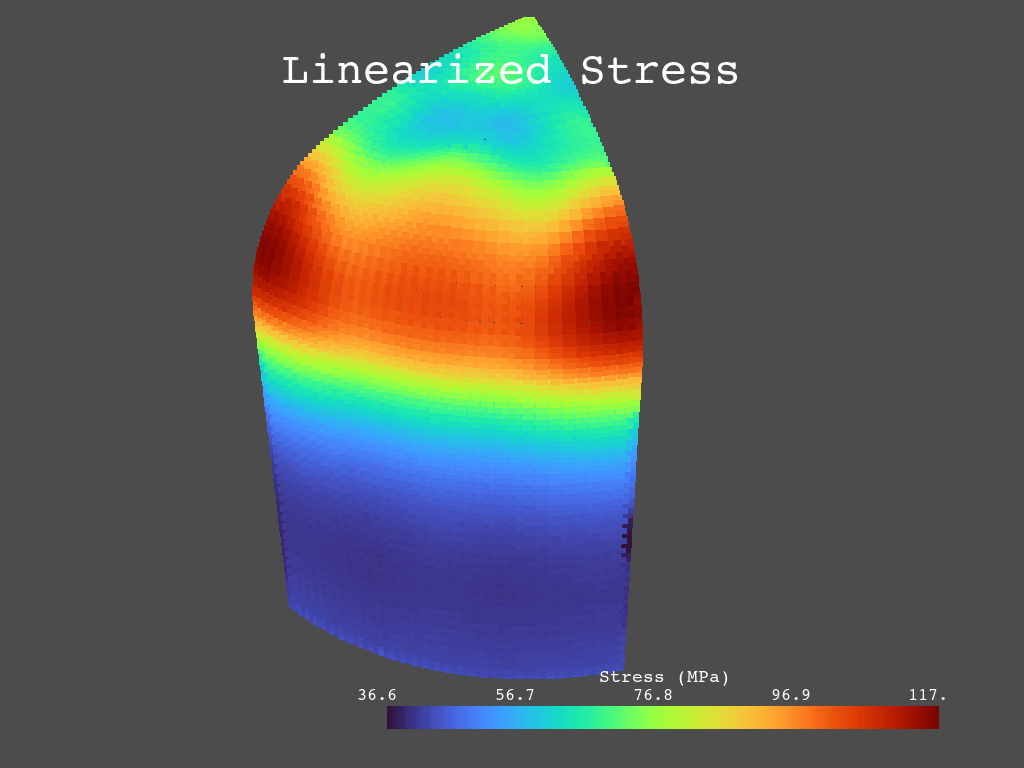

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: nominal


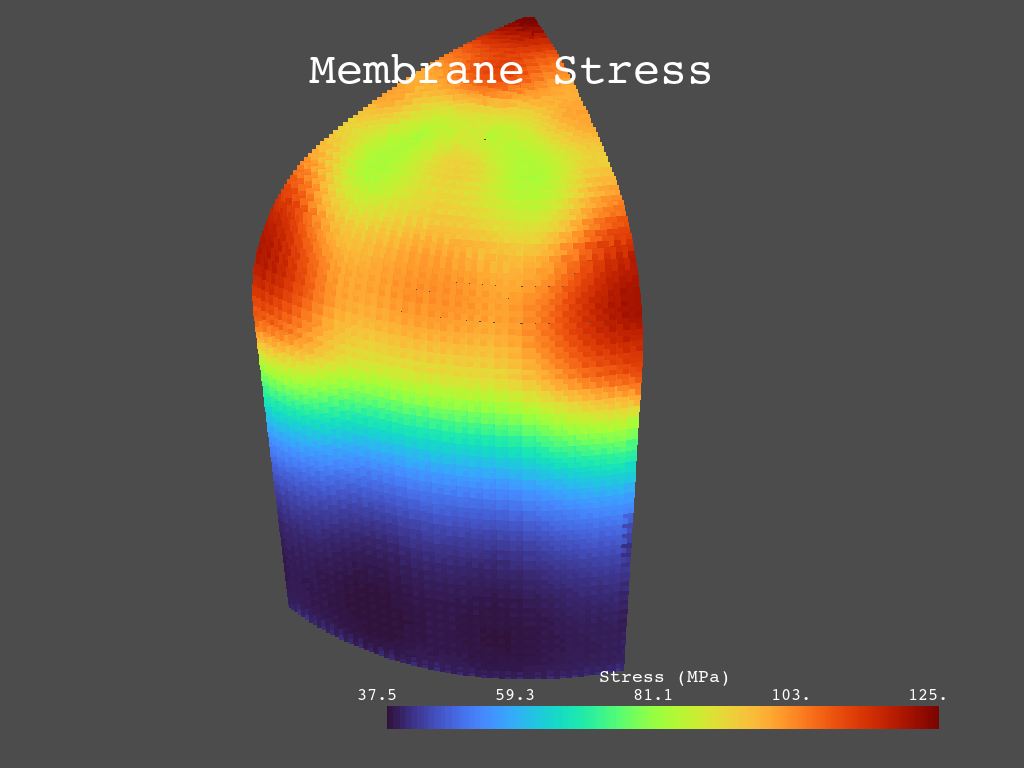

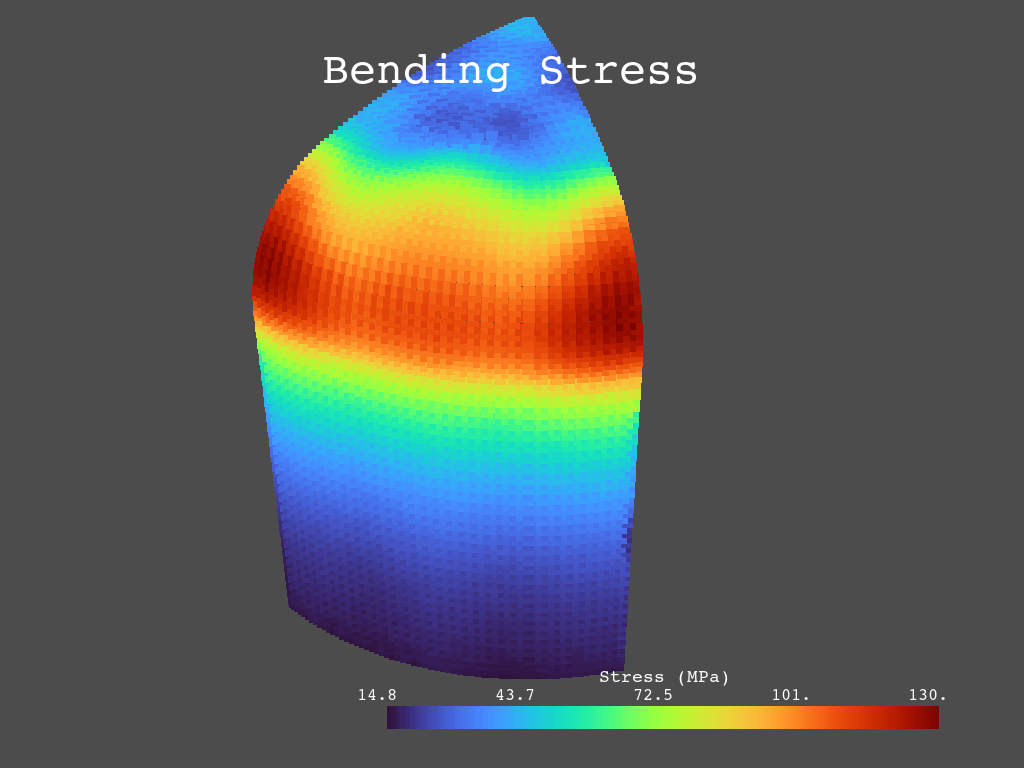

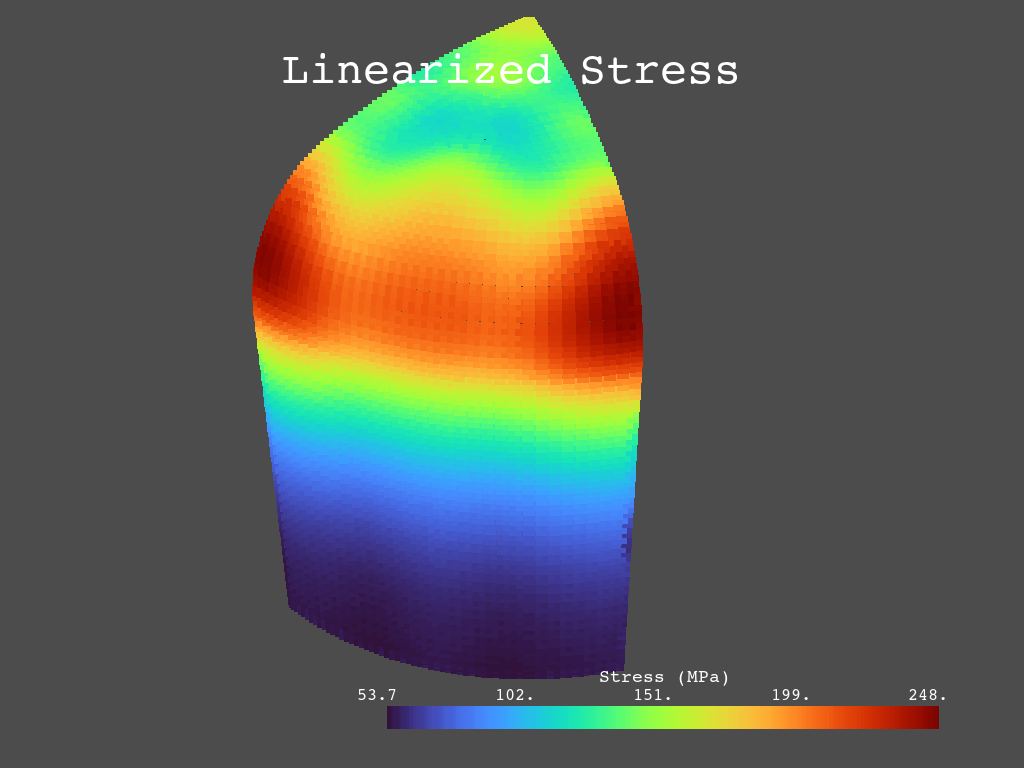

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: high2


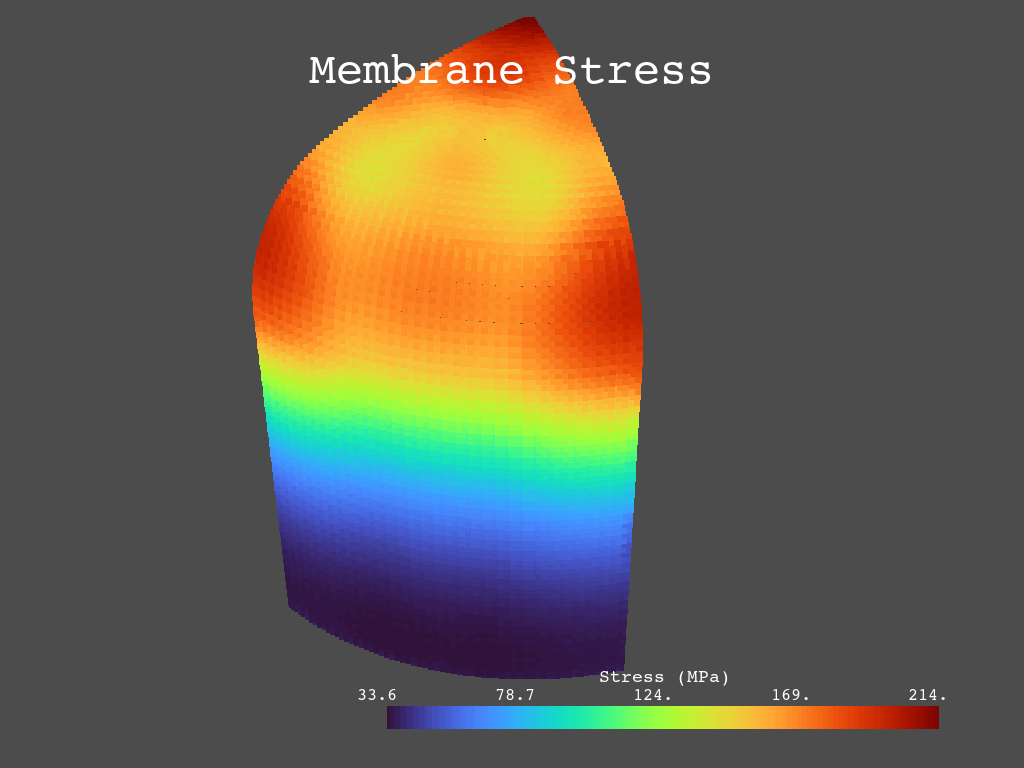

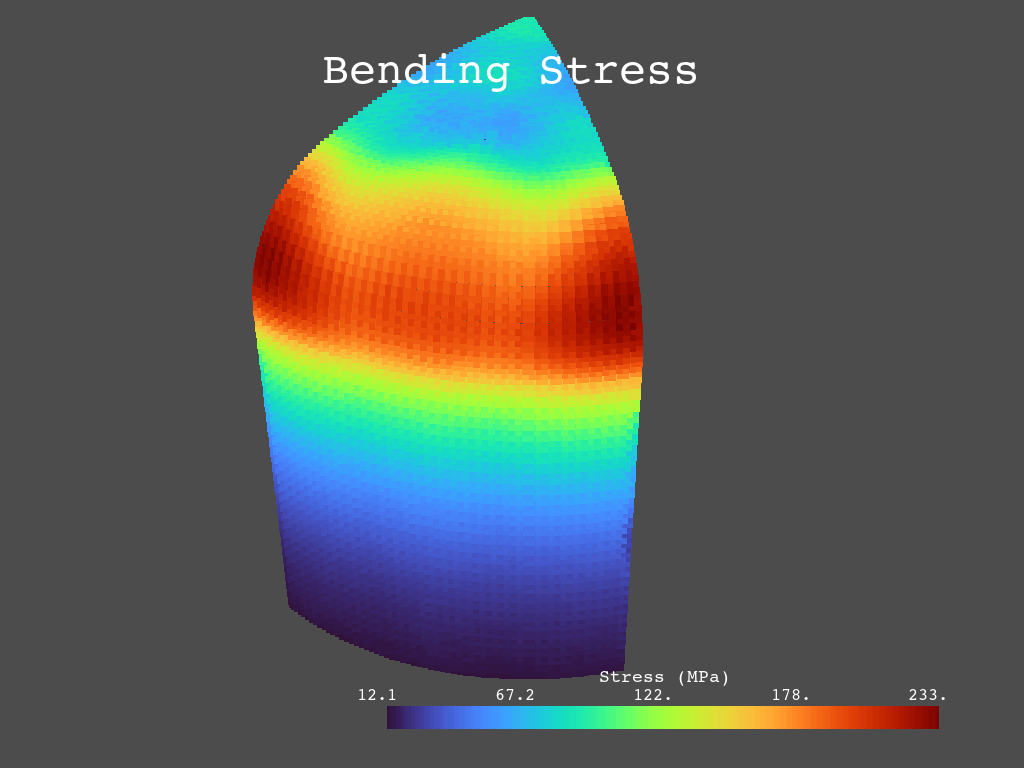

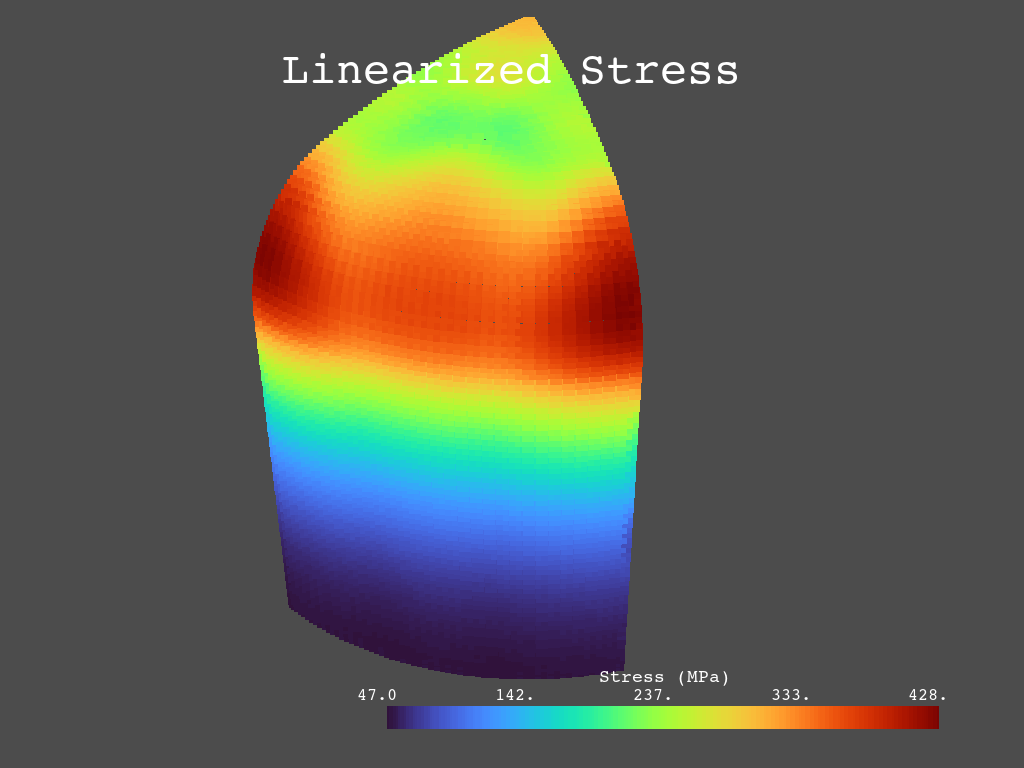

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: high


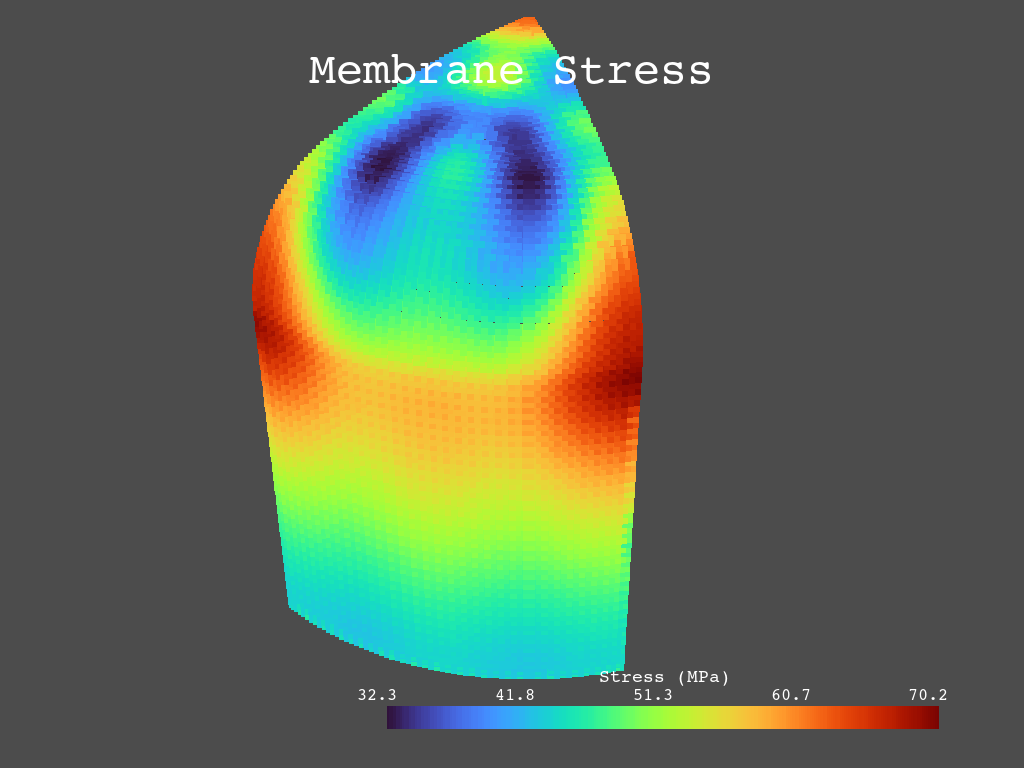

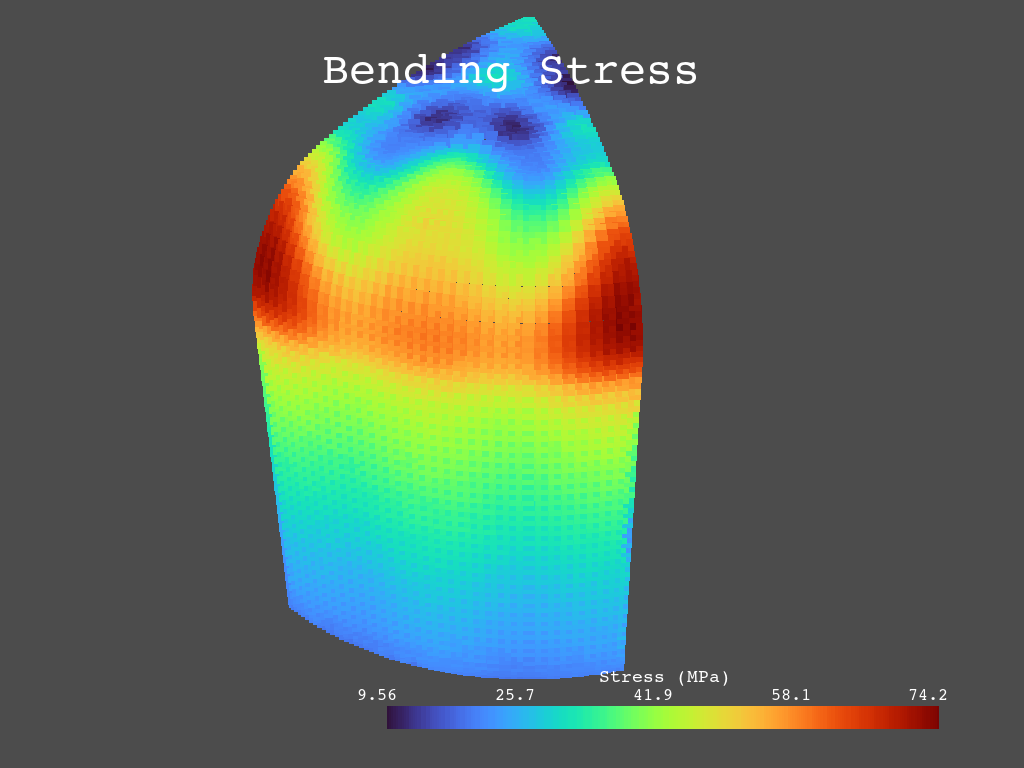

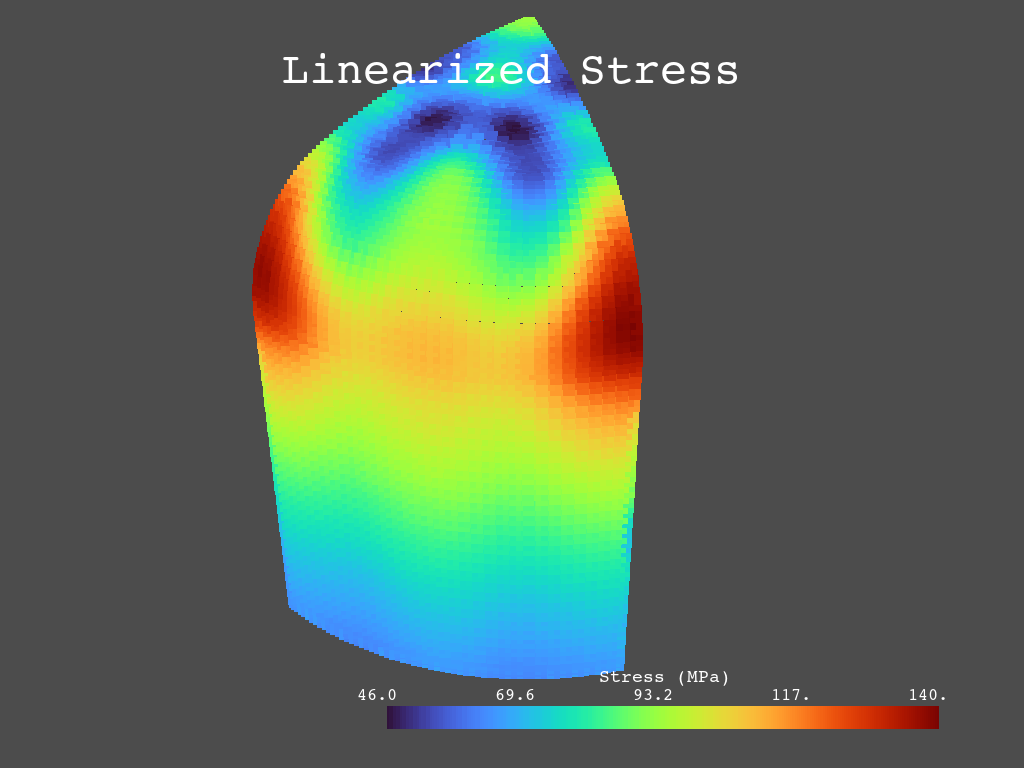

Max Membrane: [59.39136464962517, 124.69849158860629, 213.86437238949324, 70.20154849745798]
Max Bending: [58.23888770272447, 130.27400630022137, 232.64419934942575, 74.2251762340857]
Max Linearized: [116.95642892912899, 247.90025112773094, 427.6939738912836, 140.32947188092453]
____________________________________
Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: low


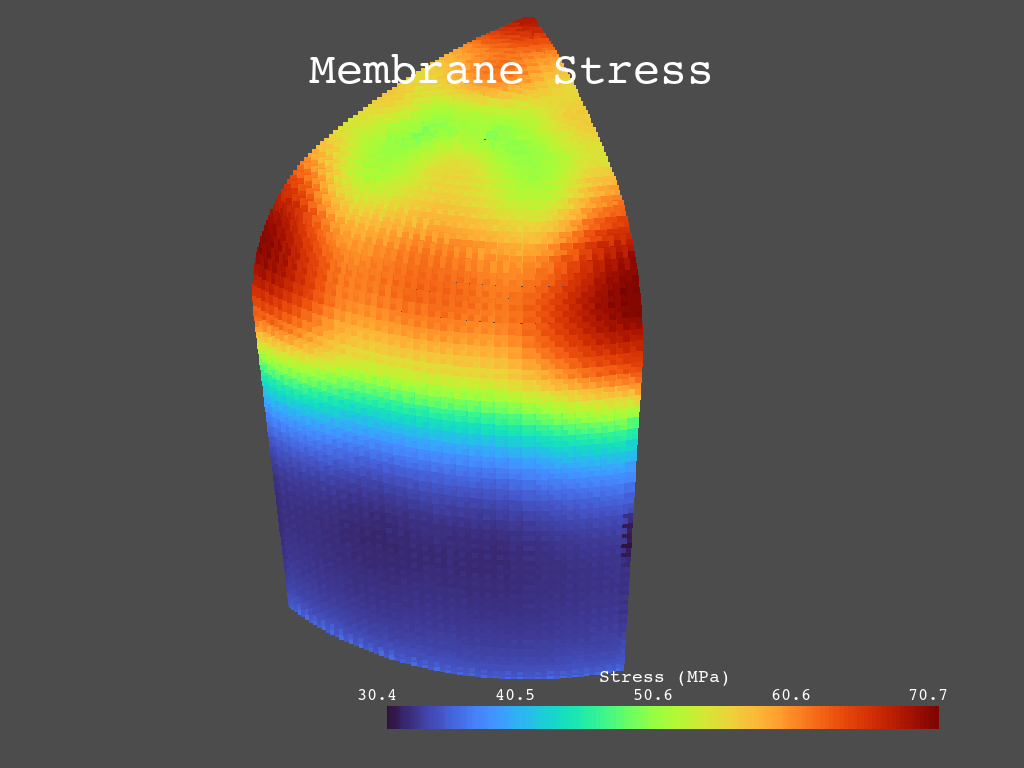

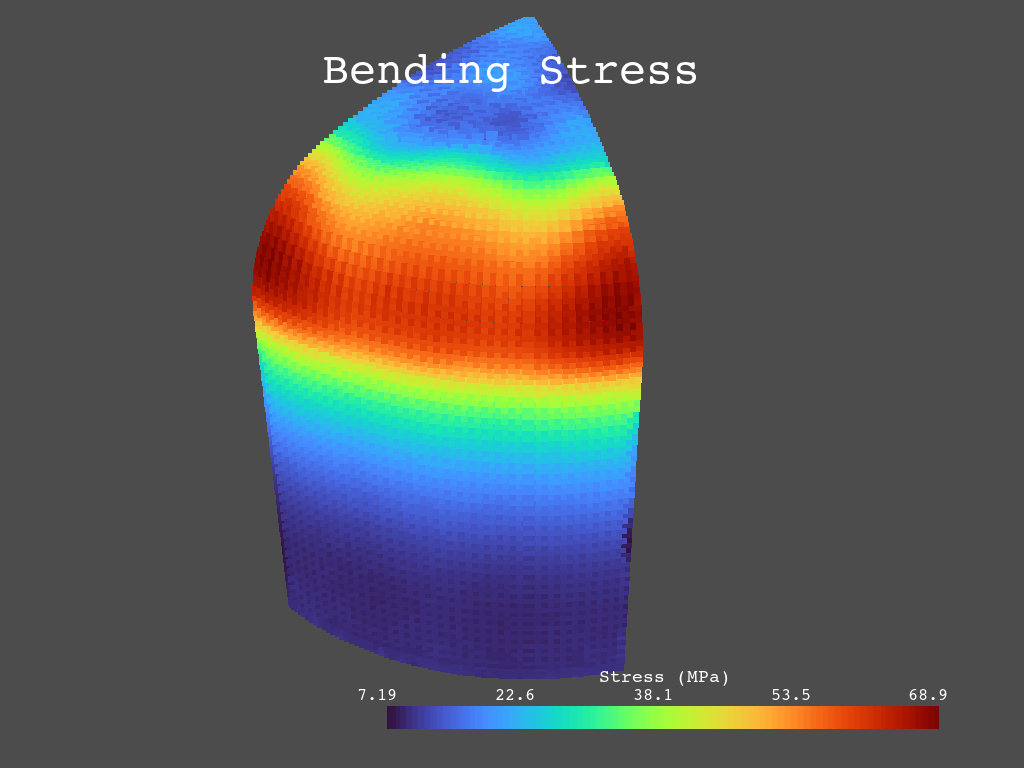

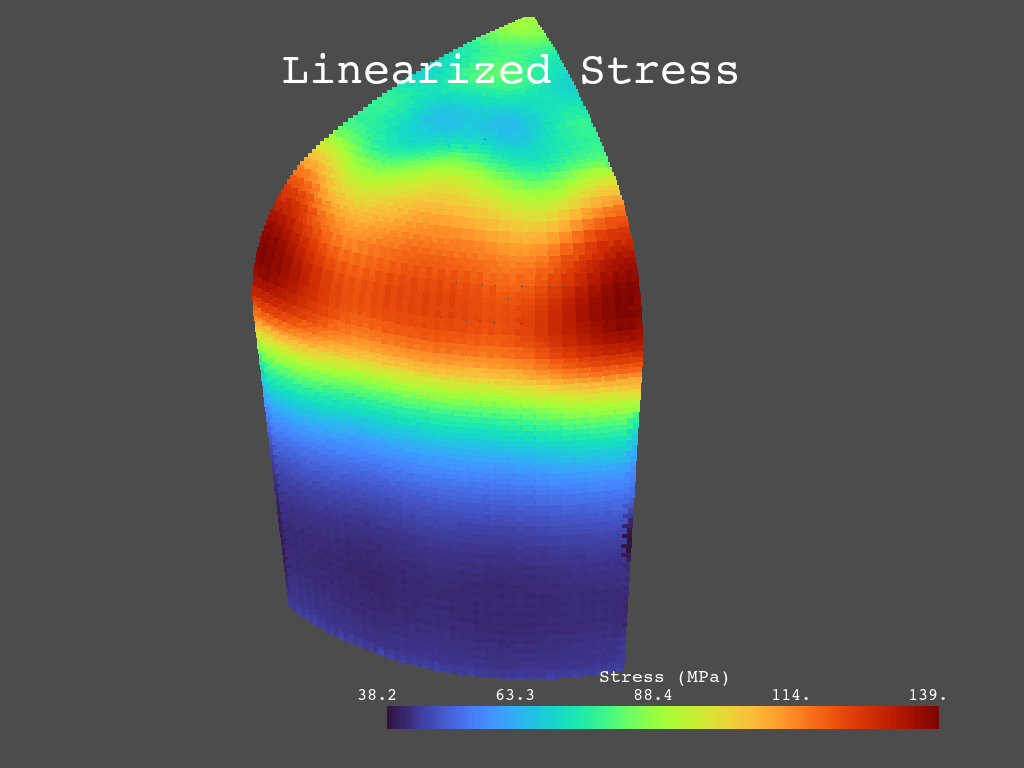

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: nominal


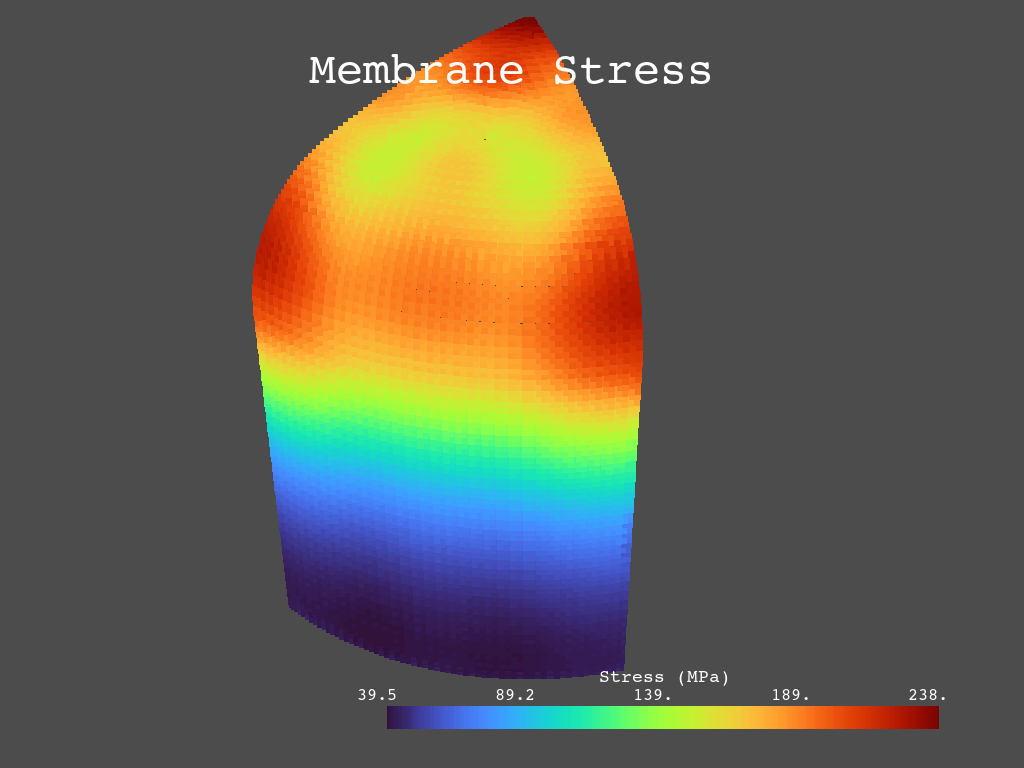

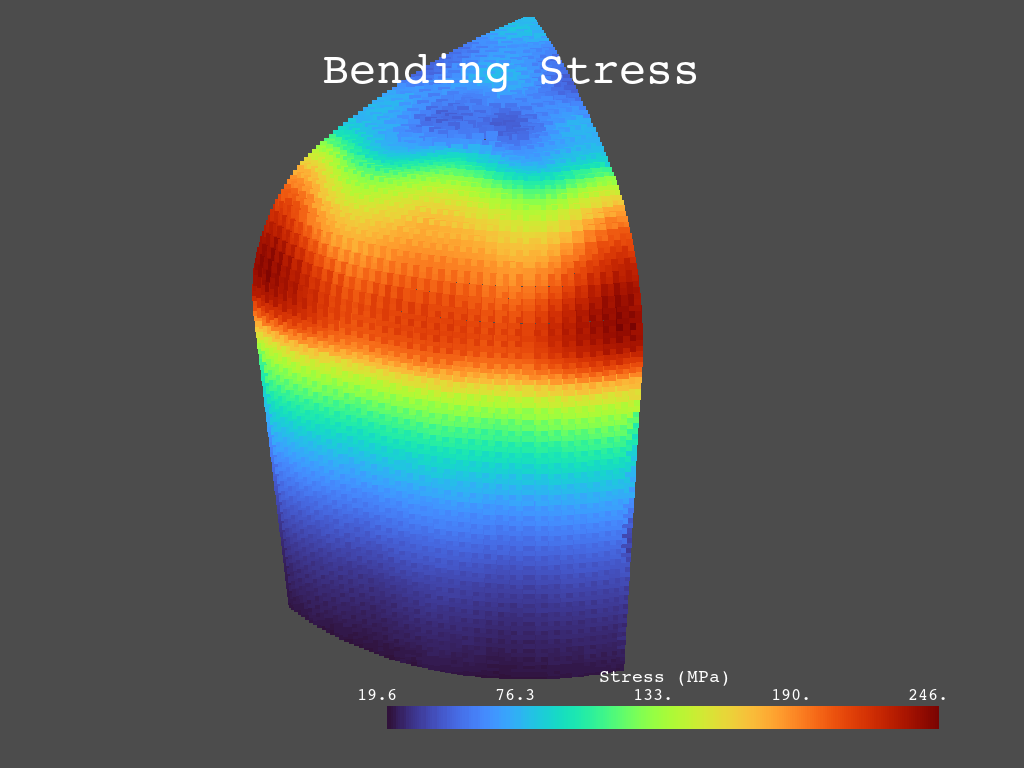

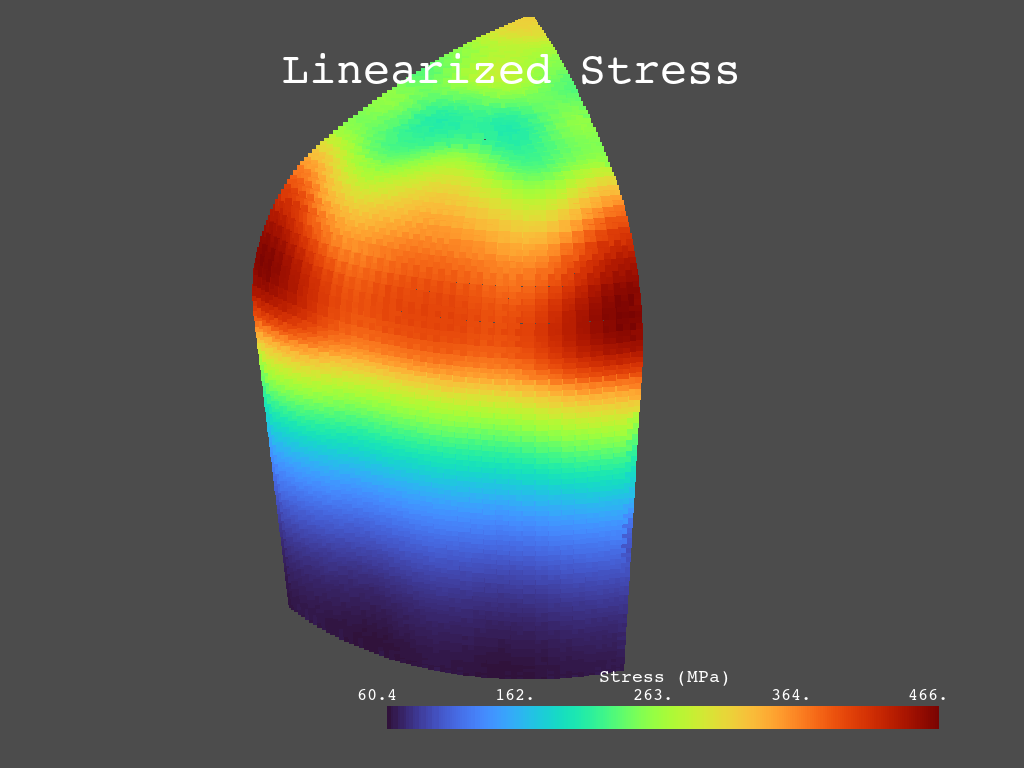

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: high2


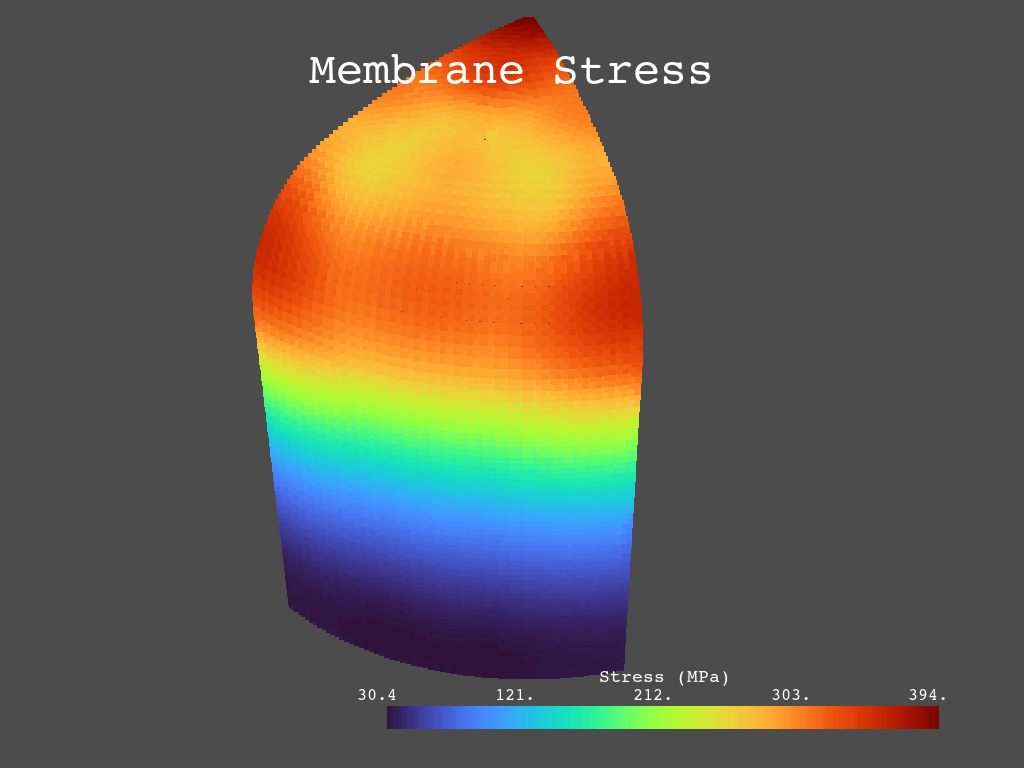

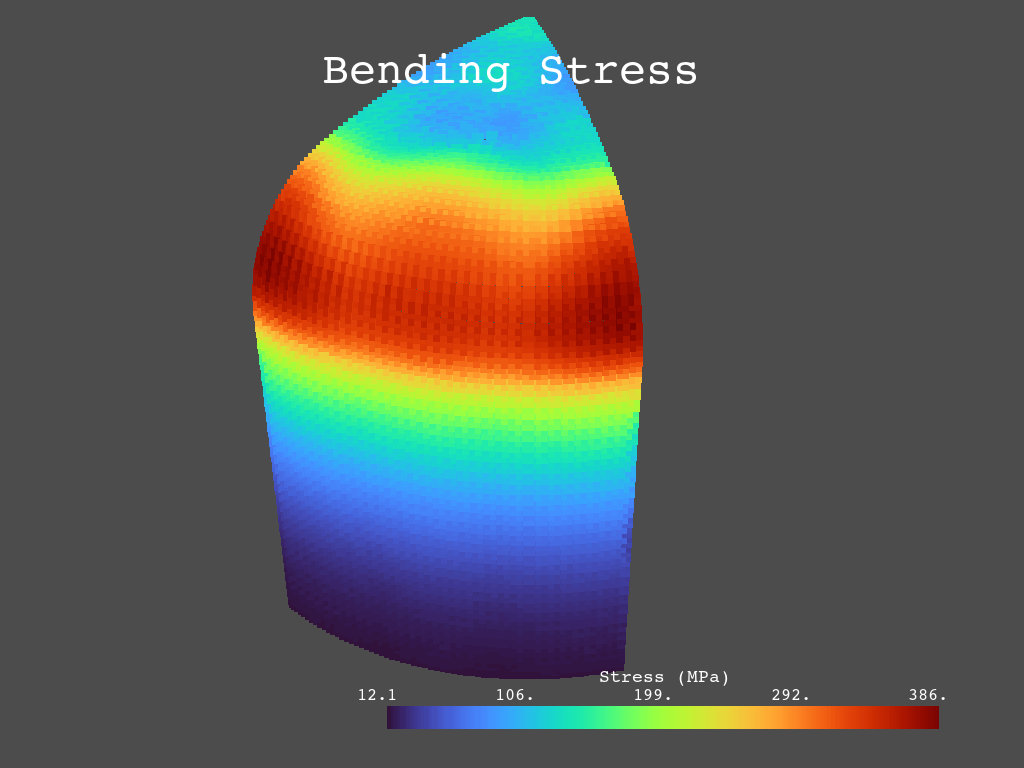

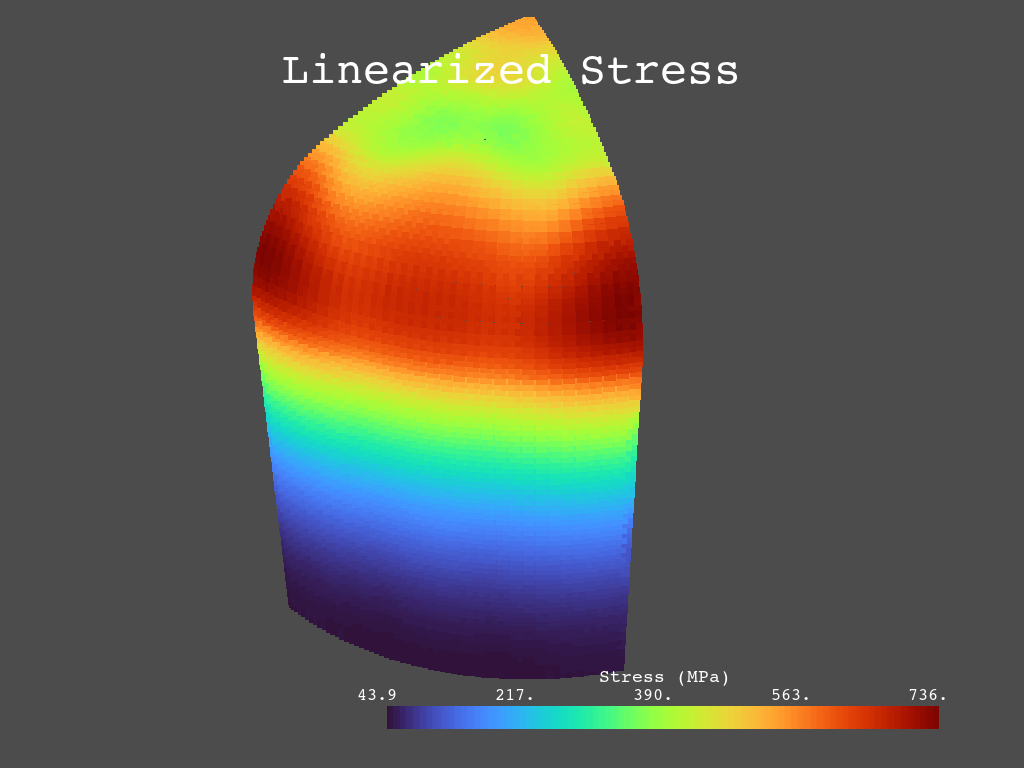

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: high


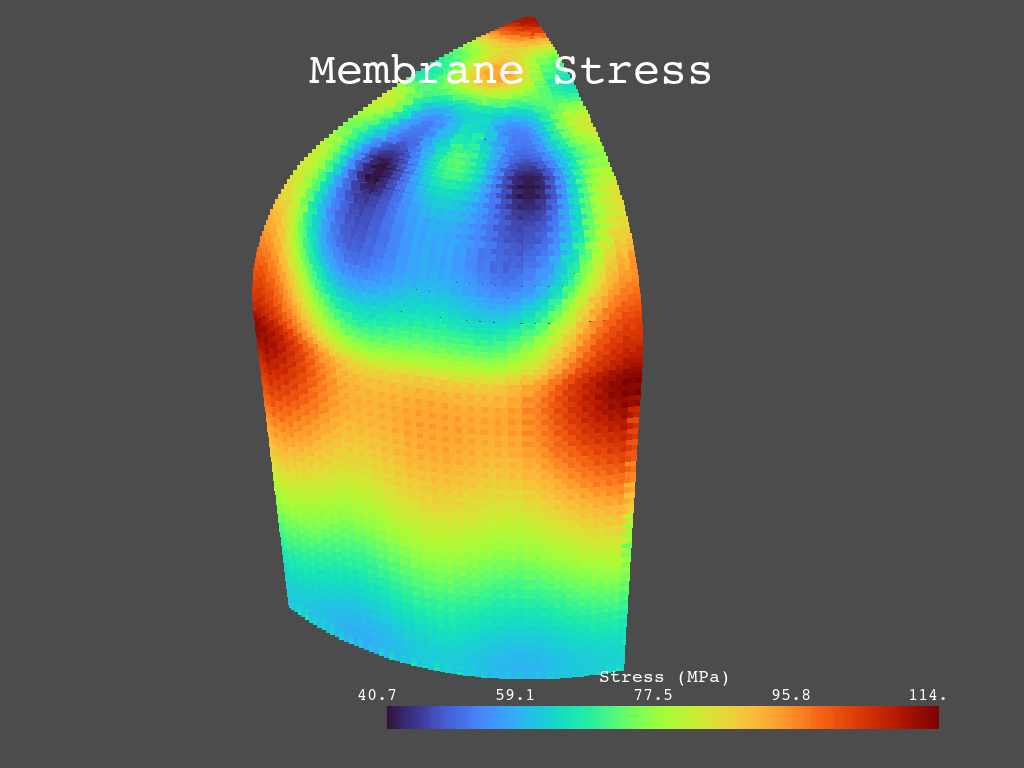

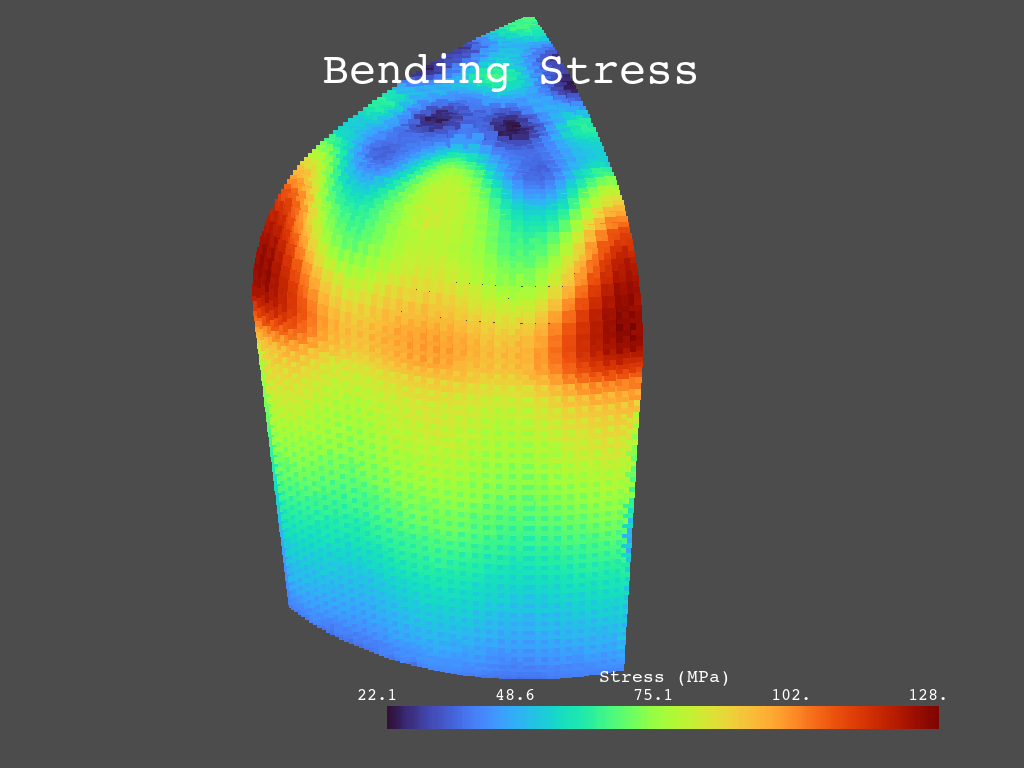

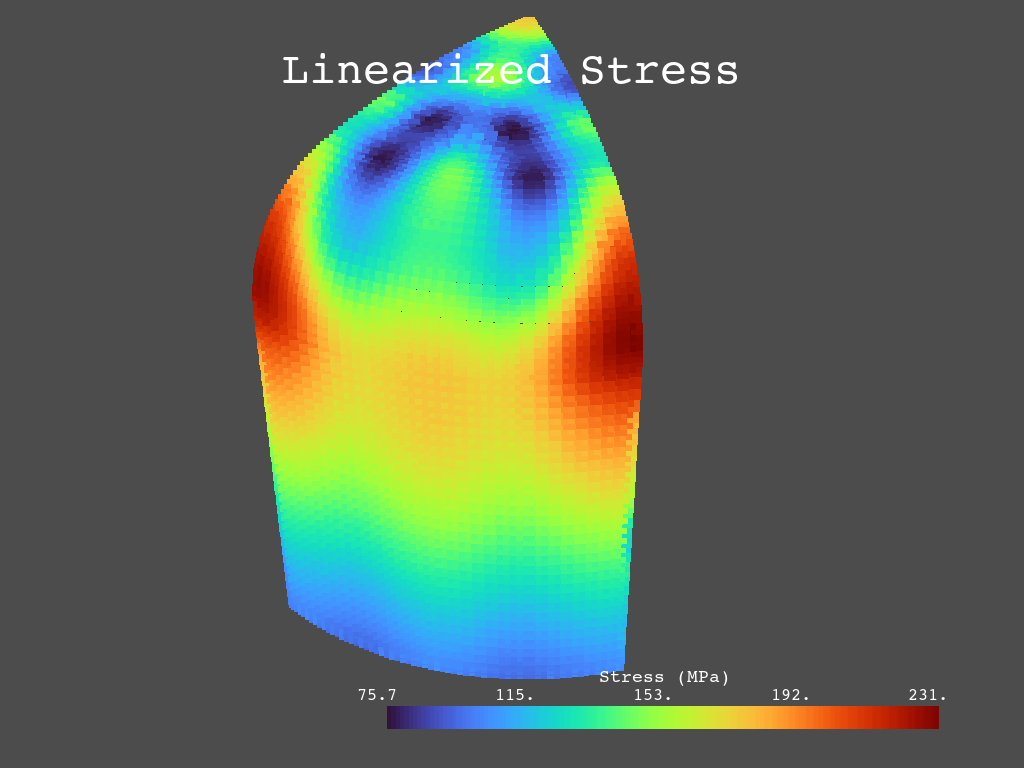

Max Membrane: [70.73174773240464, 238.17589198704573, 394.3993075988889, 114.20646980279744]
Max Bending: [68.93810012256226, 246.3710954950658, 385.8122388435393, 128.20546730040783]
Max Linearized: [138.6422909116539, 465.80177436124416, 736.0572061951044, 231.22381597500393]
____________________________________
Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: low


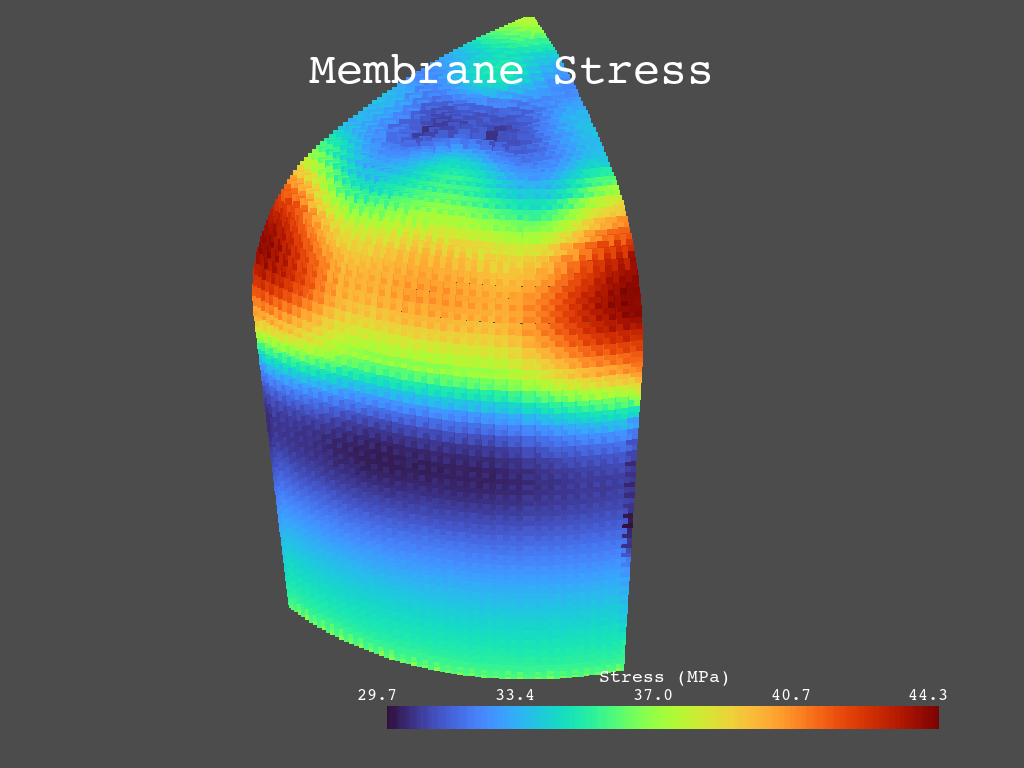

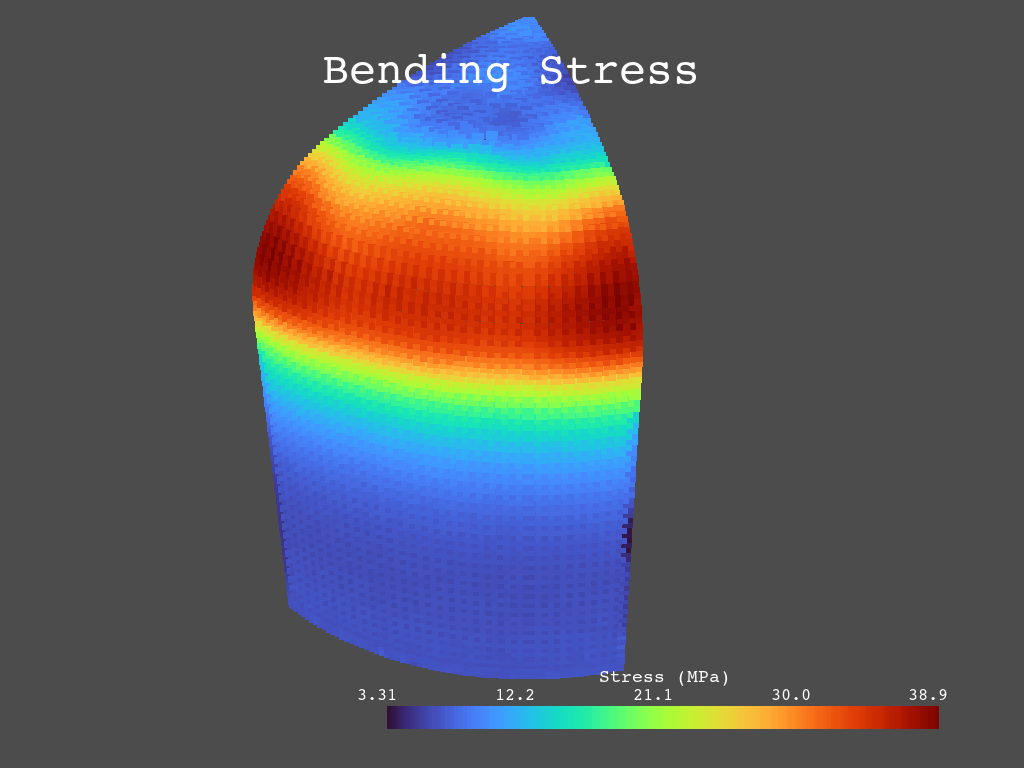

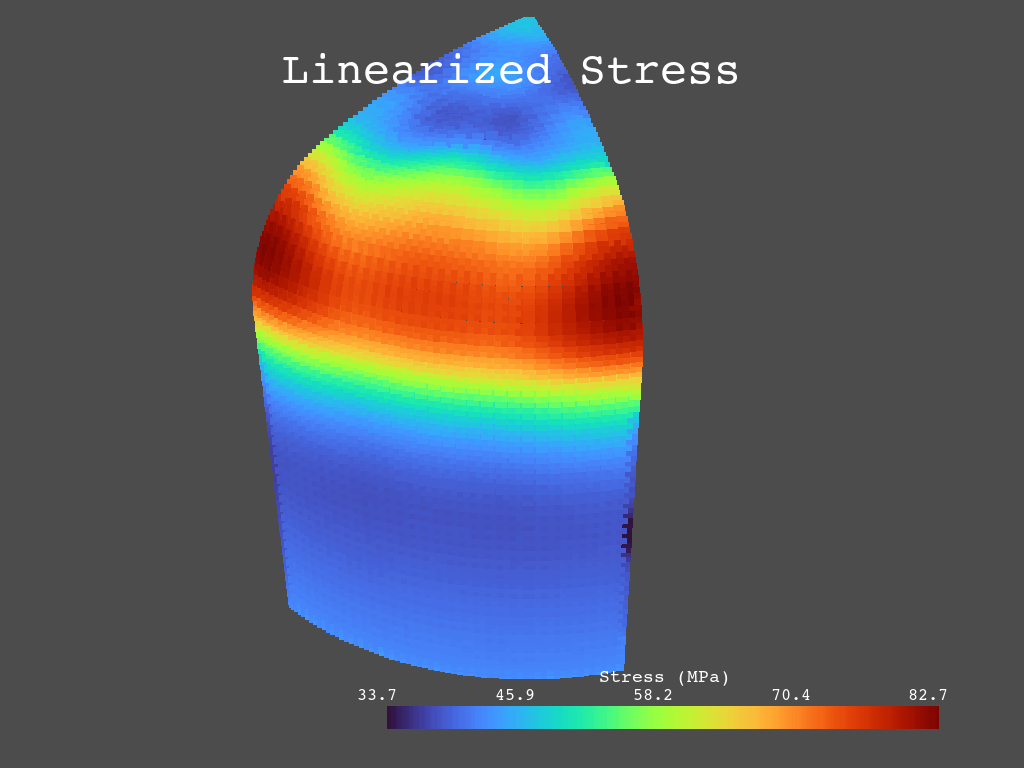

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: nominal


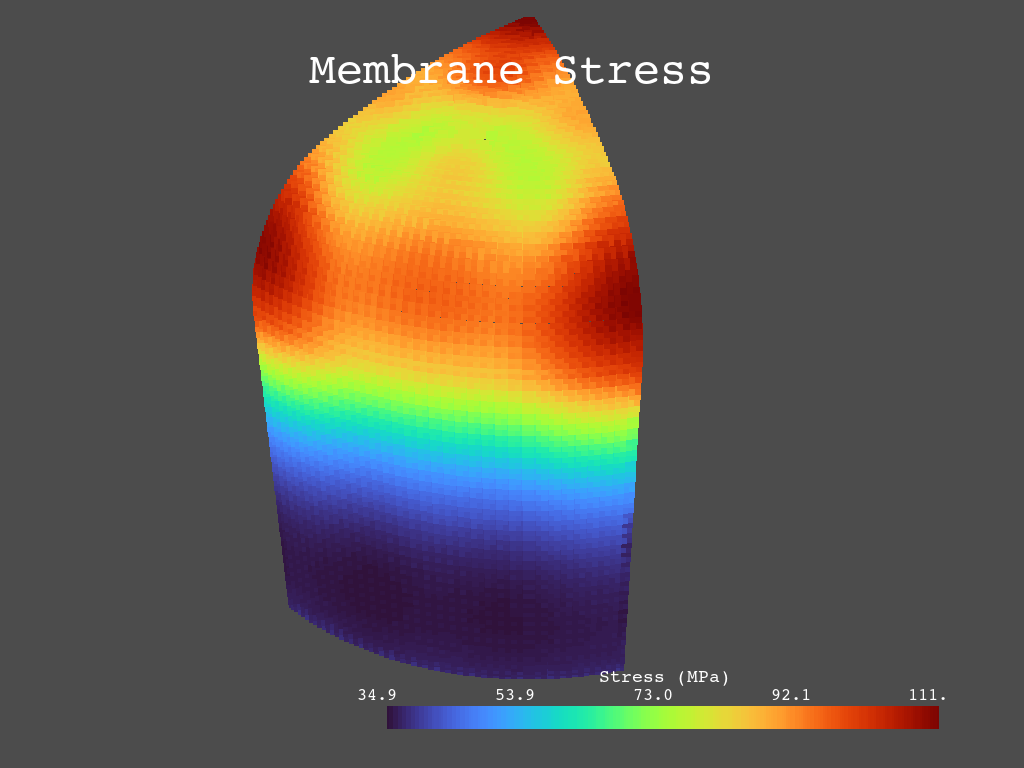

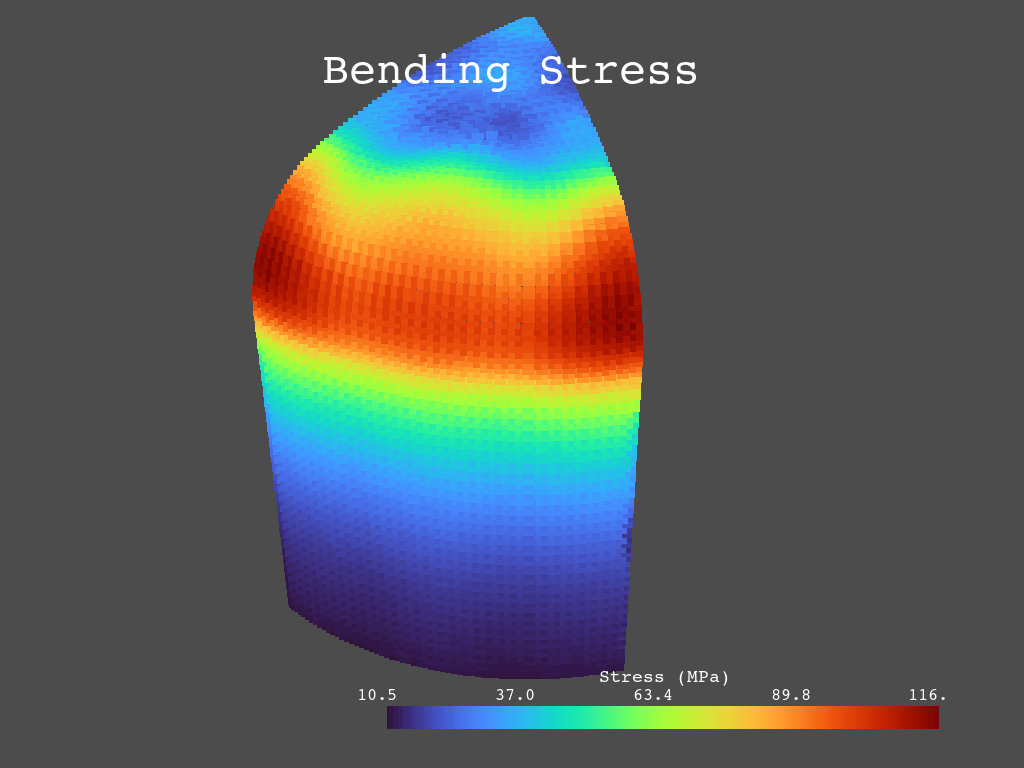

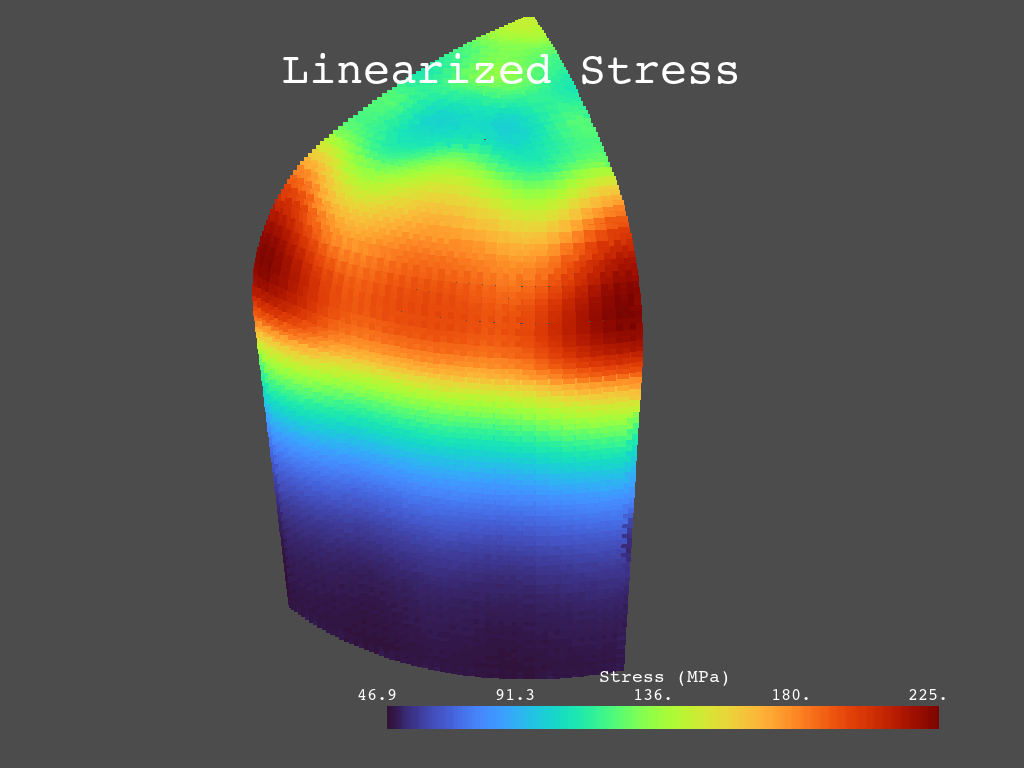

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: high2


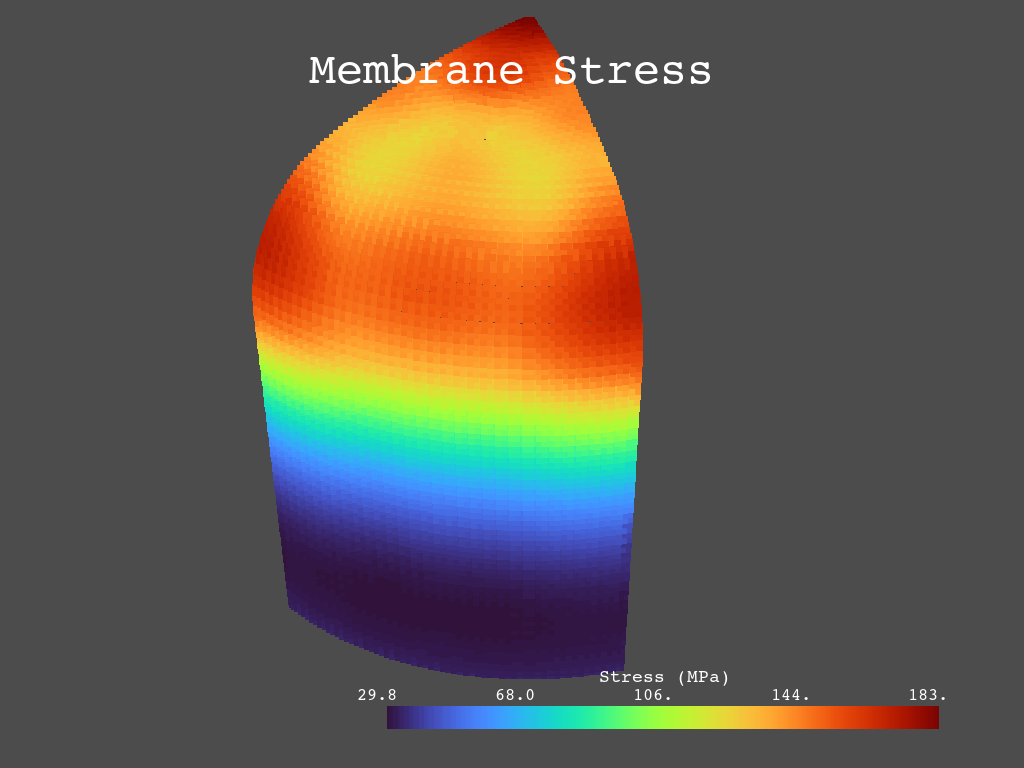

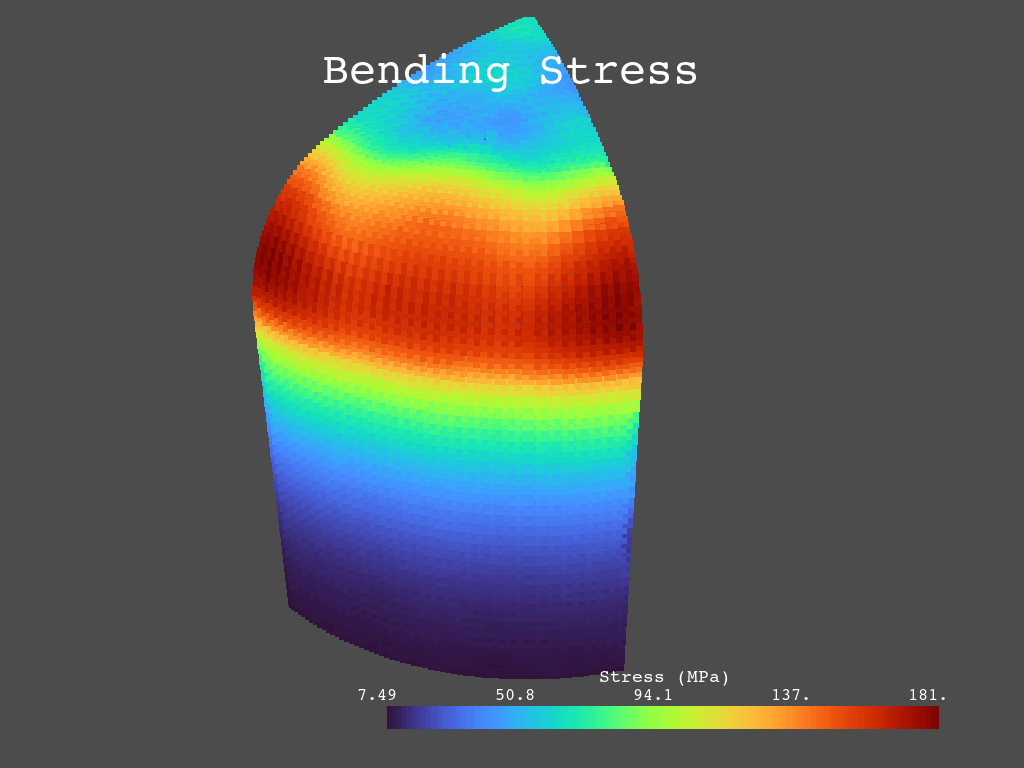

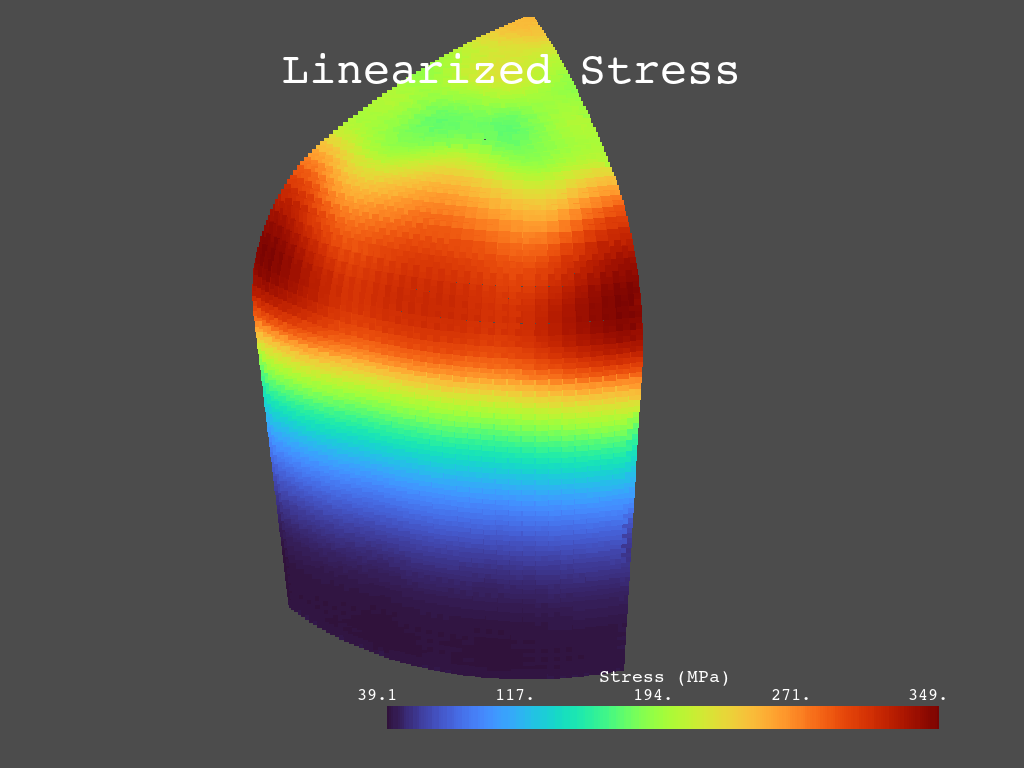

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: high


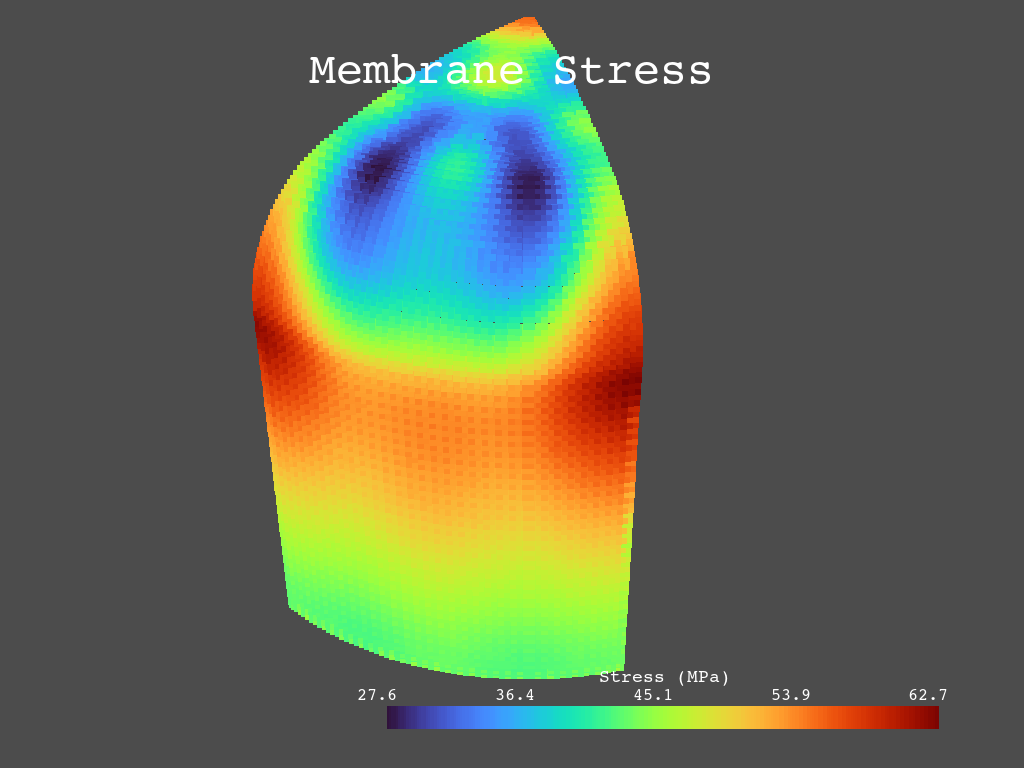

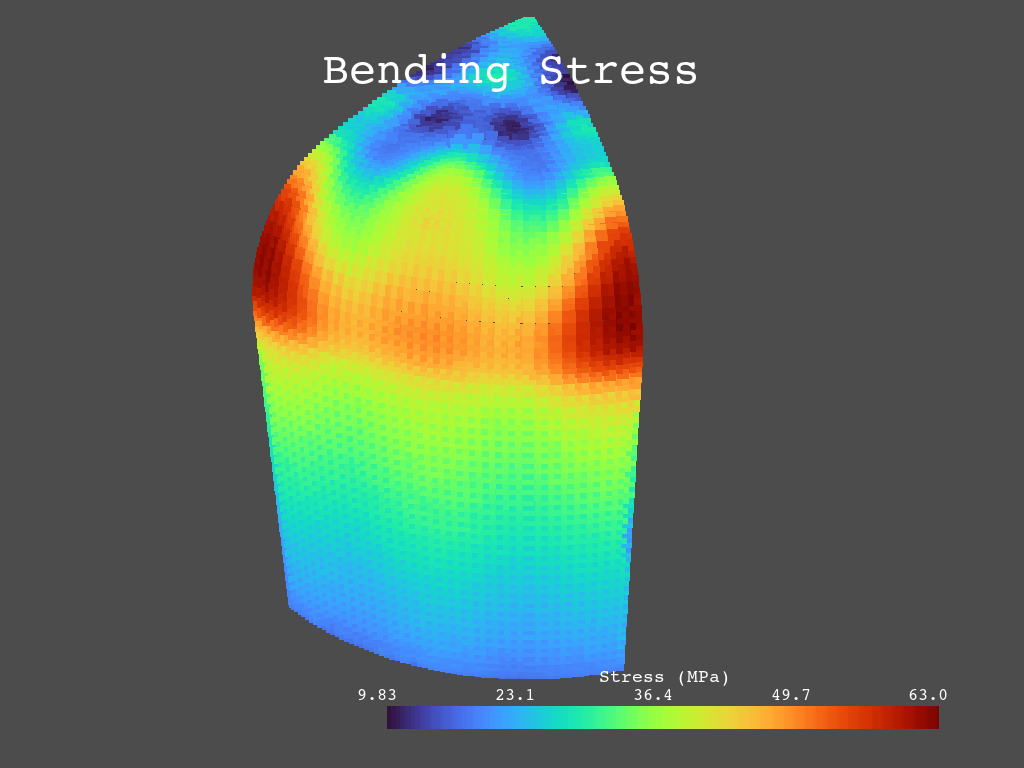

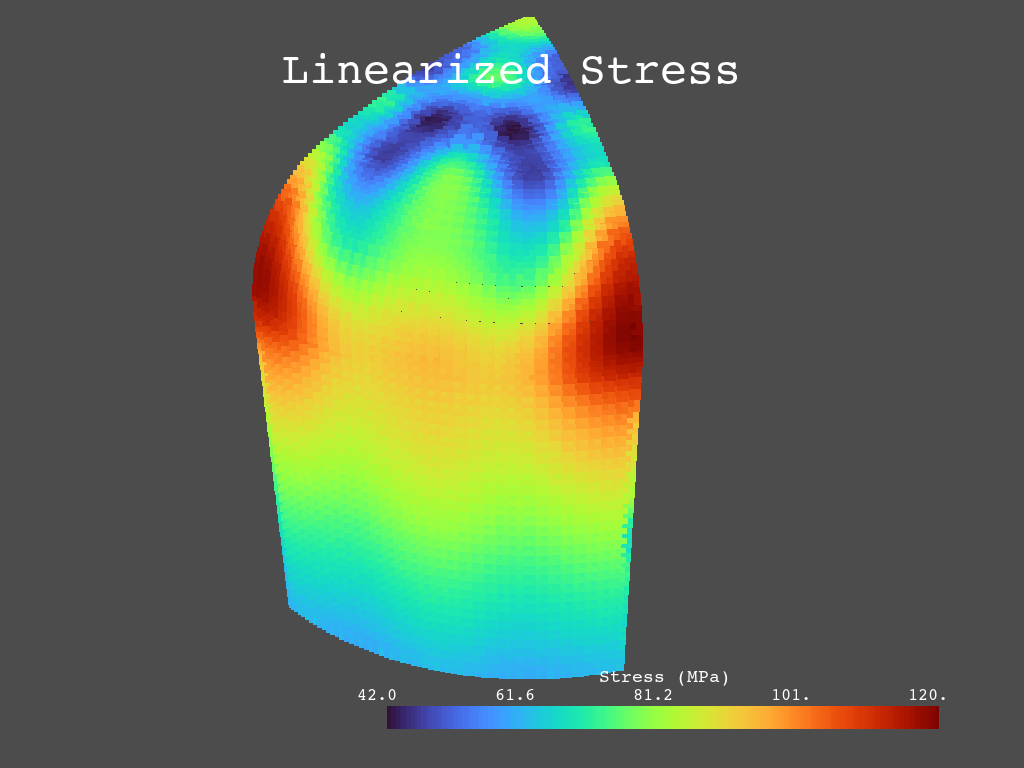

Max Membrane: [44.298755427511324, 111.20599699731032, 182.6090397261964, 62.65215450813877]
Max Bending: [38.94288175477372, 116.27606577911241, 180.6174336510834, 63.0288451465319]
Max Linearized: [82.67087727607681, 224.66028904547568, 348.8473777297886, 120.32907947857815]
____________________________________
Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: low


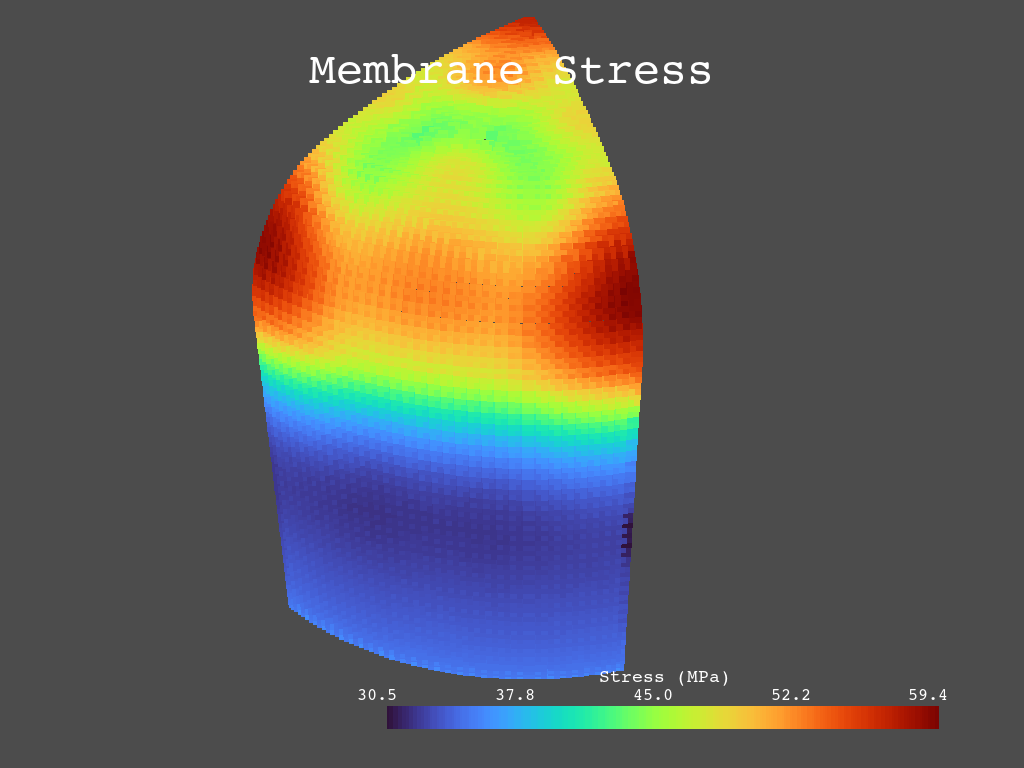

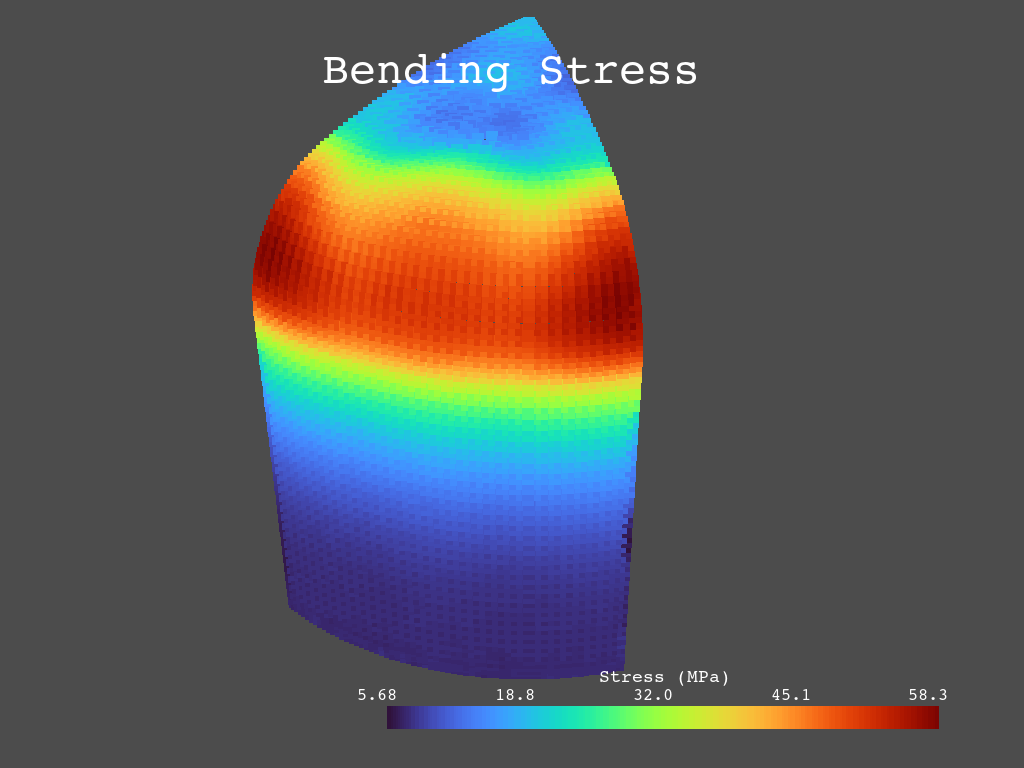

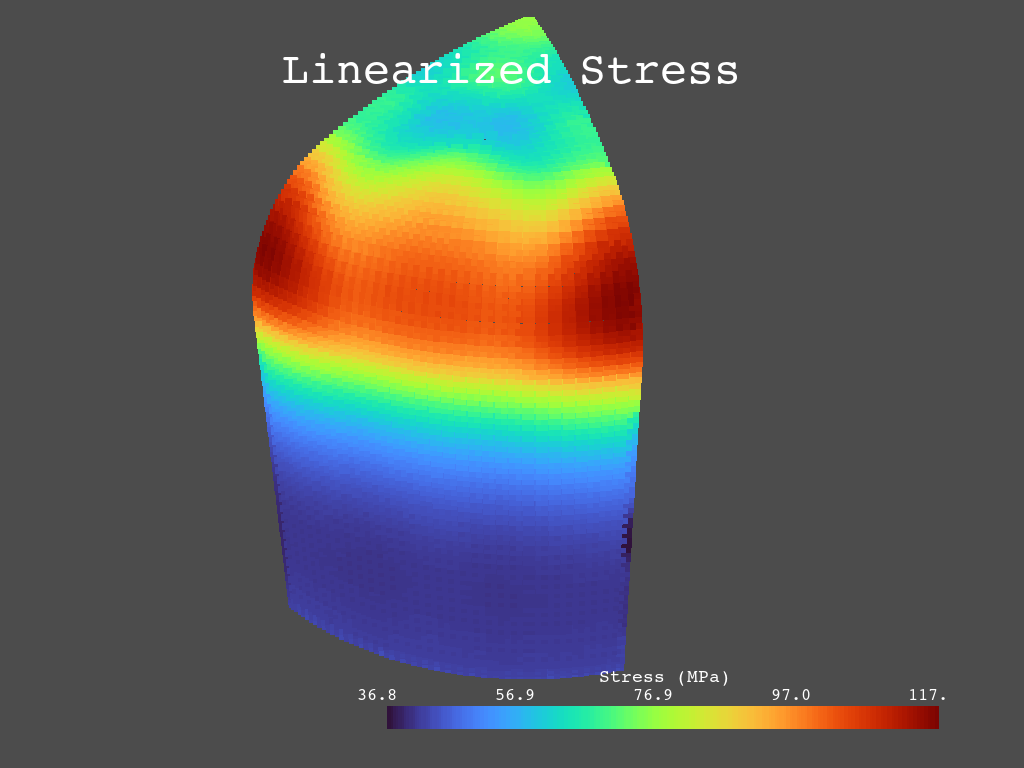

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: nominal


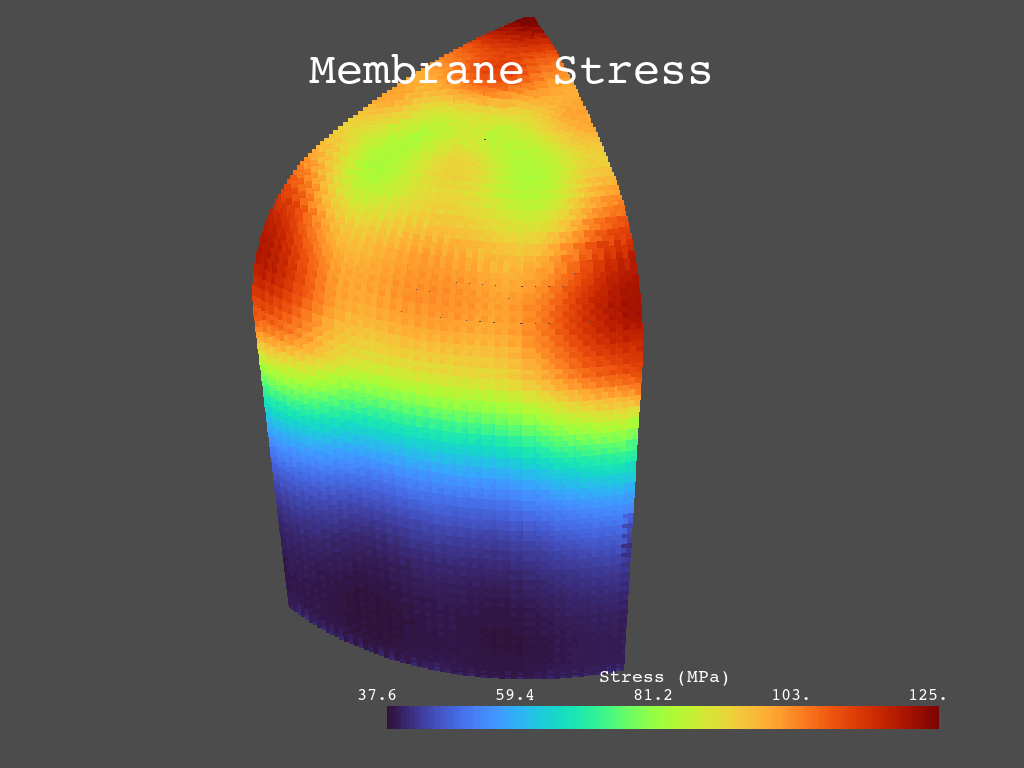

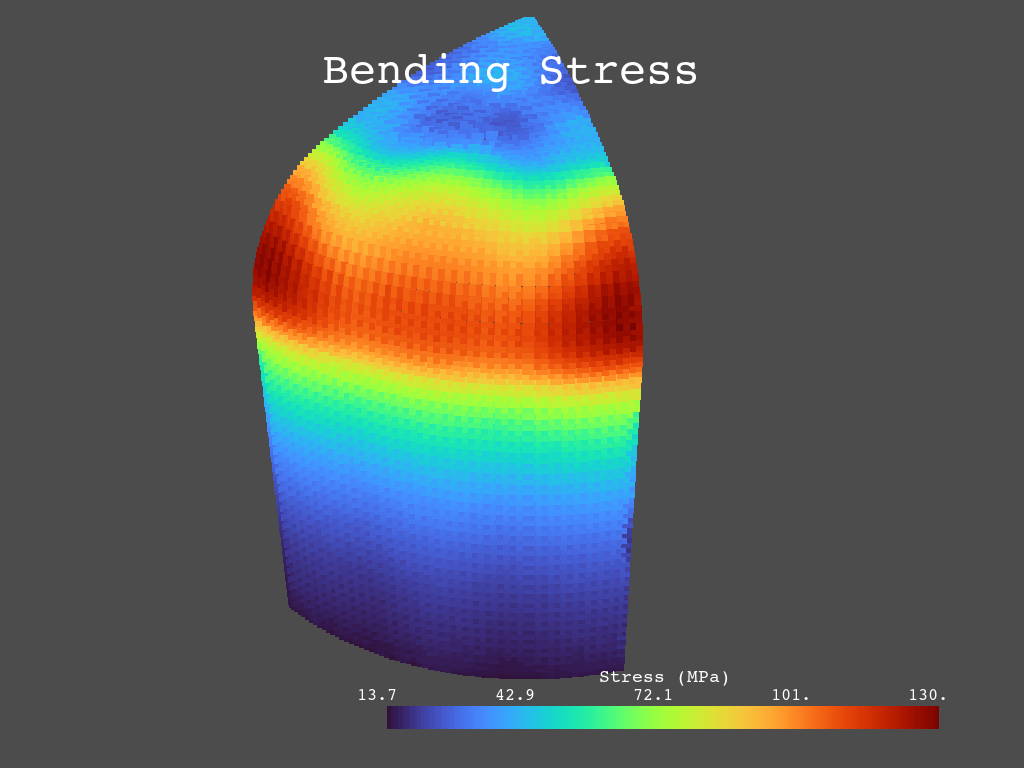

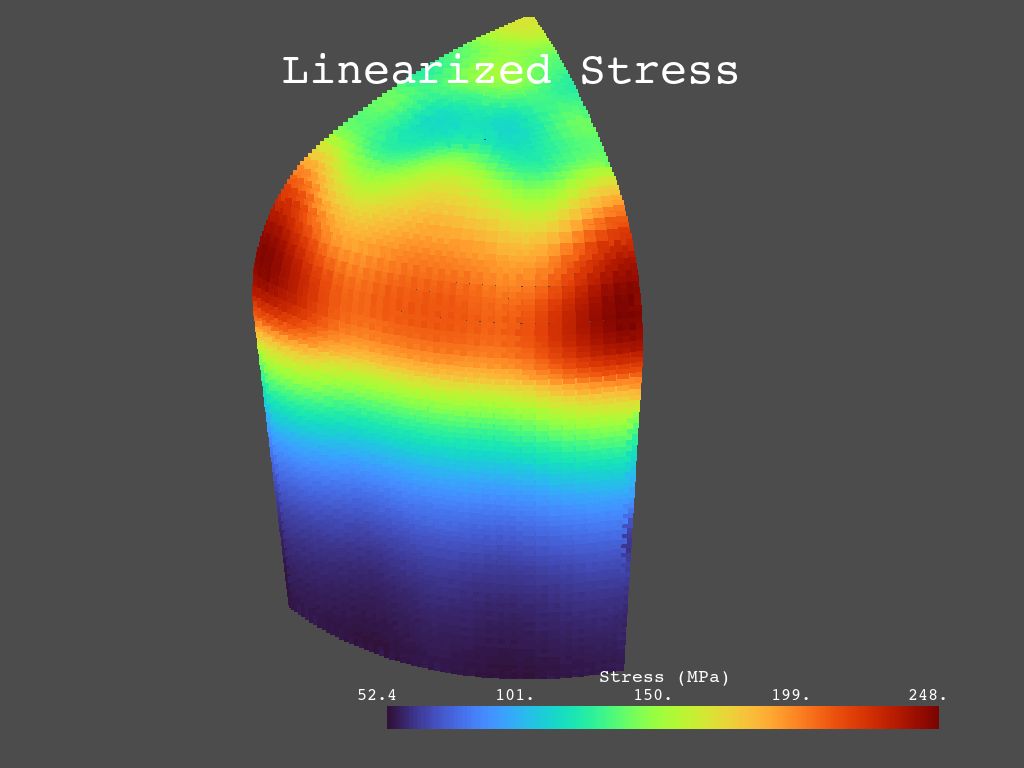

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: high2


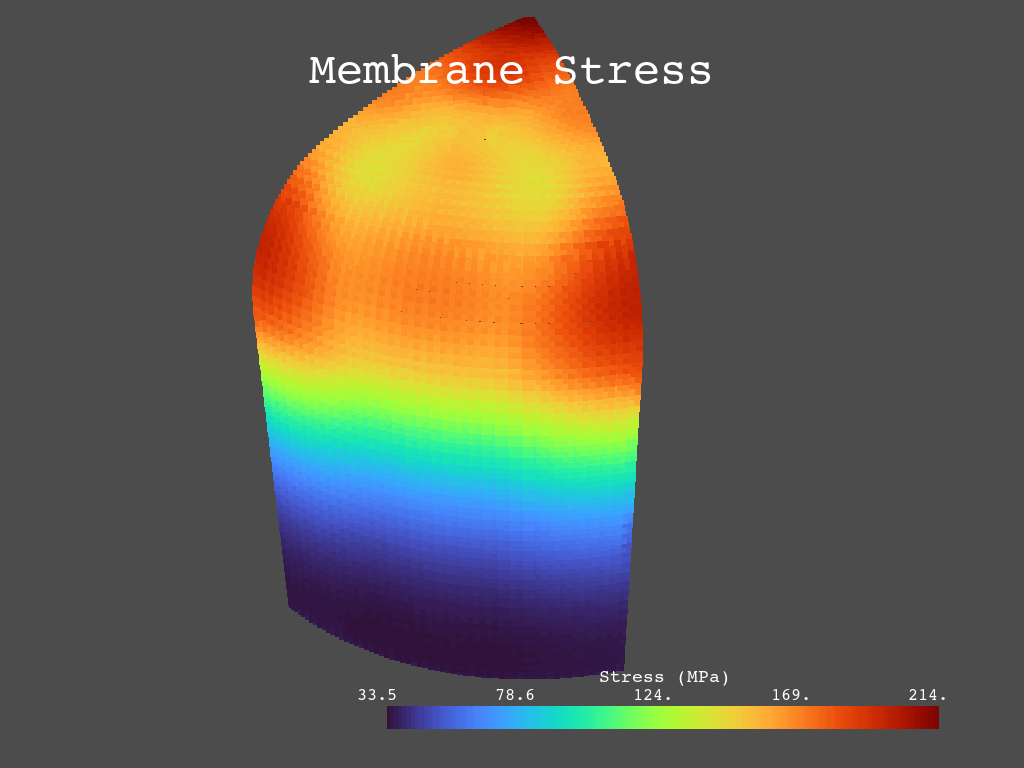

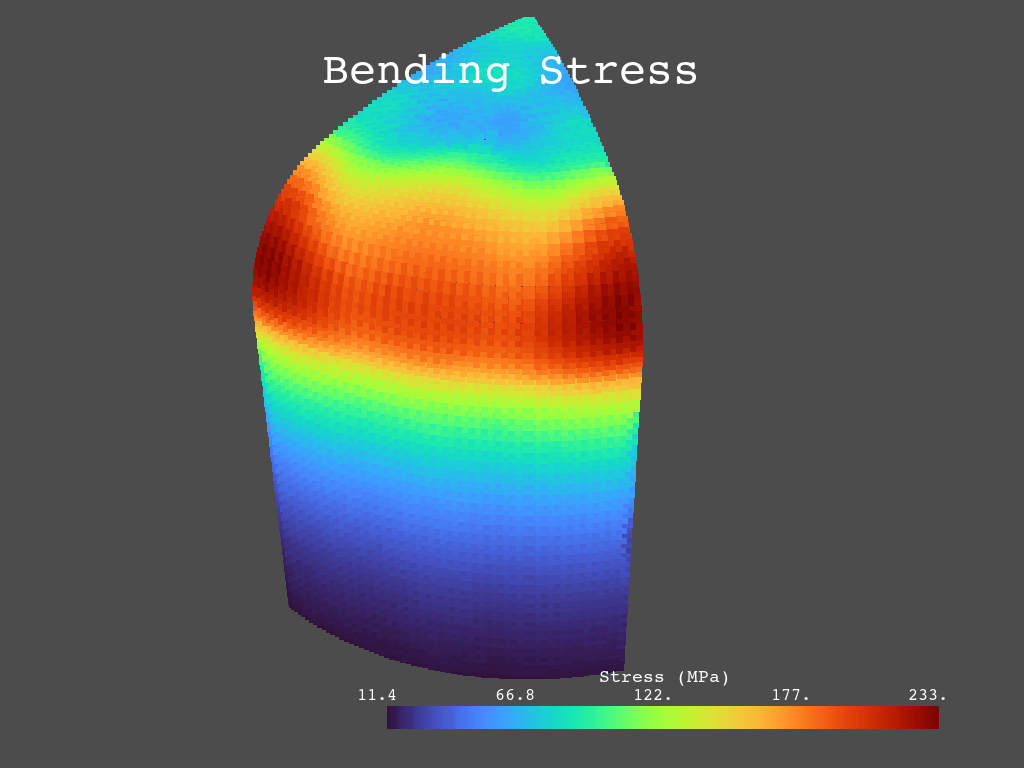

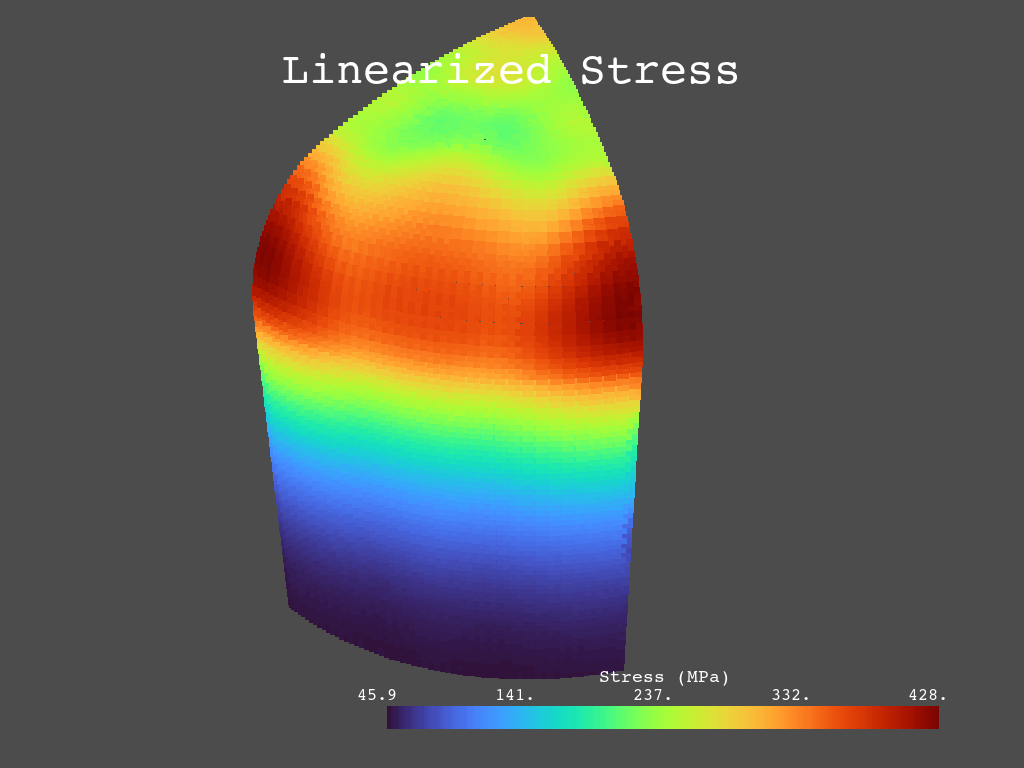

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: high


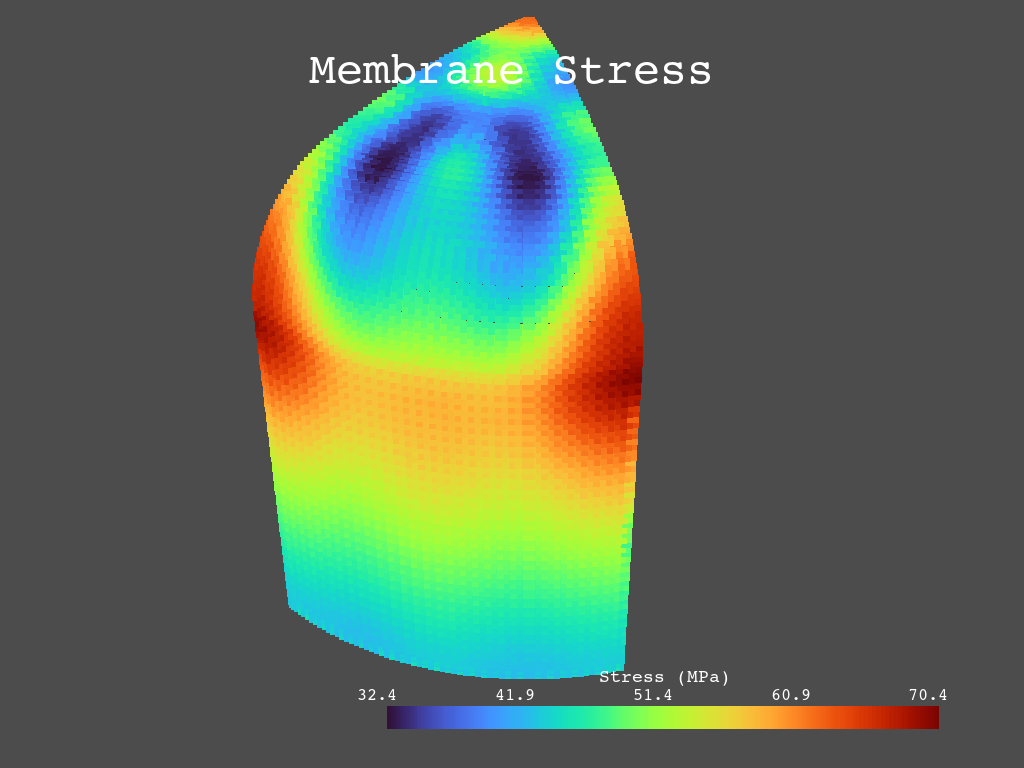

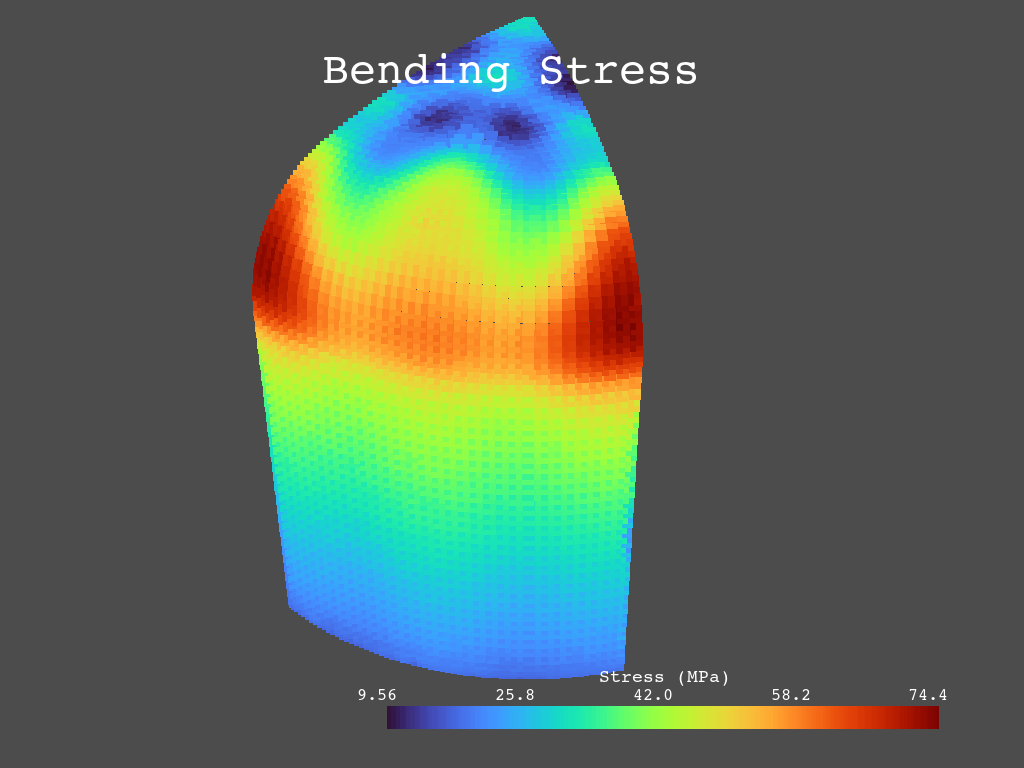

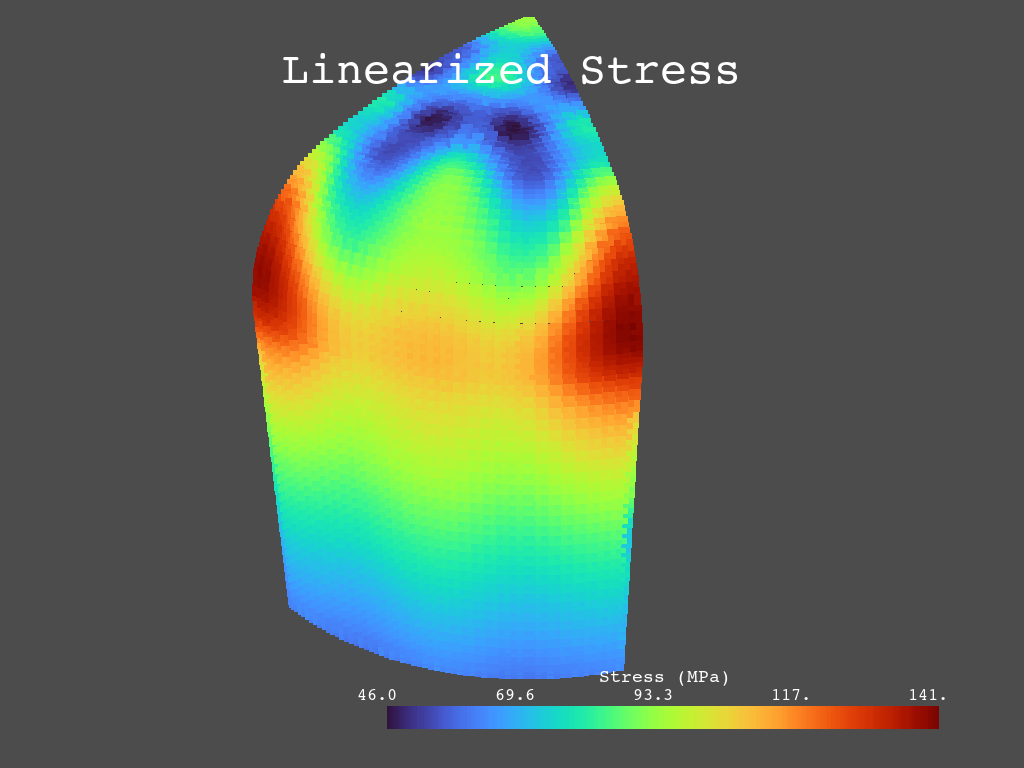

Max Membrane: [59.42827396819631, 124.6948675287747, 213.8602402153624, 70.37036088935308]
Max Bending: [58.301945240763054, 130.38412839969237, 232.7203408481852, 74.40562508541193]
Max Linearized: [117.0545398586489, 248.05778859357002, 427.7906268399531, 140.62277737571884]
____________________________________
Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: low


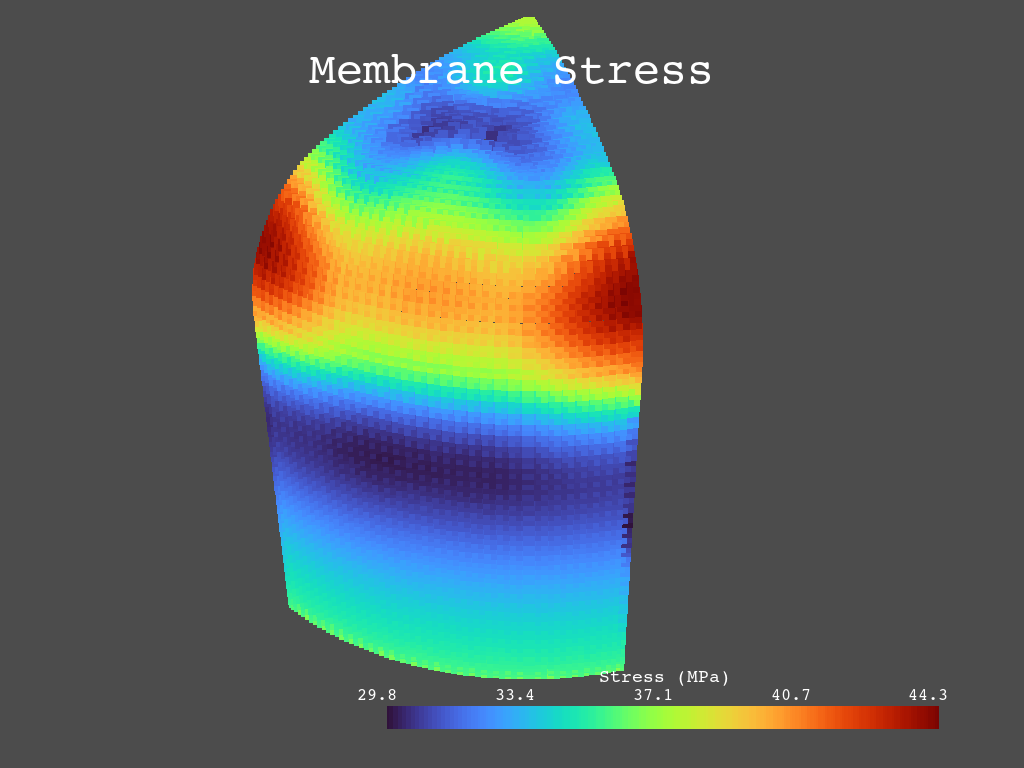

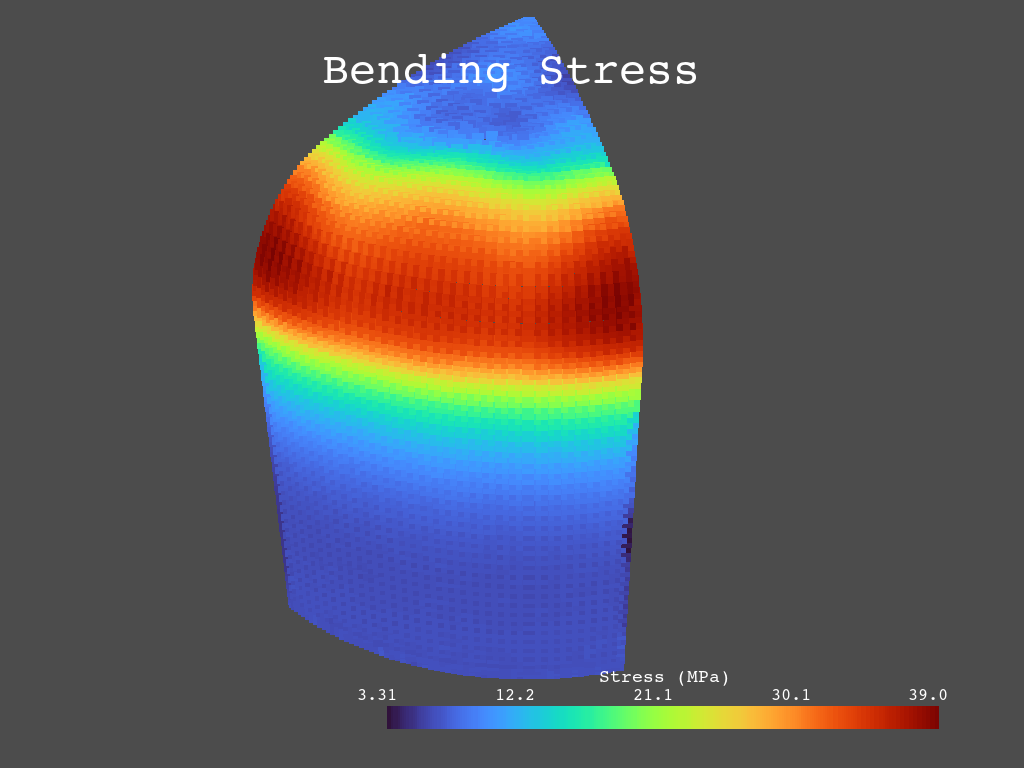

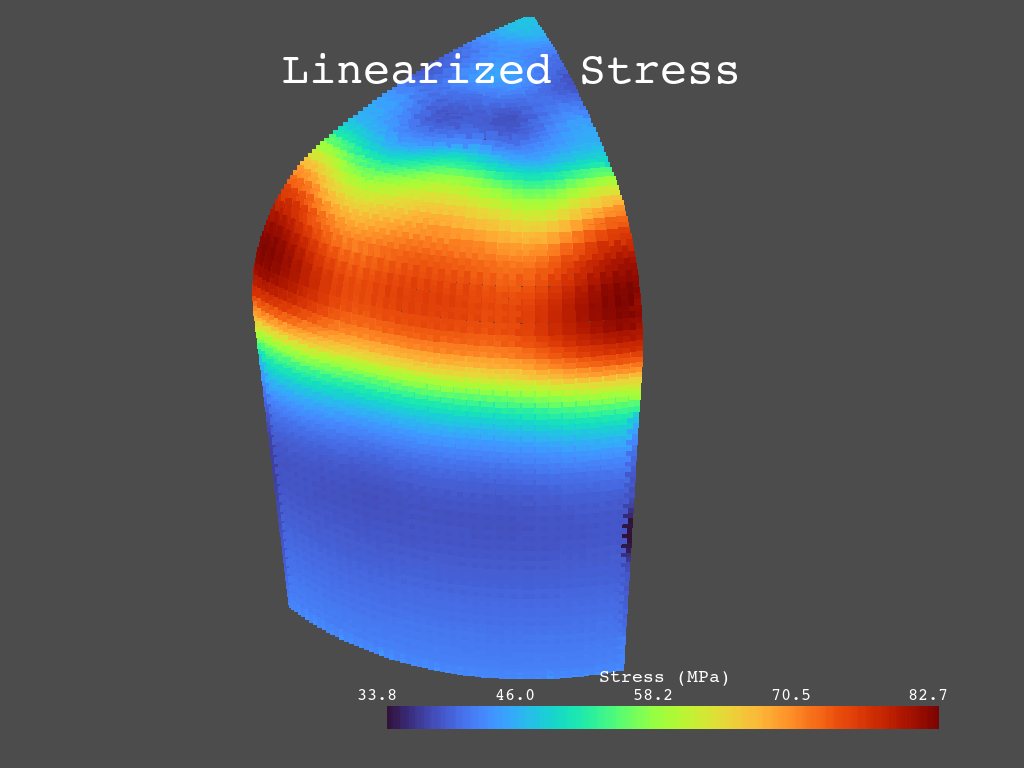

Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: nominal


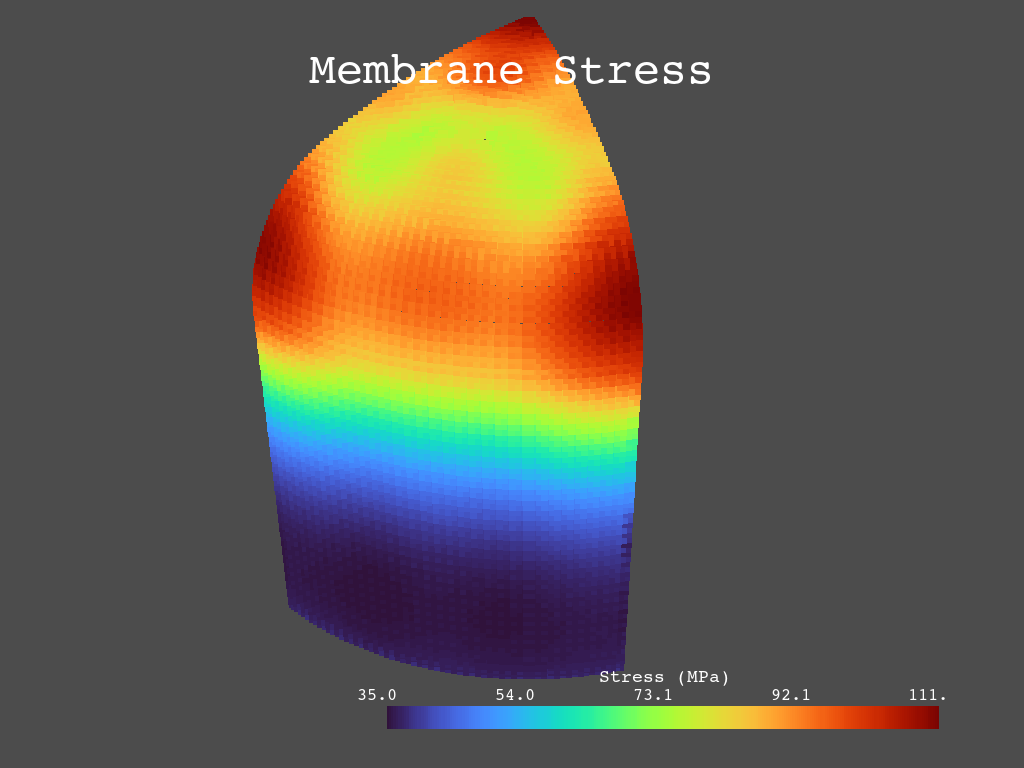

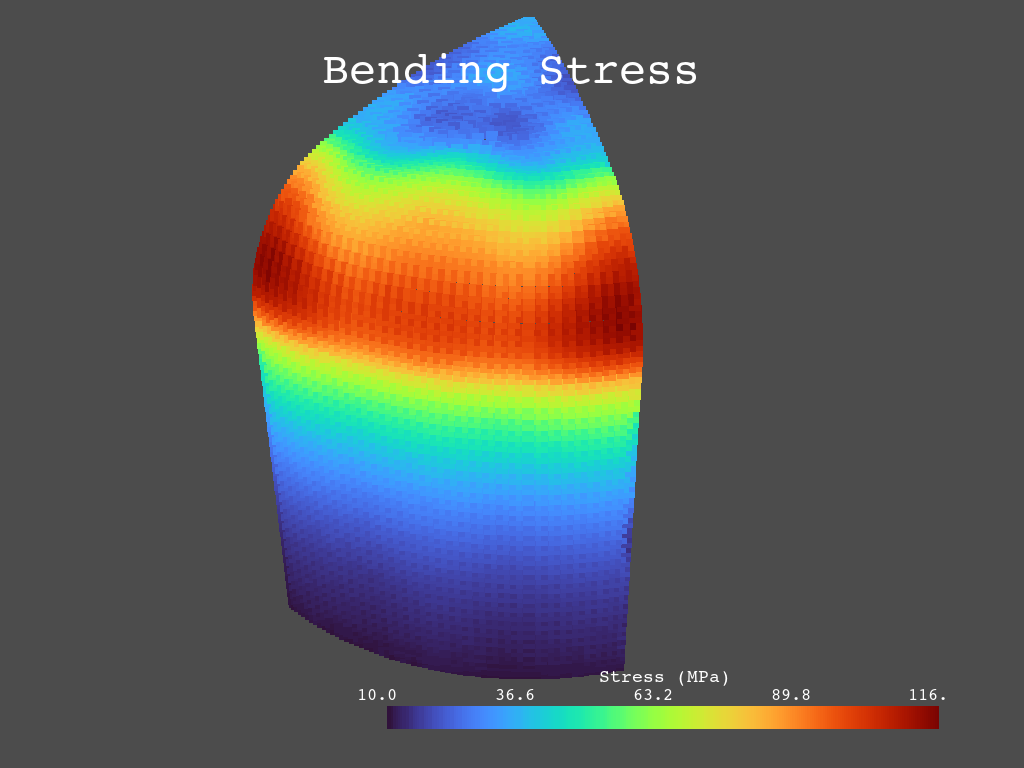

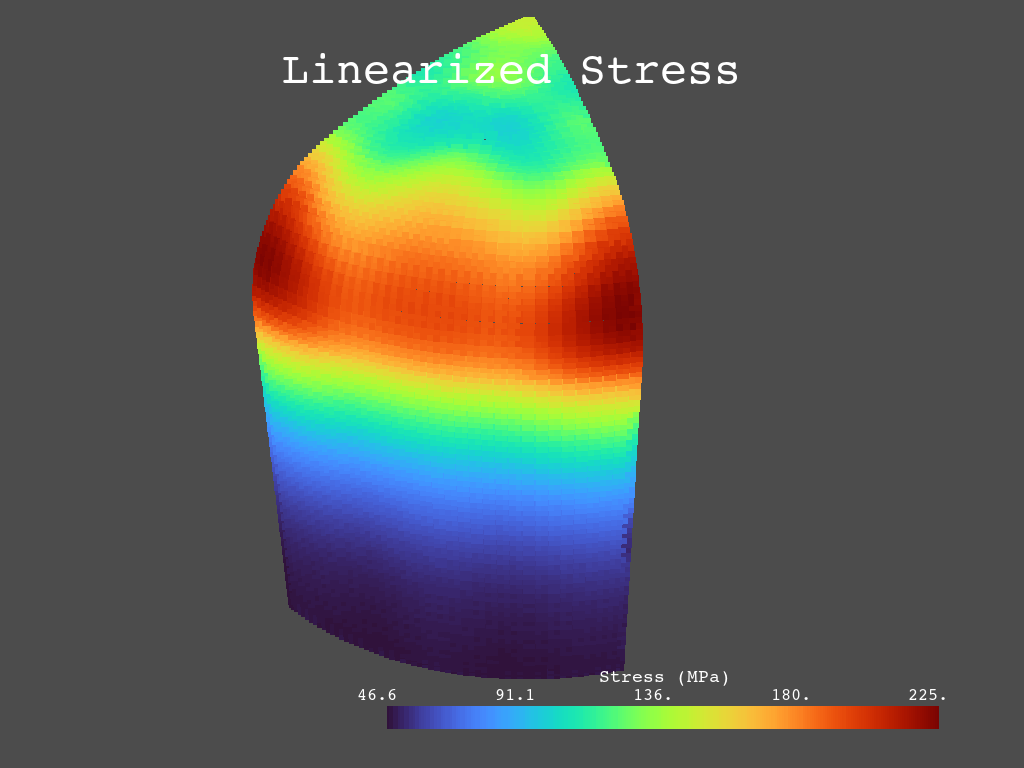

Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: high2


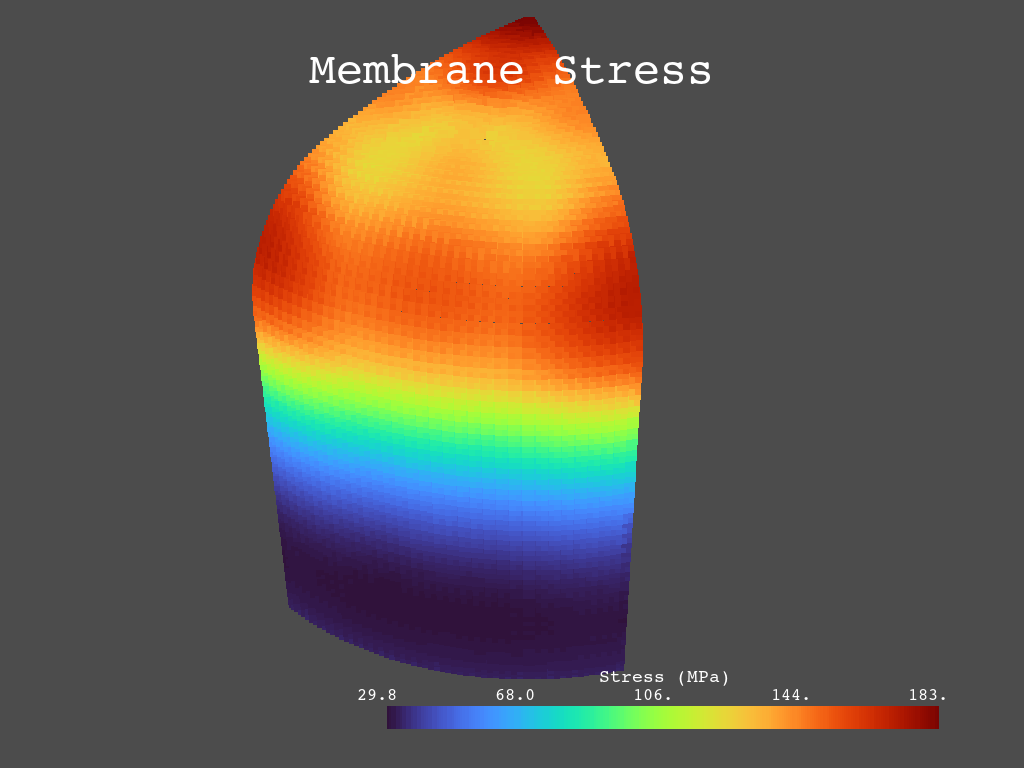

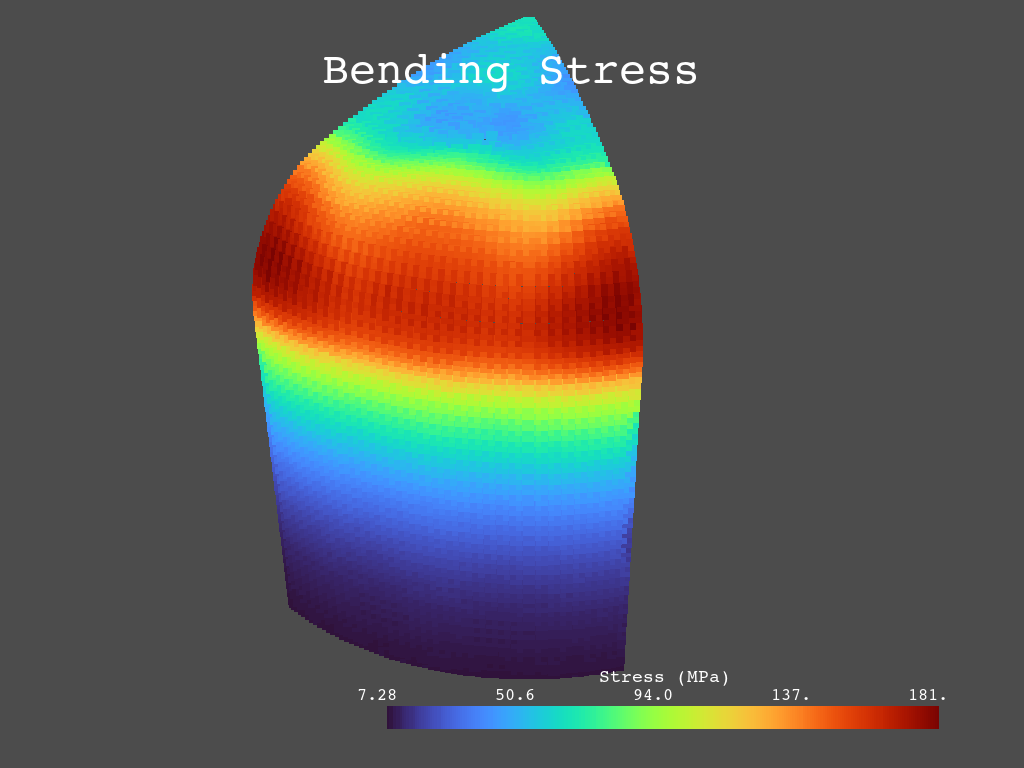

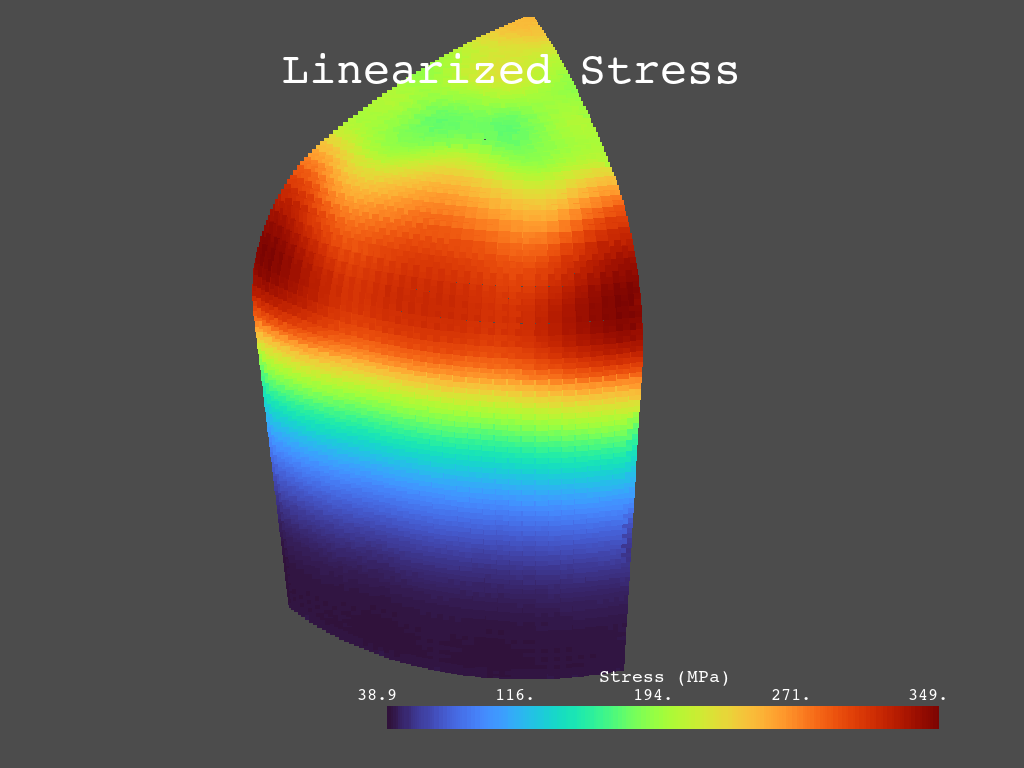

Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: high


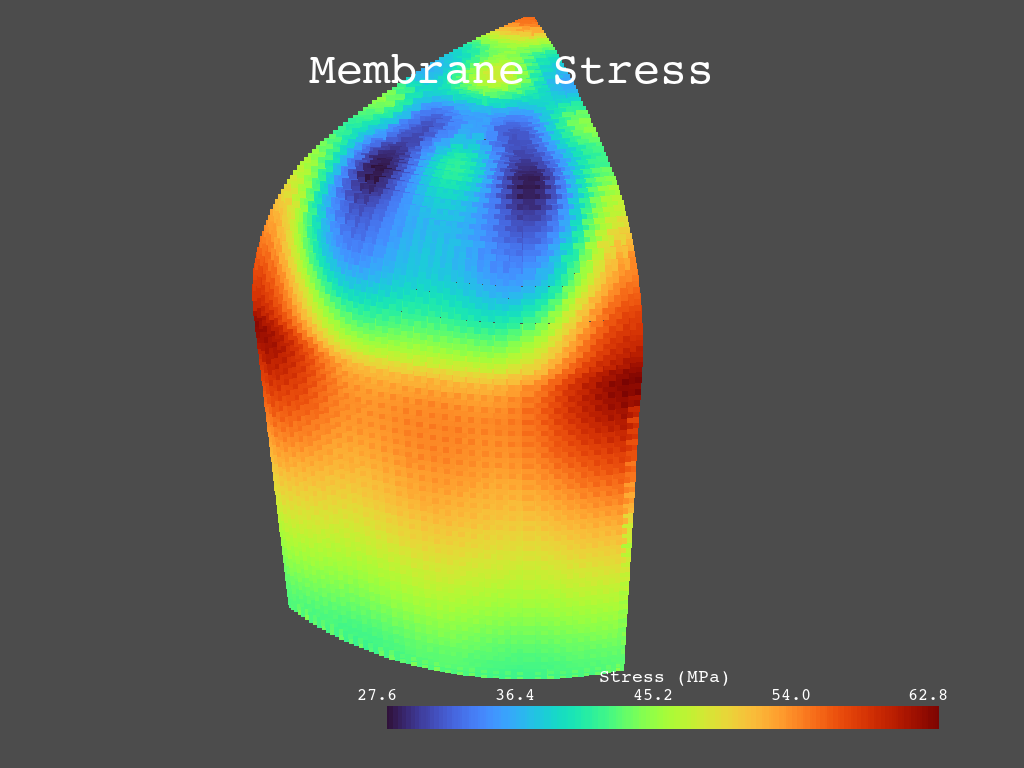

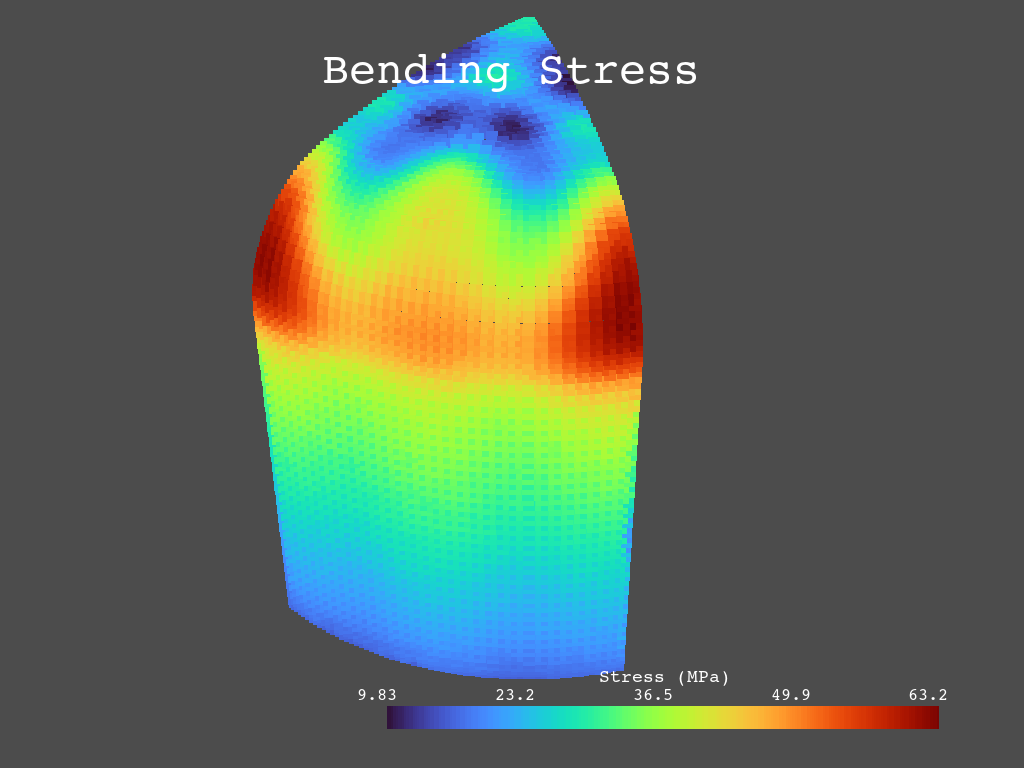

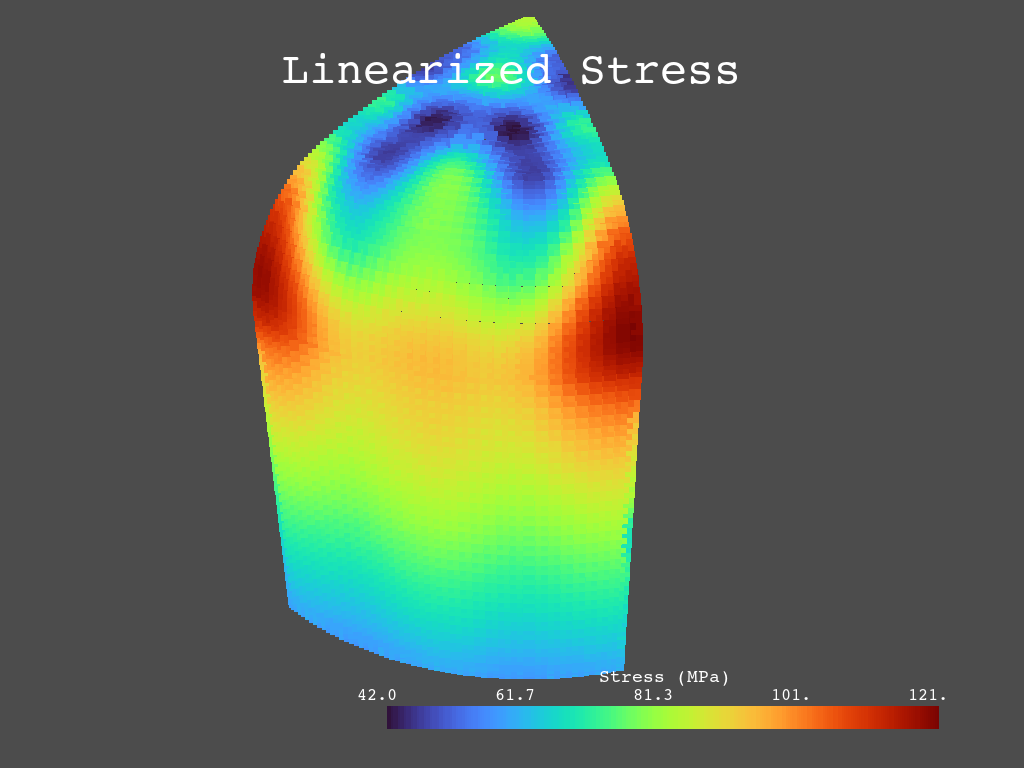

Max Membrane: [44.31189238849008, 111.20488860431595, 182.61001402297748, 62.808528678830314]
Max Bending: [38.96705976178664, 116.33686345065676, 180.6445158631925, 63.19543737191199]
Max Linearized: [82.7041935652968, 224.74790366265694, 348.8858665042385, 120.60057368776168]
____________________________________


In [11]:
stress_membrane, stress_bending, stress_linearized = plot_linearization(True)

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: low


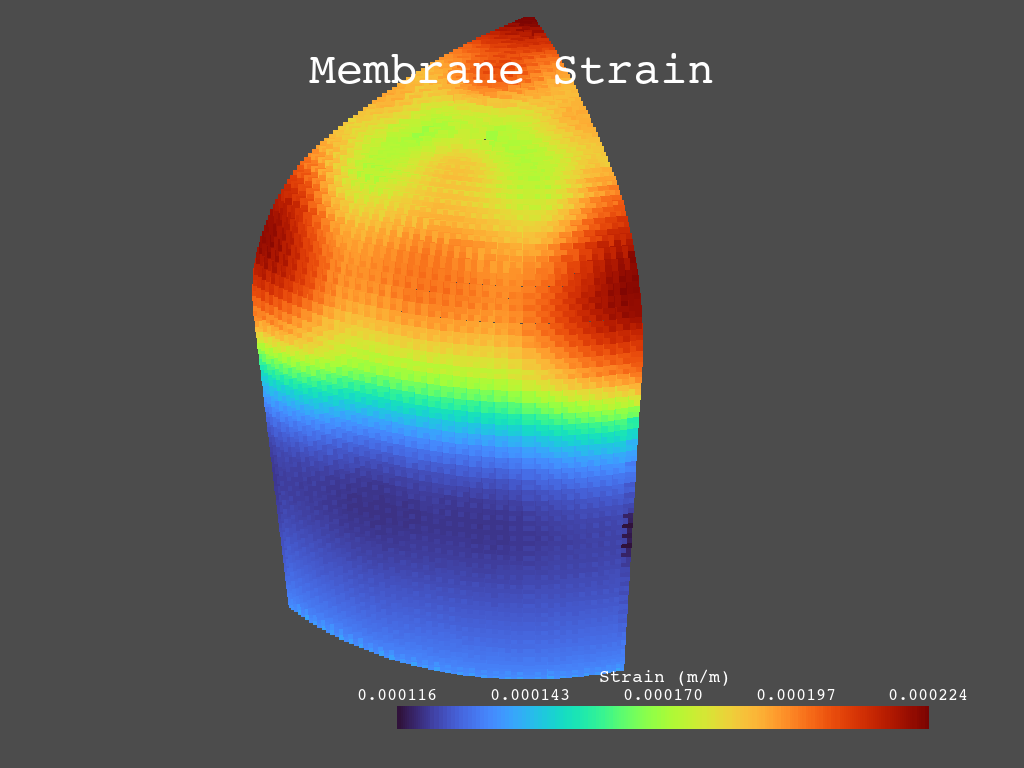

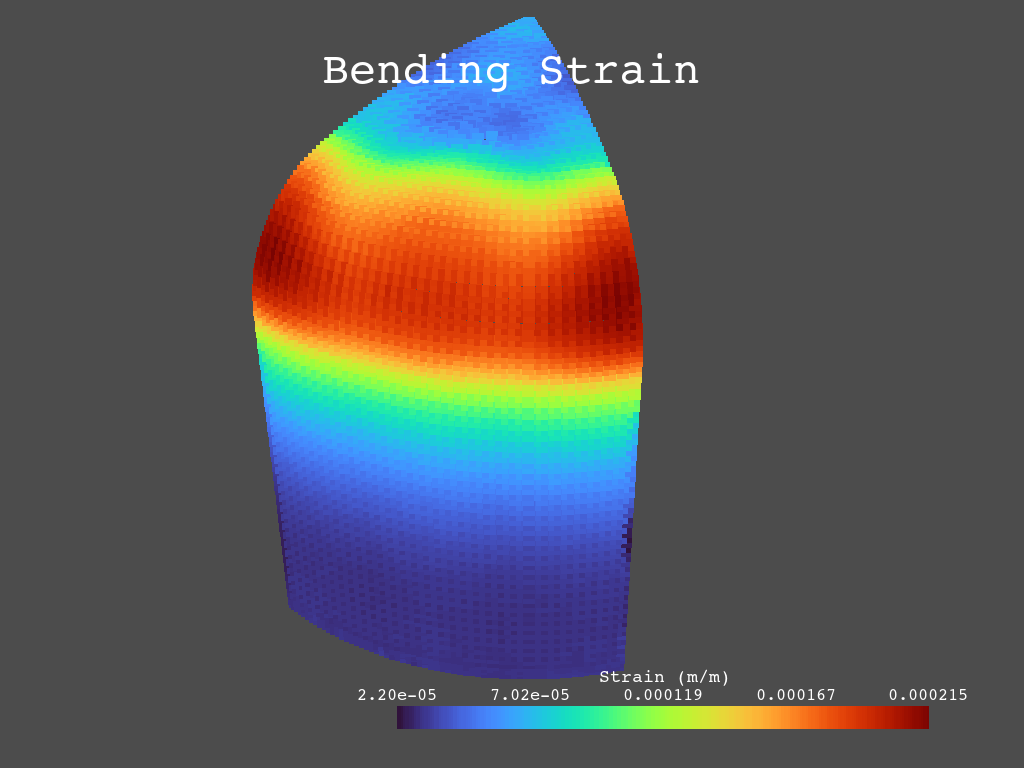

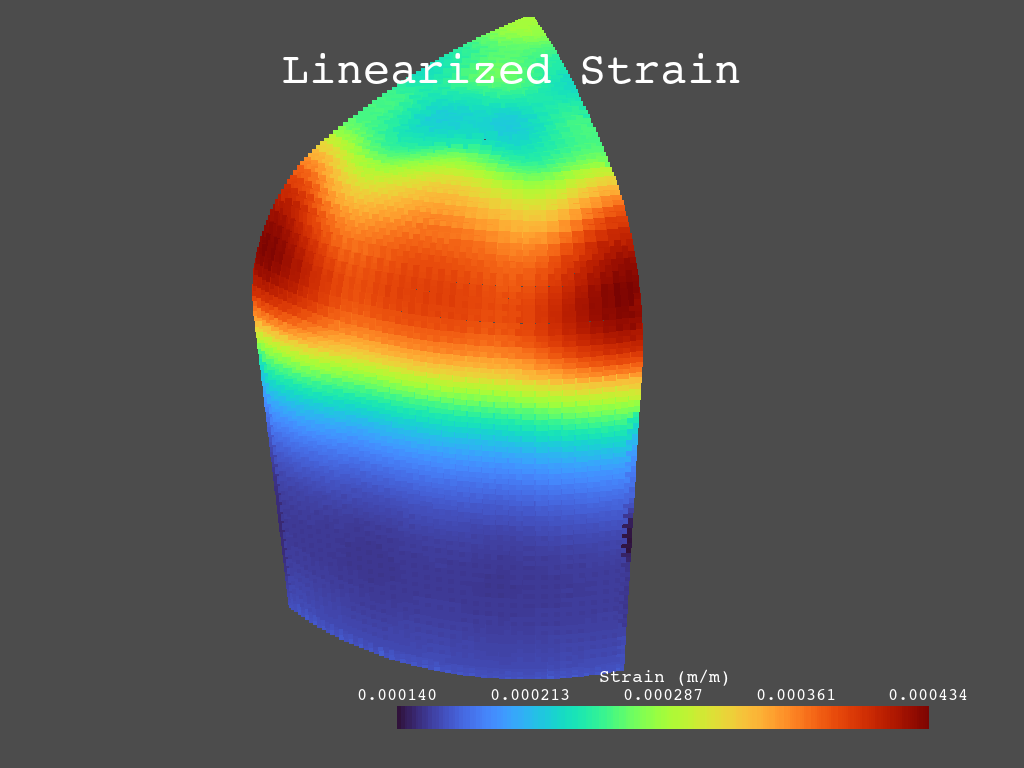

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: nominal


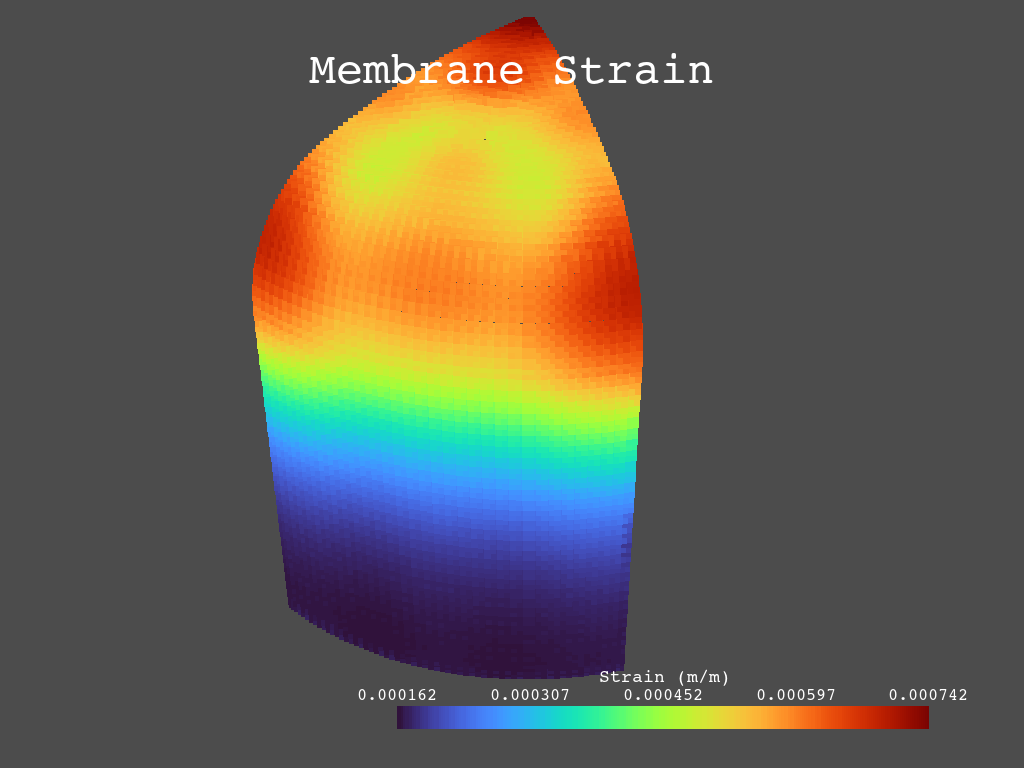

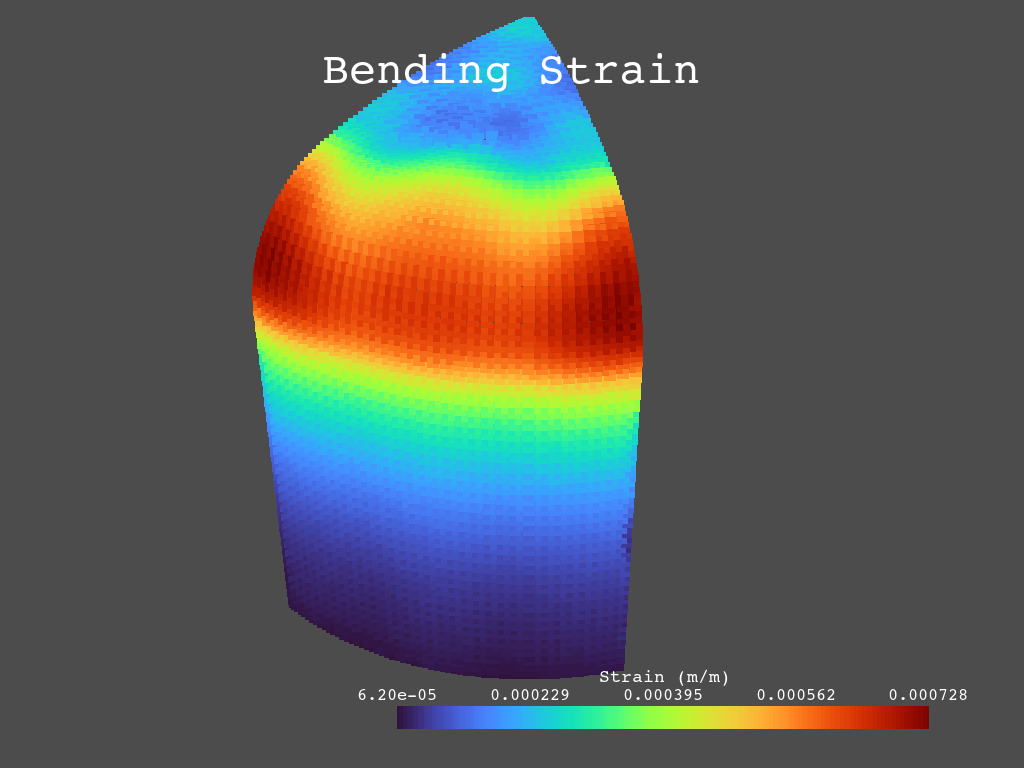

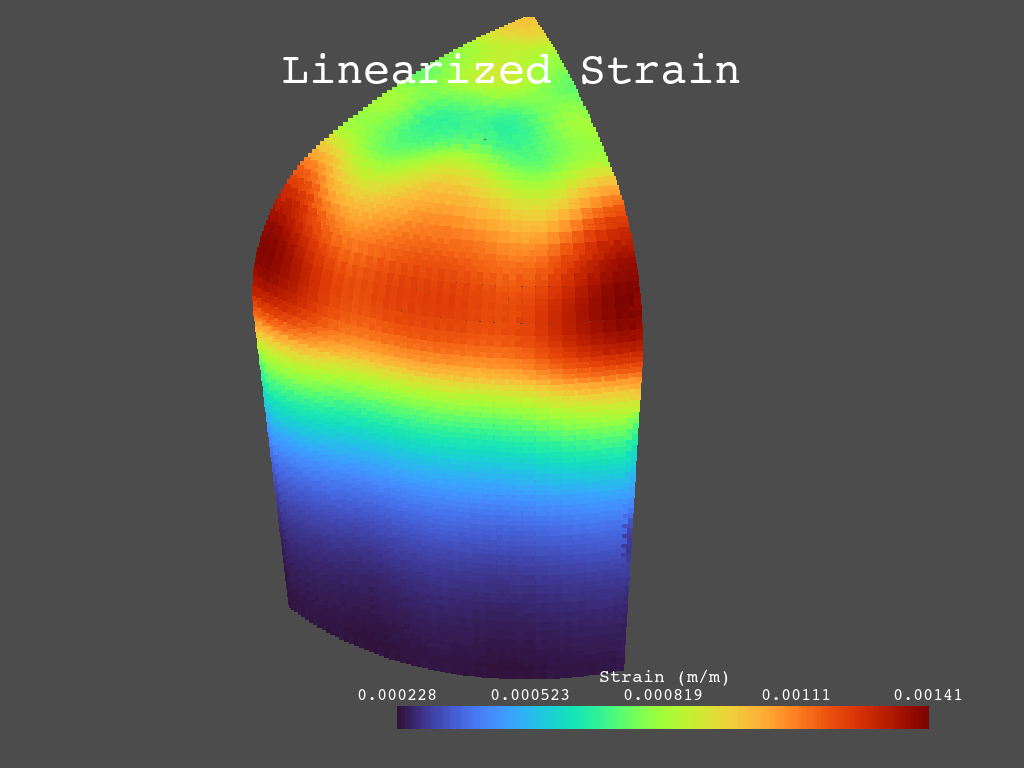

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: high2


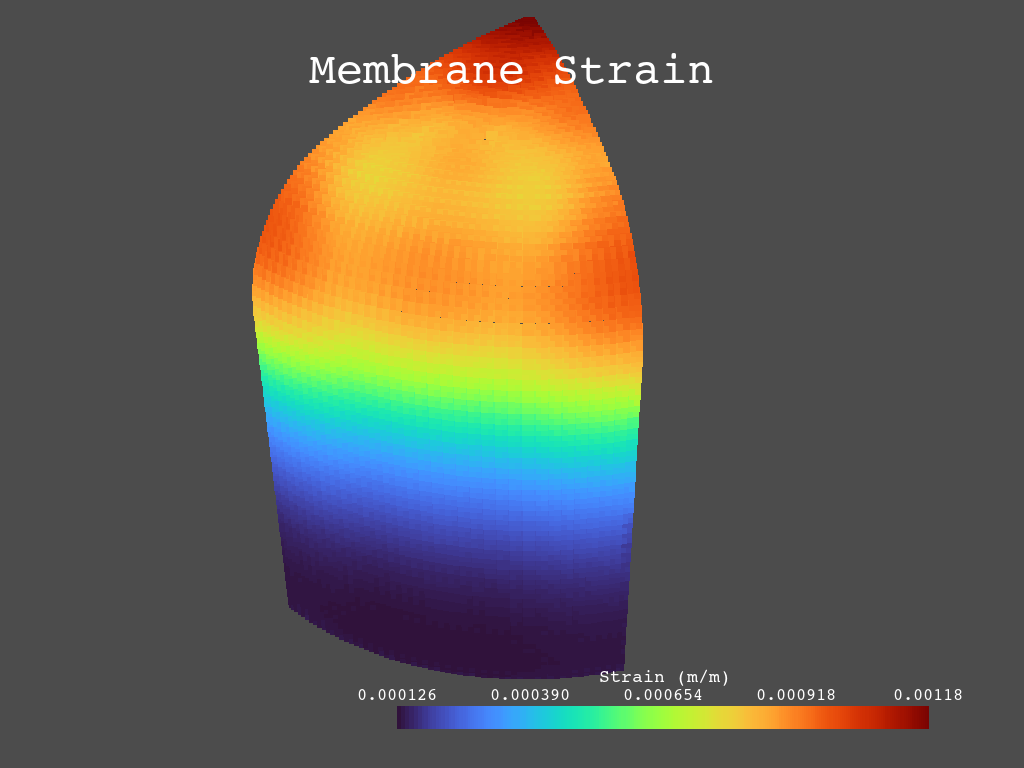

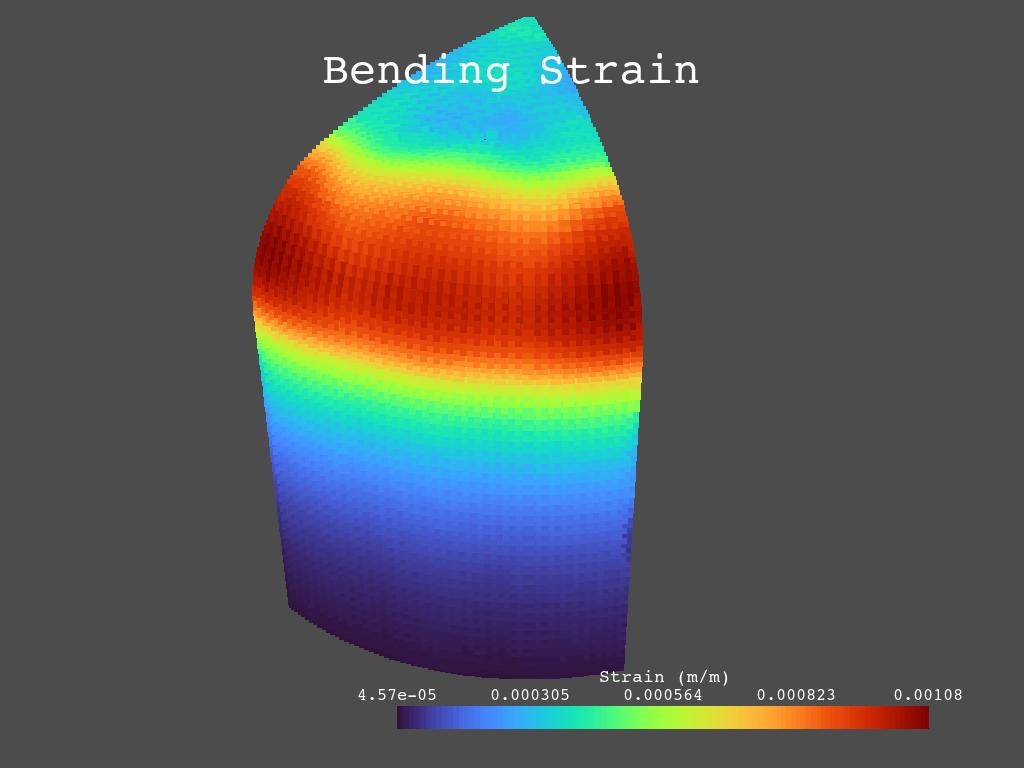

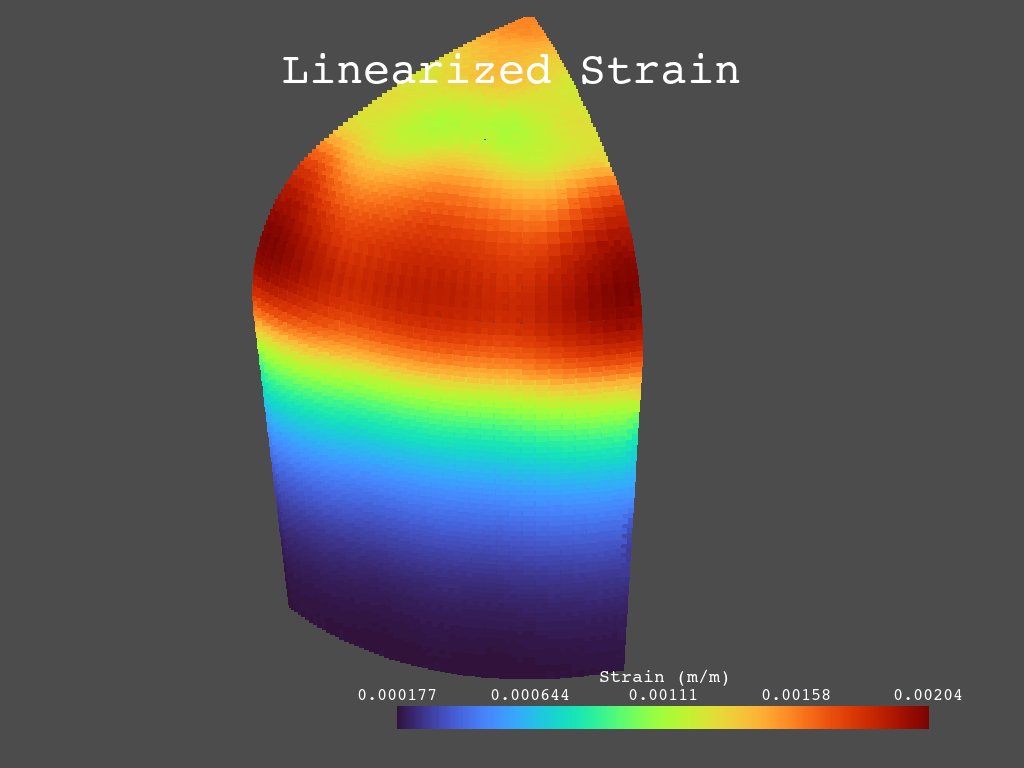

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: high


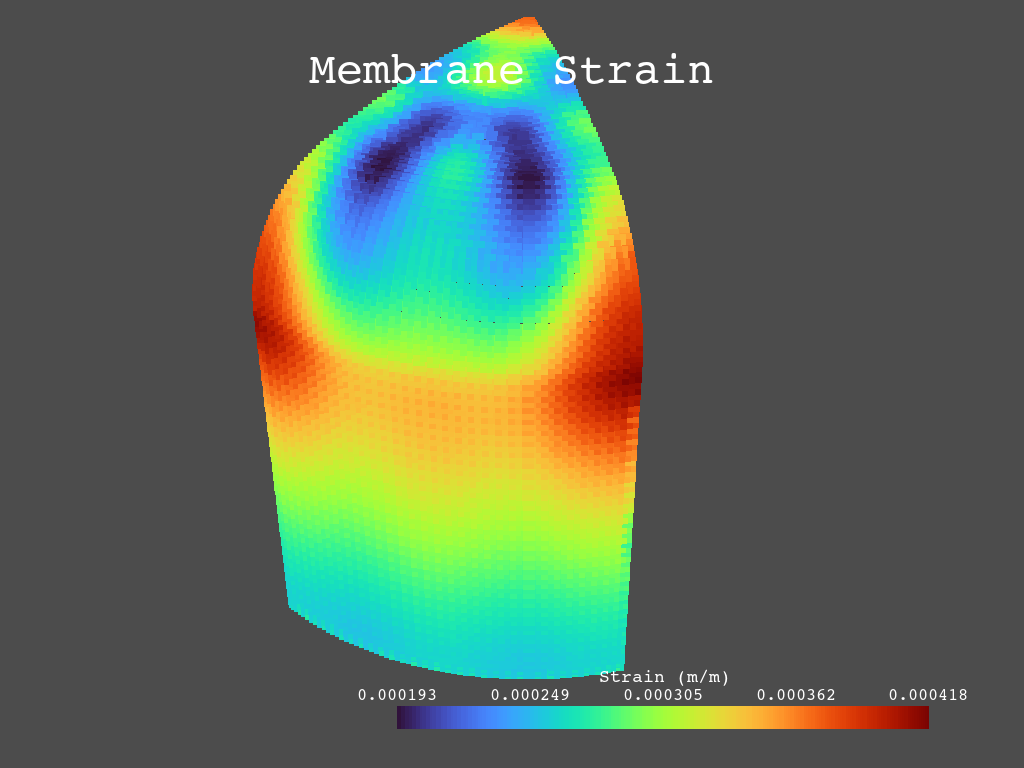

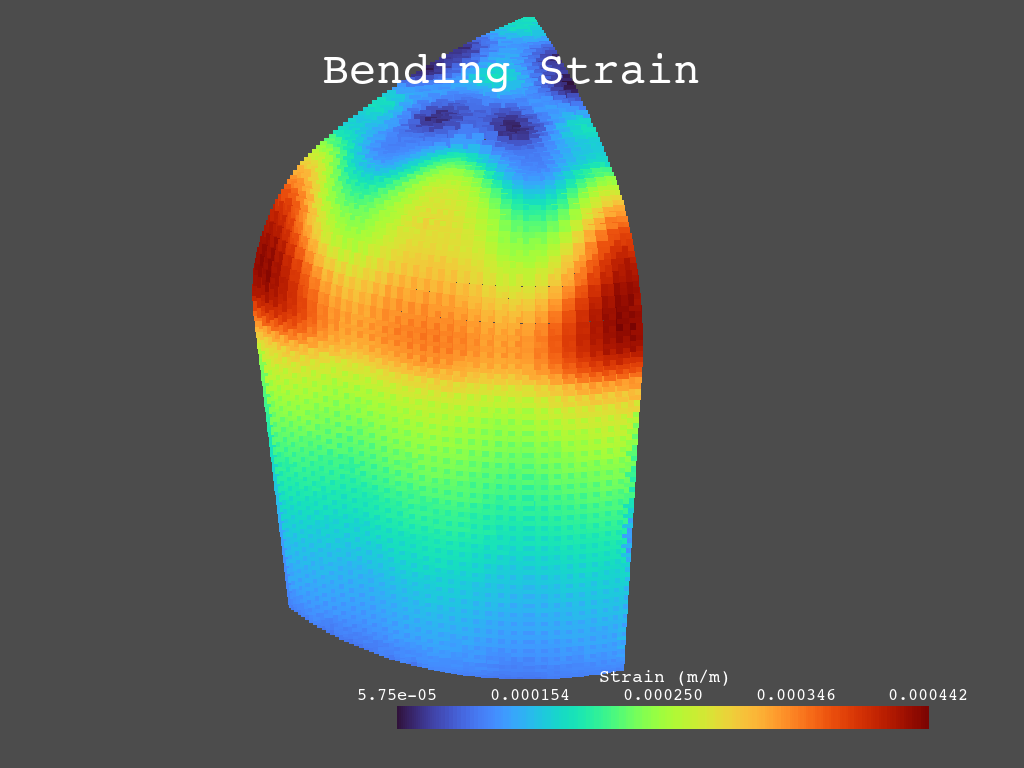

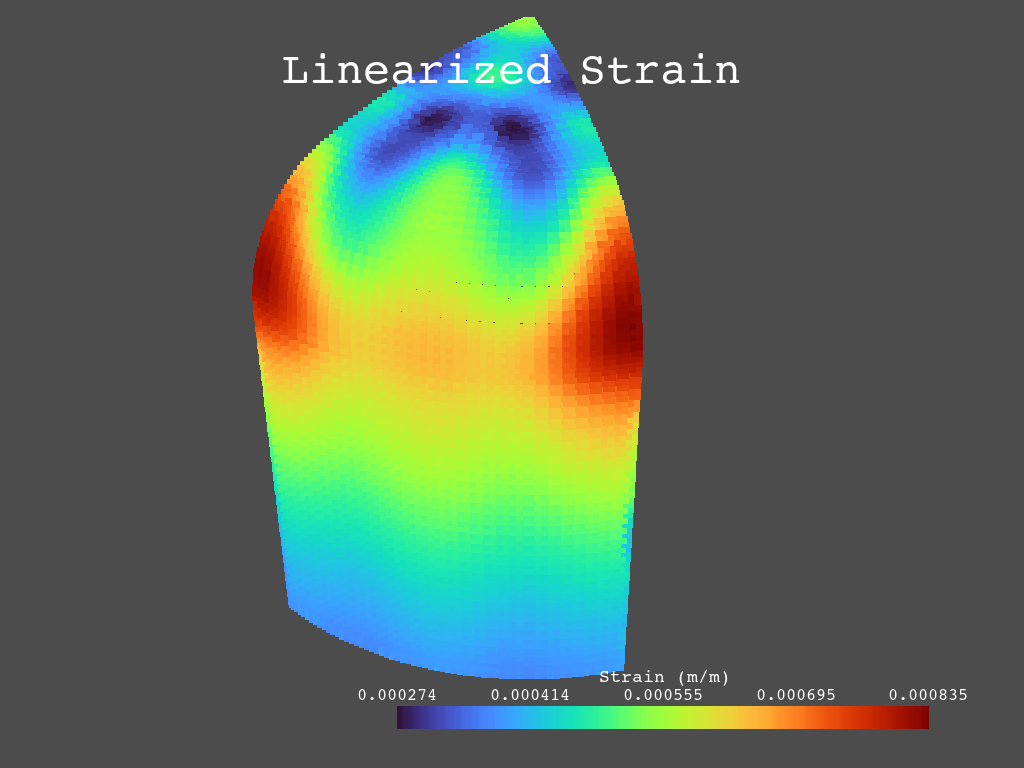

Max Membrane: [0.0002235364840535163, 0.0007423616985629537, 0.001181702444919496, 0.00041792759398694417]
Max Bending: [0.00021507698401056454, 0.0007282223675639279, 0.0010823188920443207, 0.000441881272421291]
Max Linearized: [0.00043421195062903273, 0.0014099868813869793, 0.0020435770428338987, 0.00083541688464357]
____________________________________
Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: low


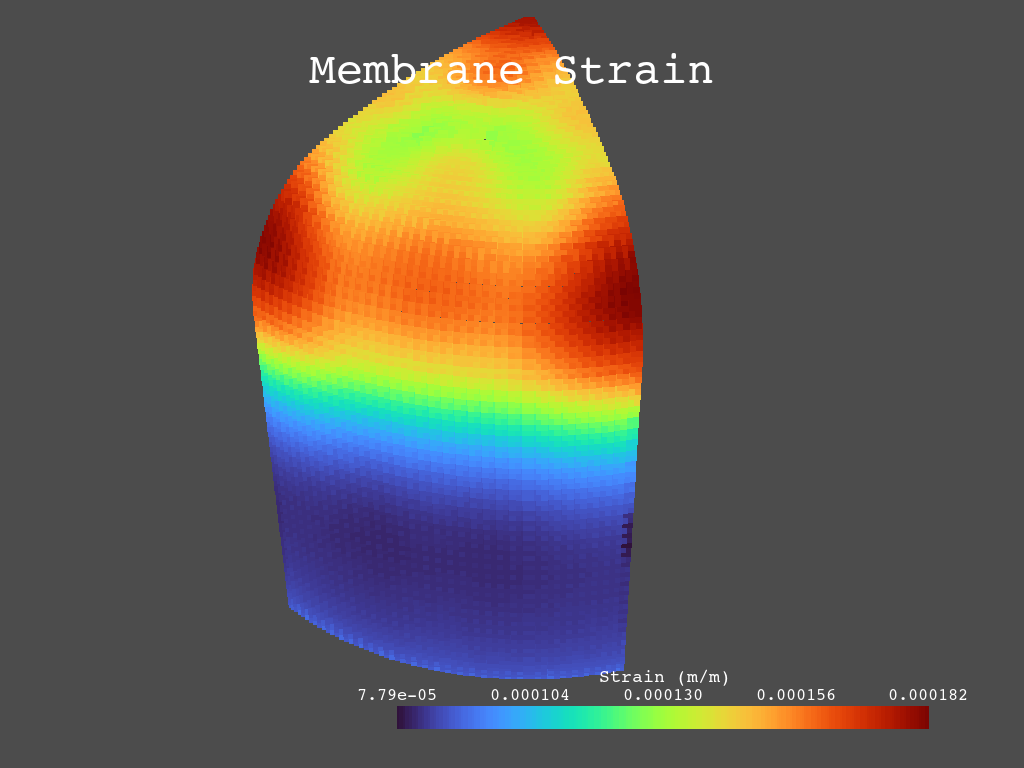

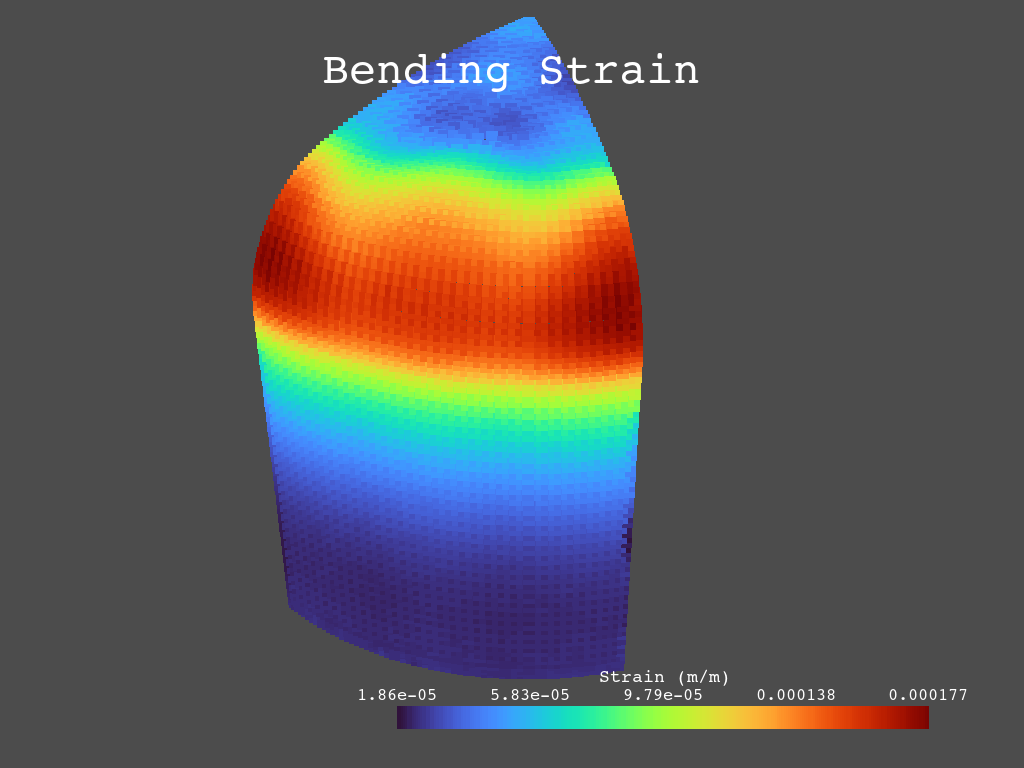

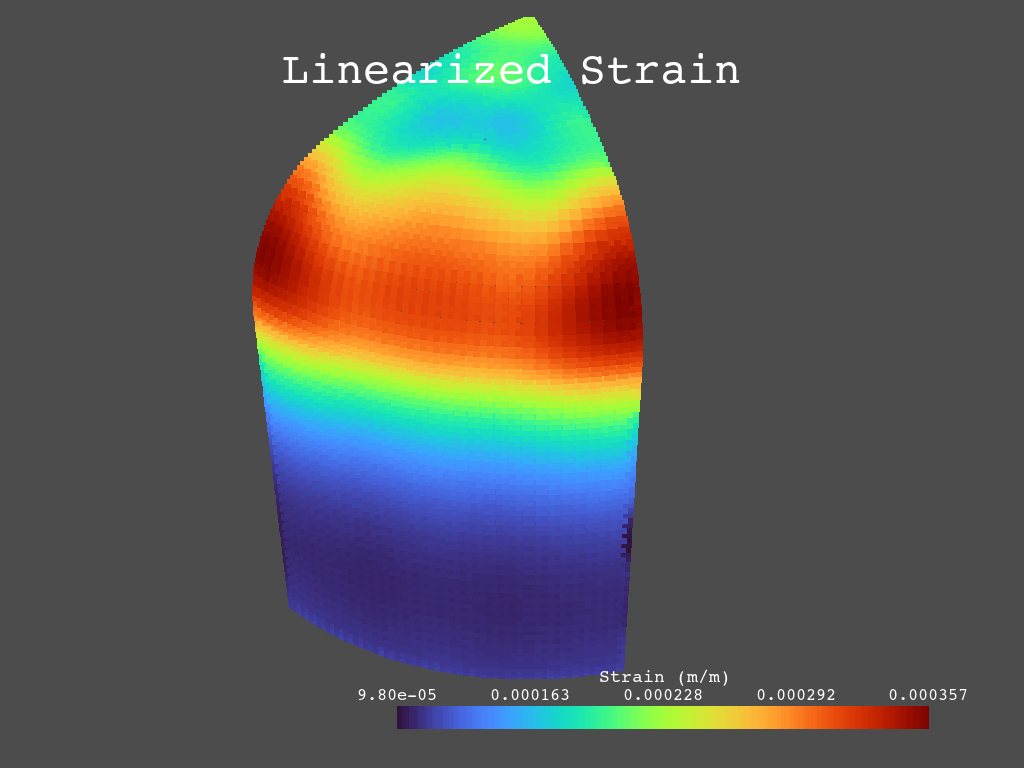

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: nominal


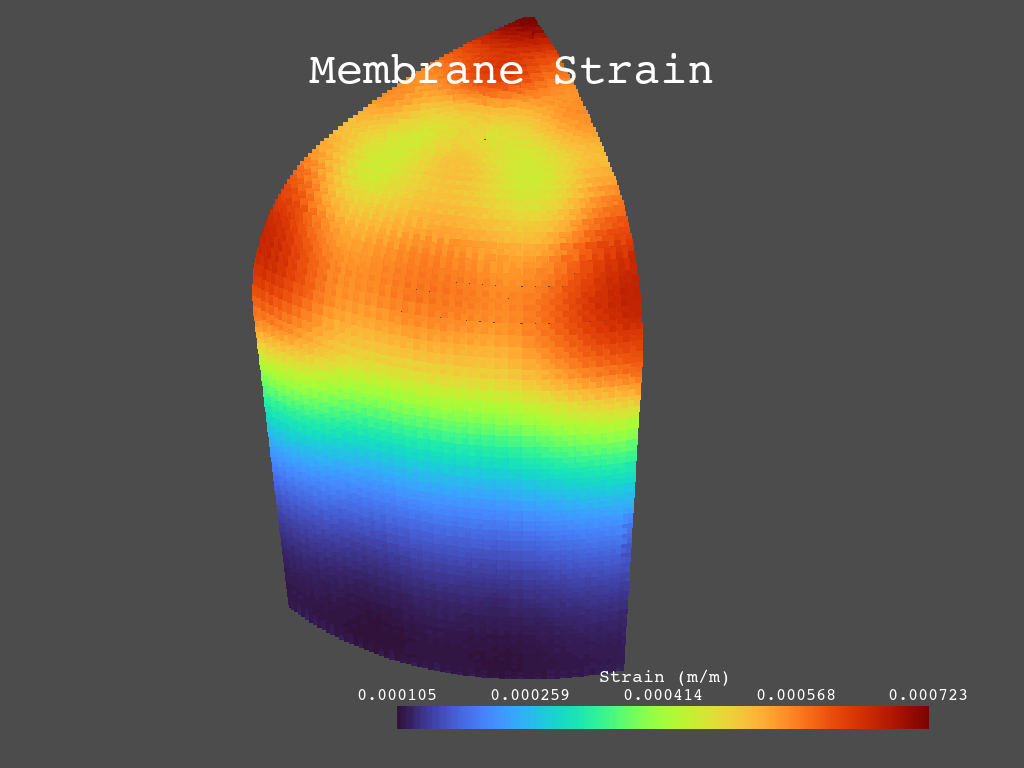

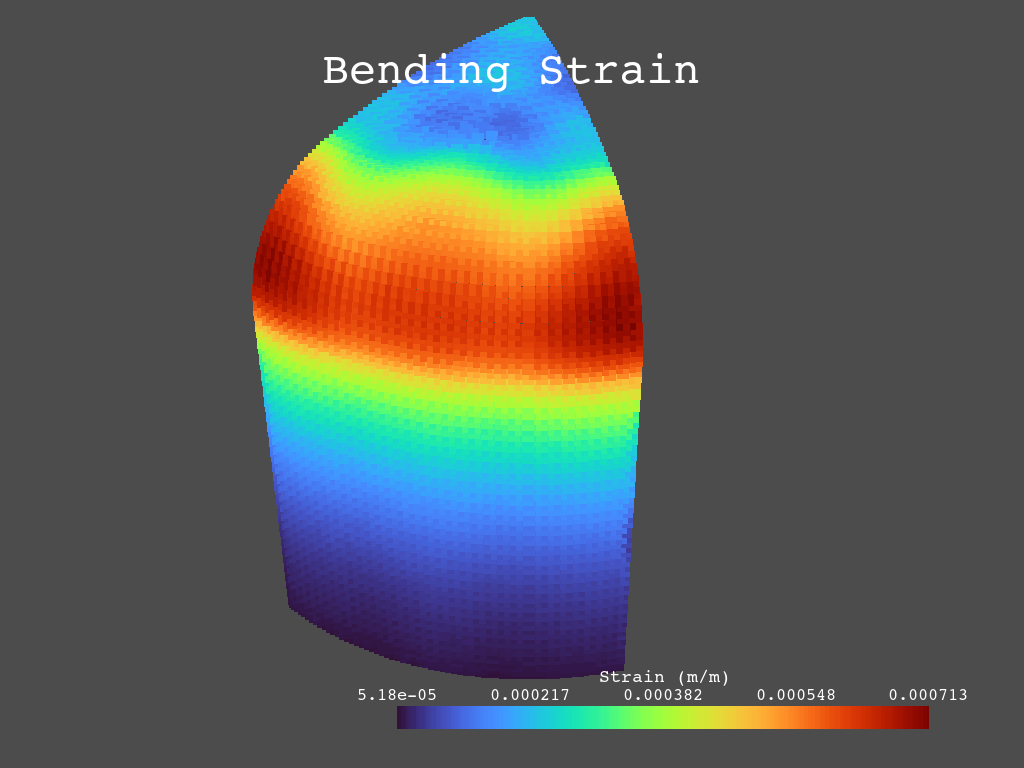

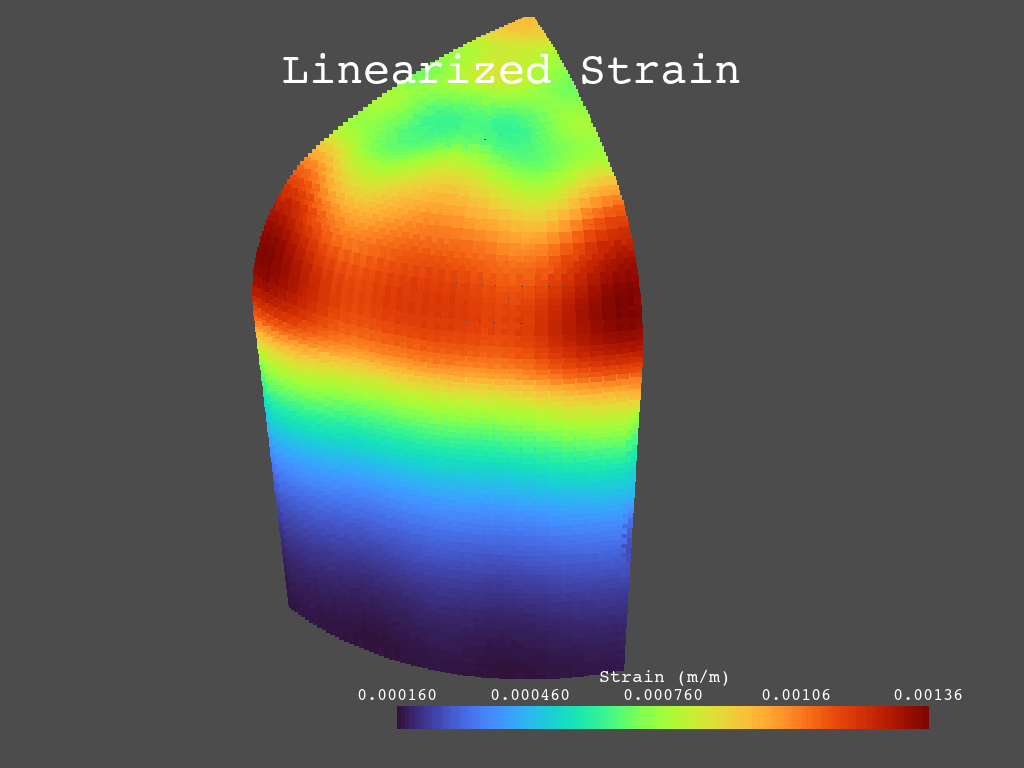

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: high2


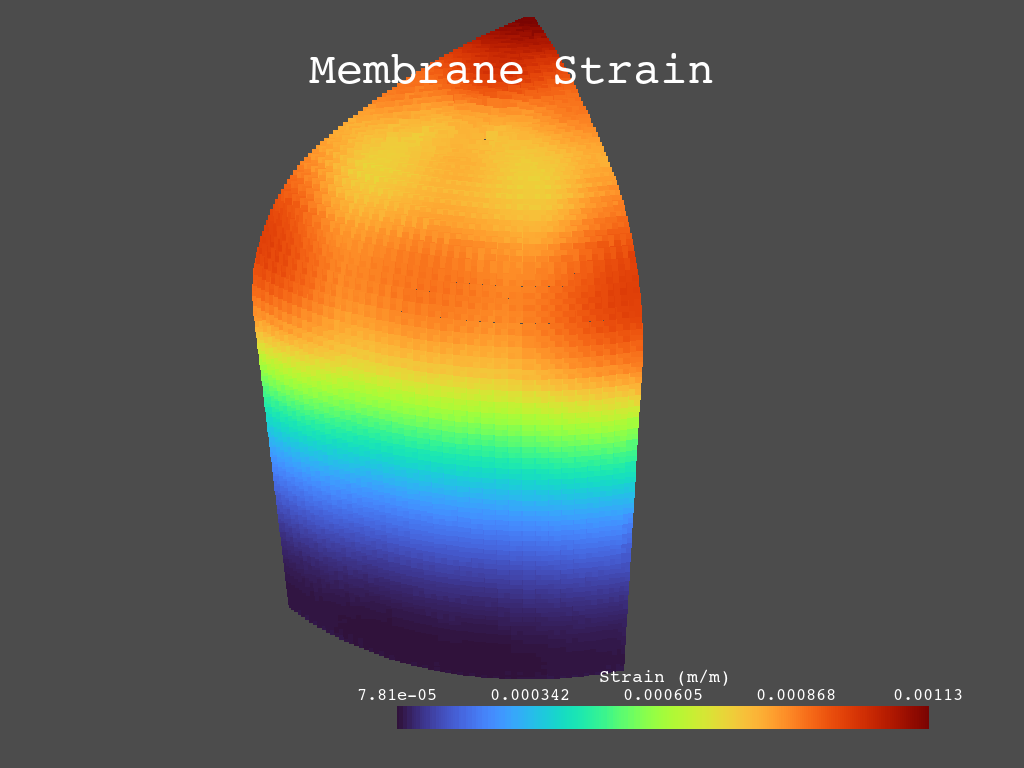

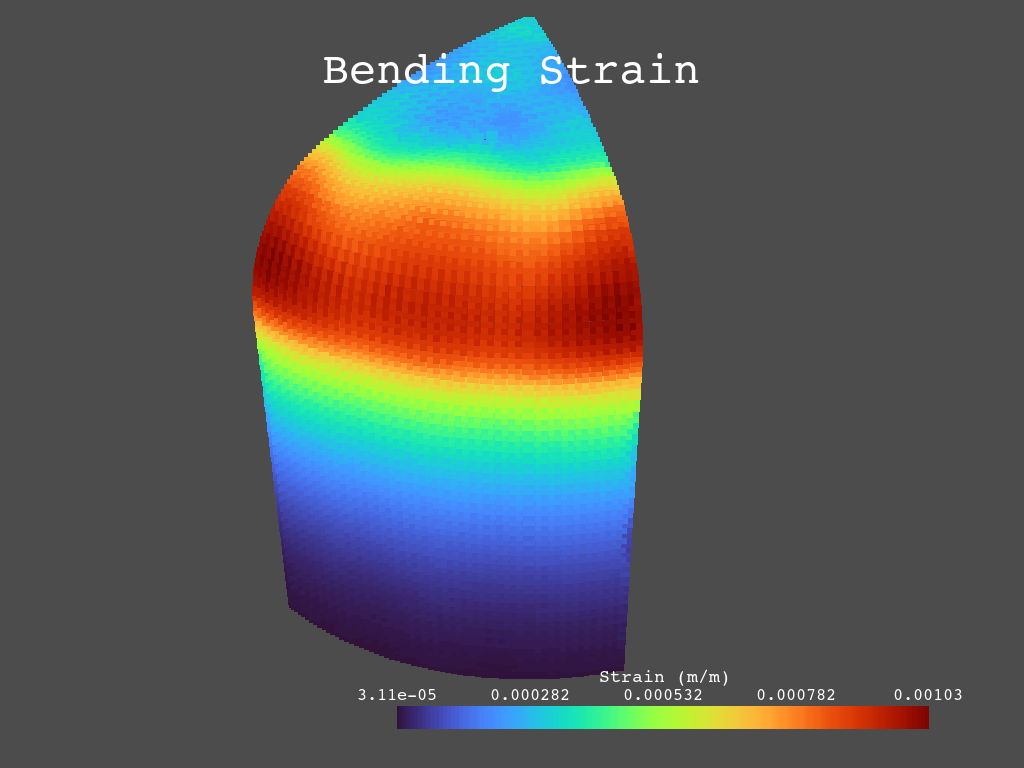

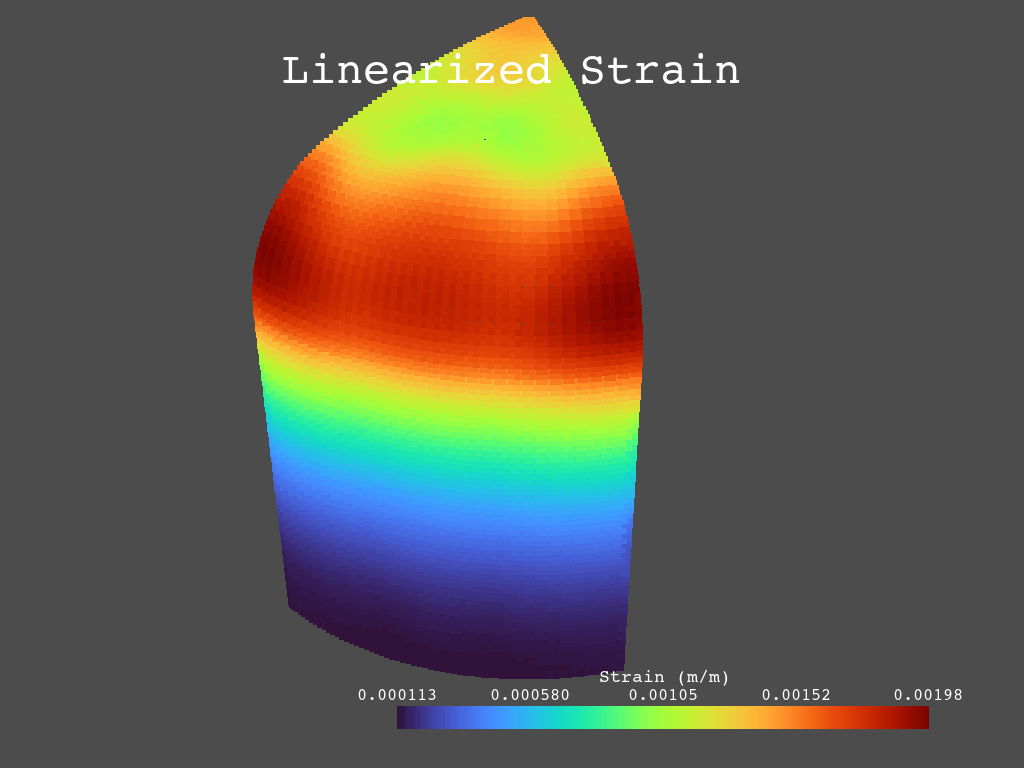

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: high


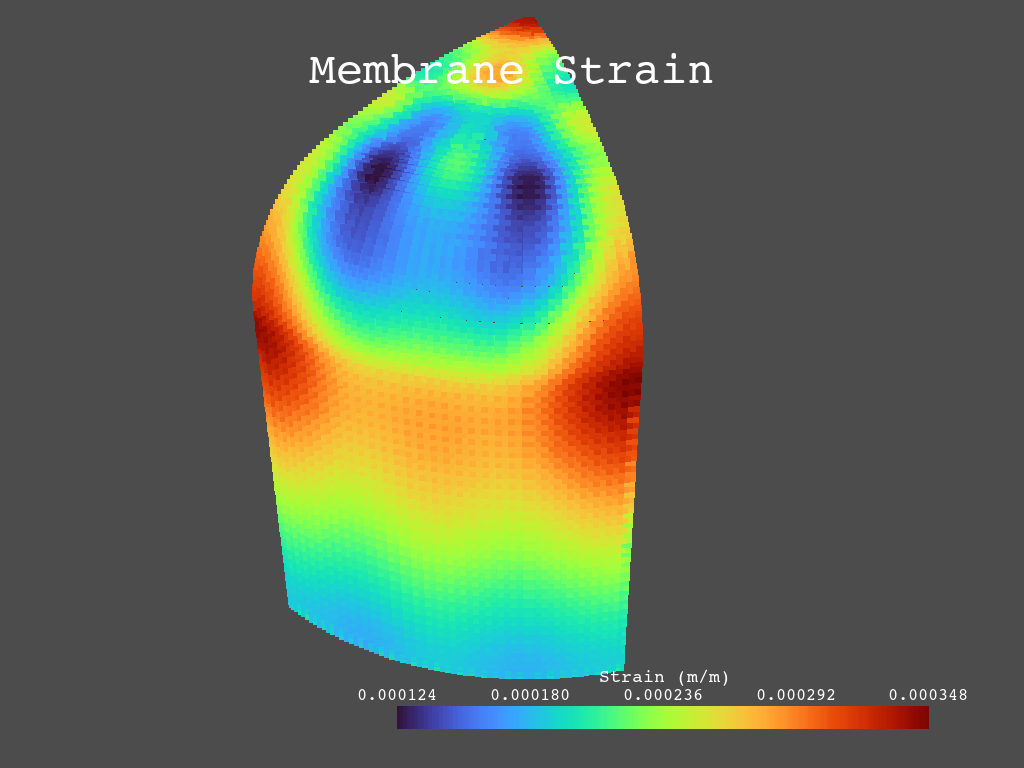

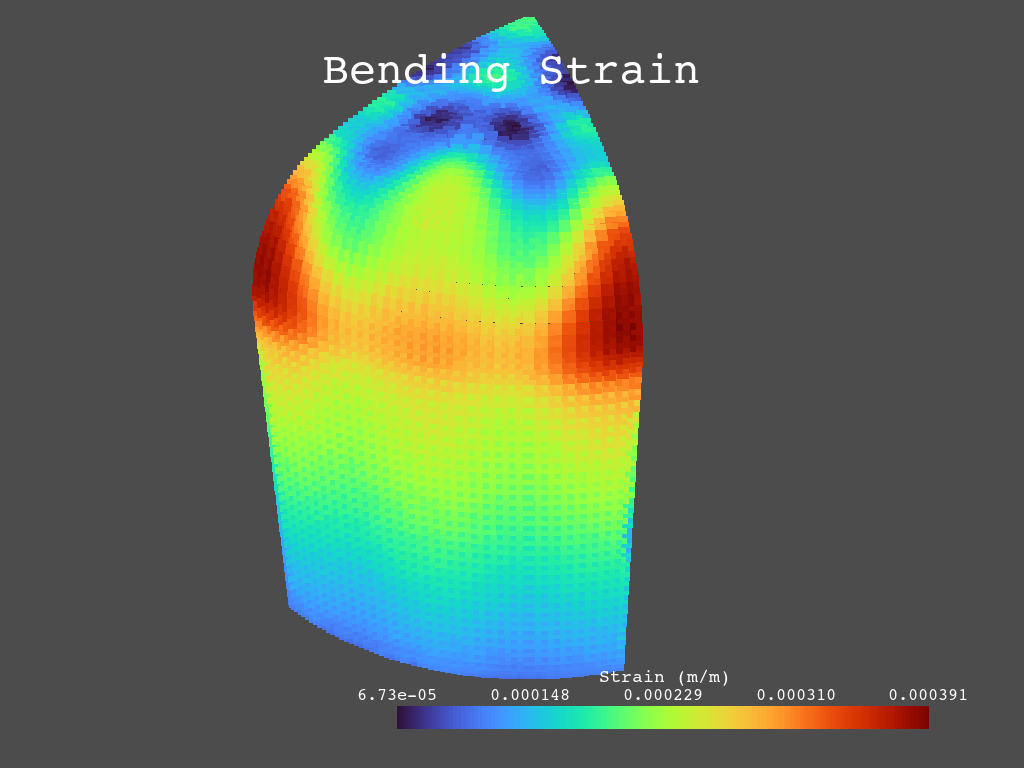

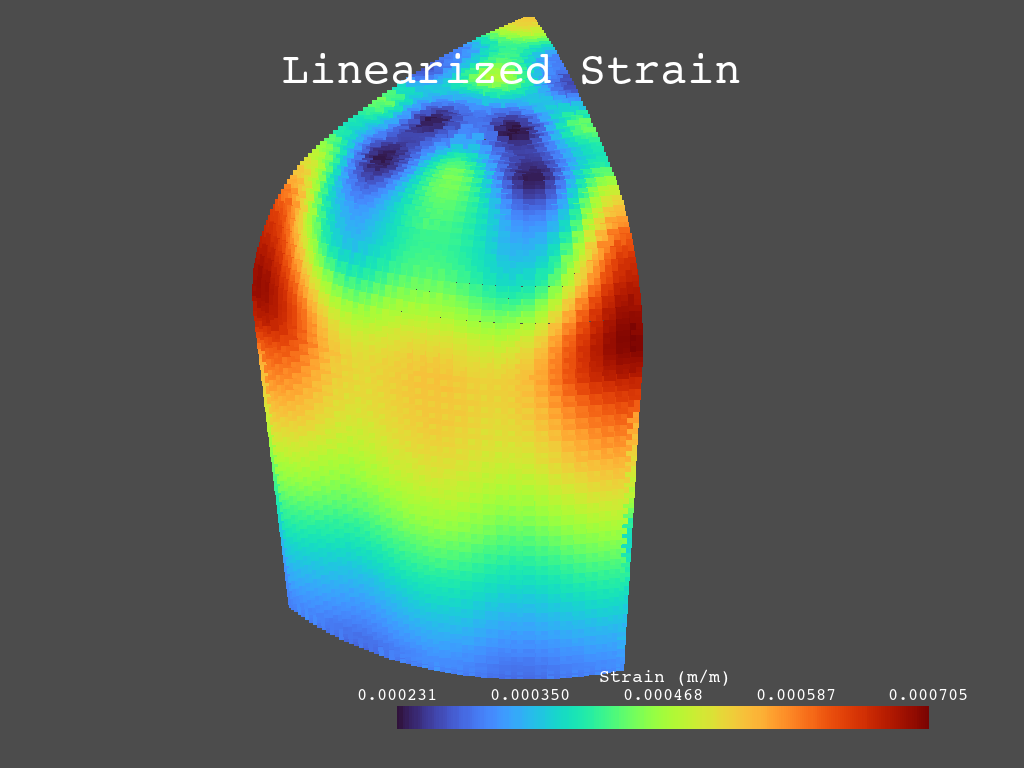

Max Membrane: [0.00018241856241266942, 0.0007229148665116815, 0.0011318311167498644, 0.00034832115926725527]
Max Bending: [0.0001772745737568228, 0.0007128893037372558, 0.0010326868955151398, 0.00039101704830095787]
Max Linearized: [0.00035709067464625576, 0.0013612407280176148, 0.0019838661887205916, 0.0007052152798180291]
____________________________________
Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: low


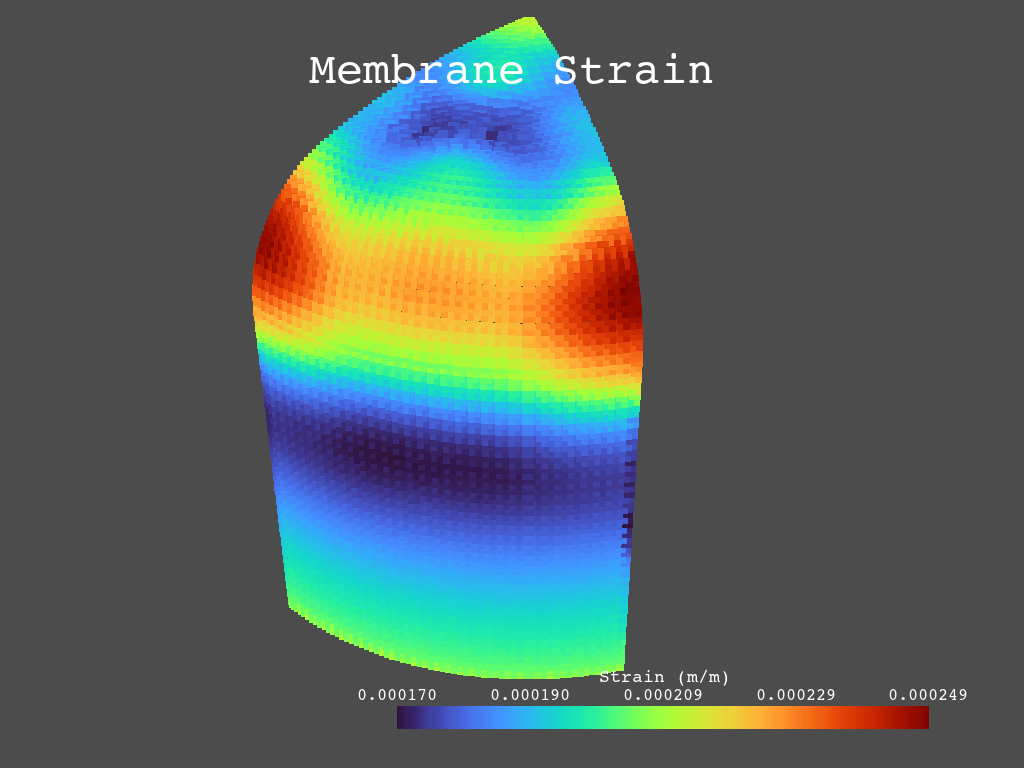

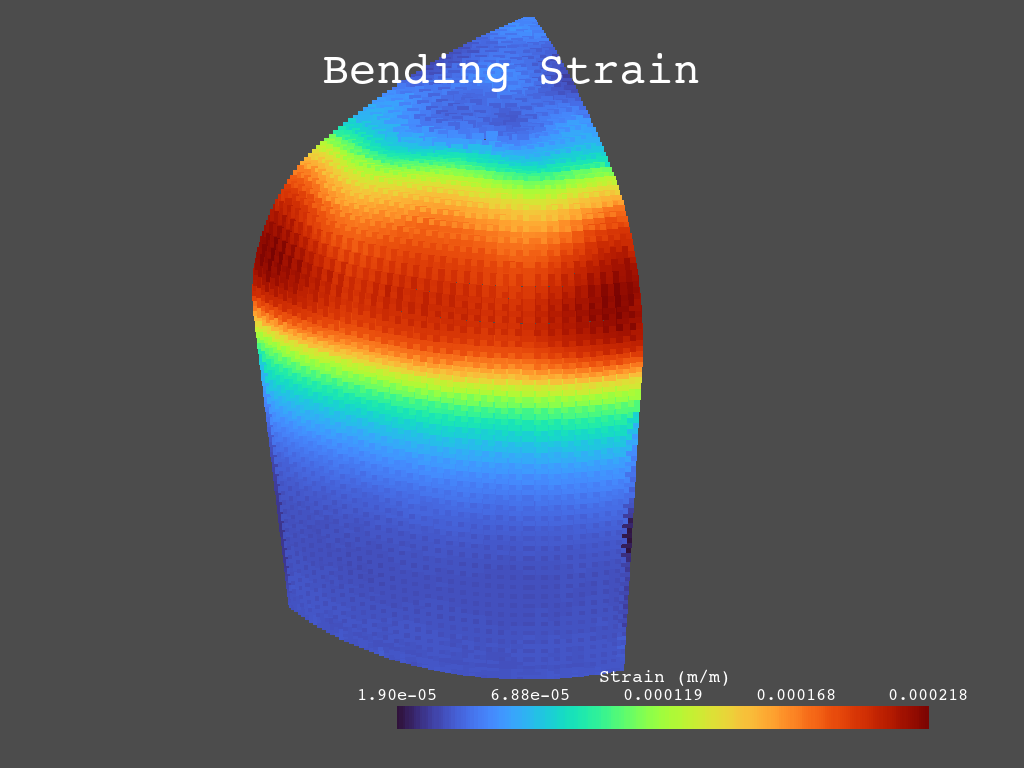

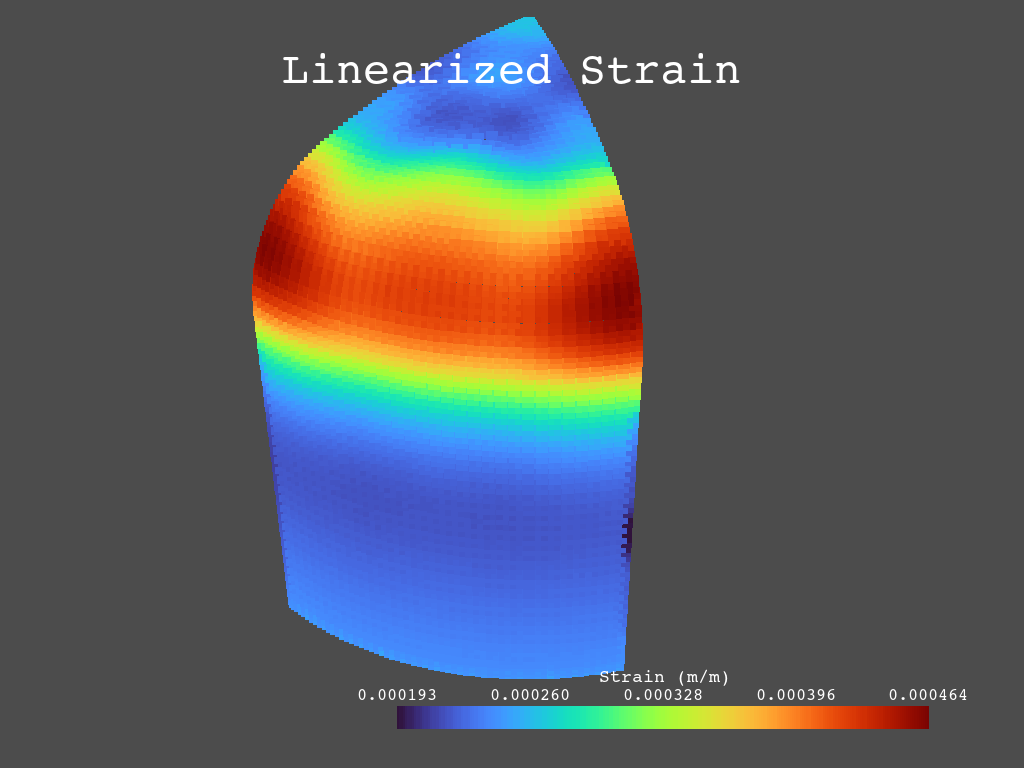

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: nominal


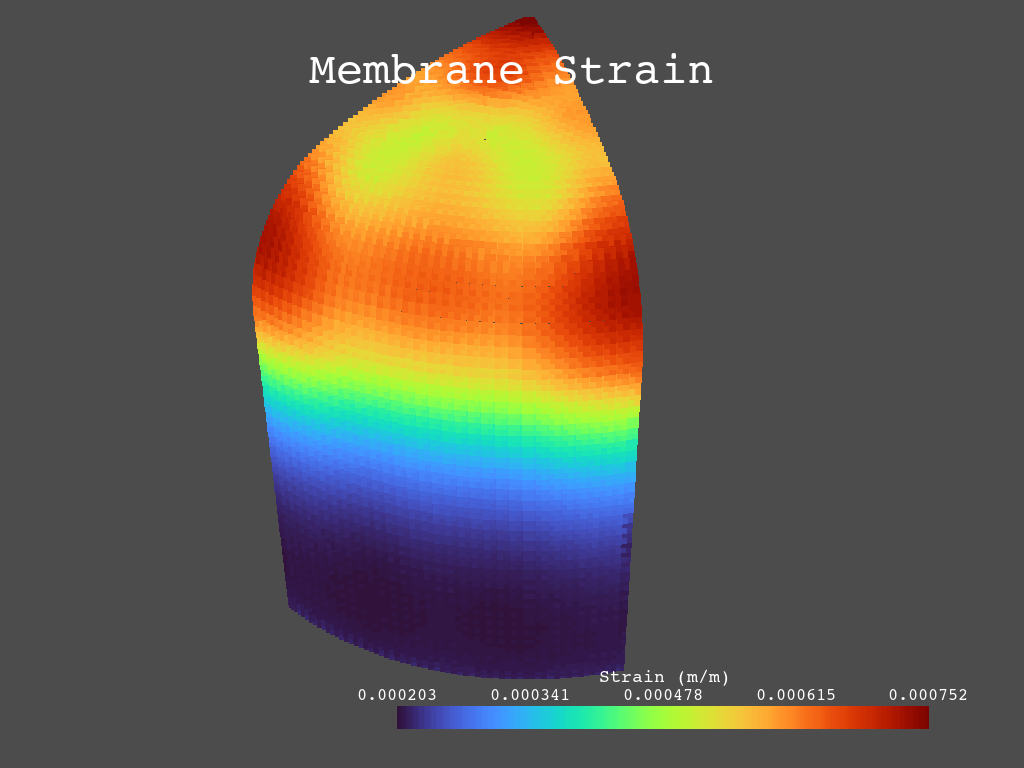

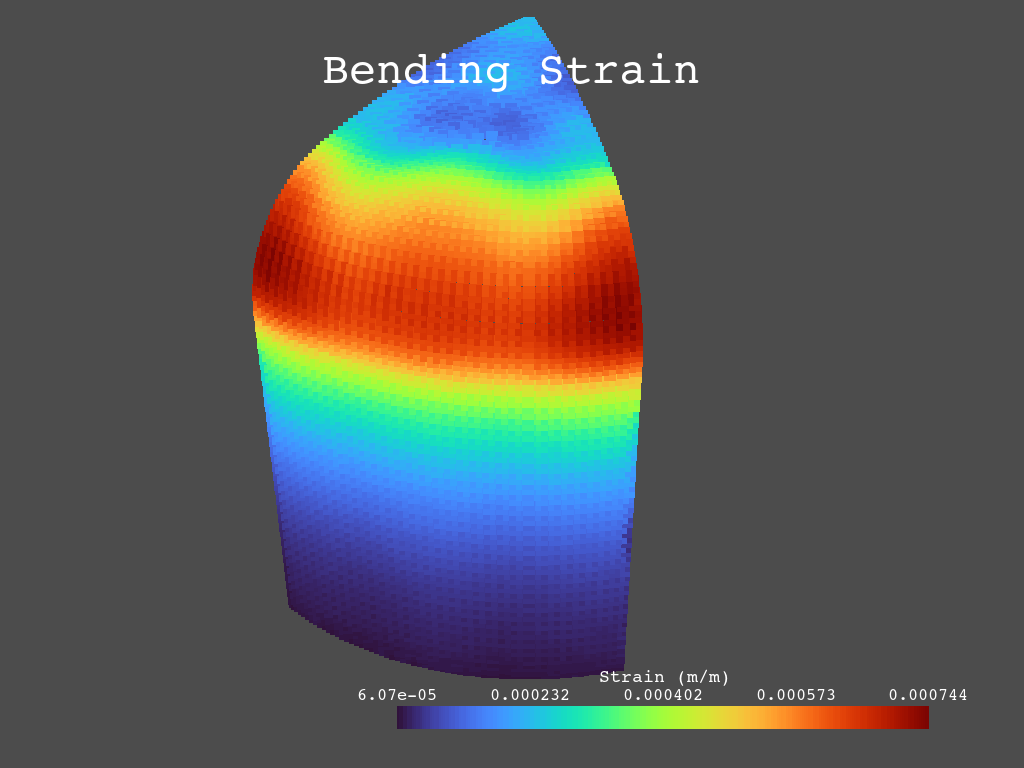

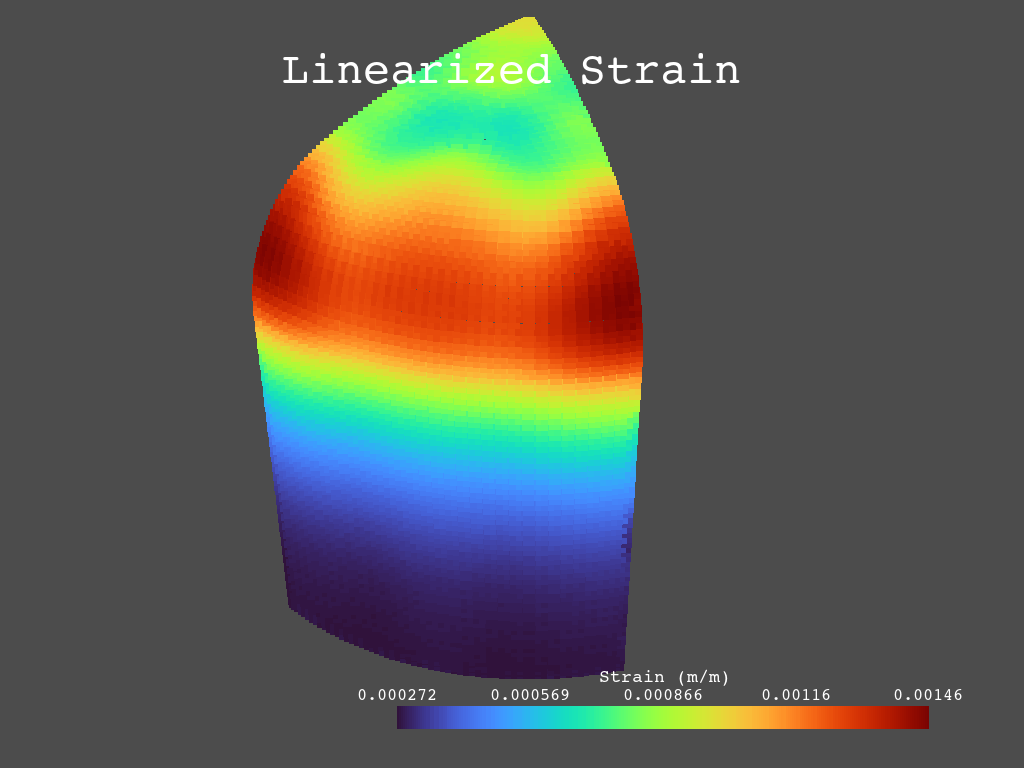

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: high2


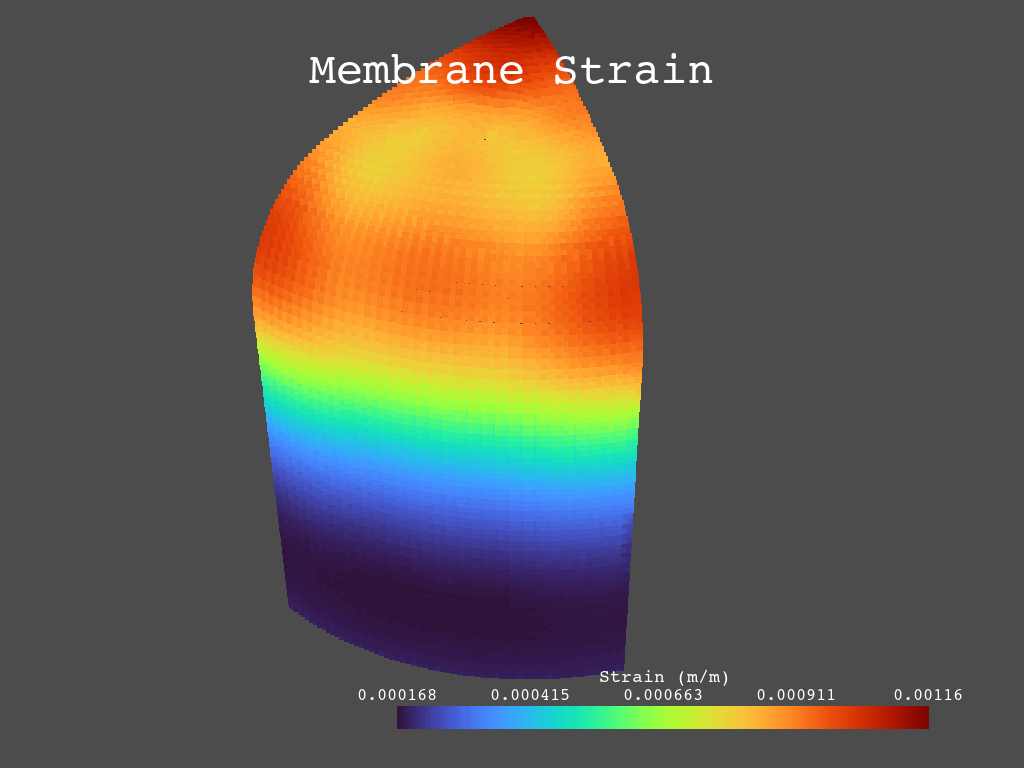

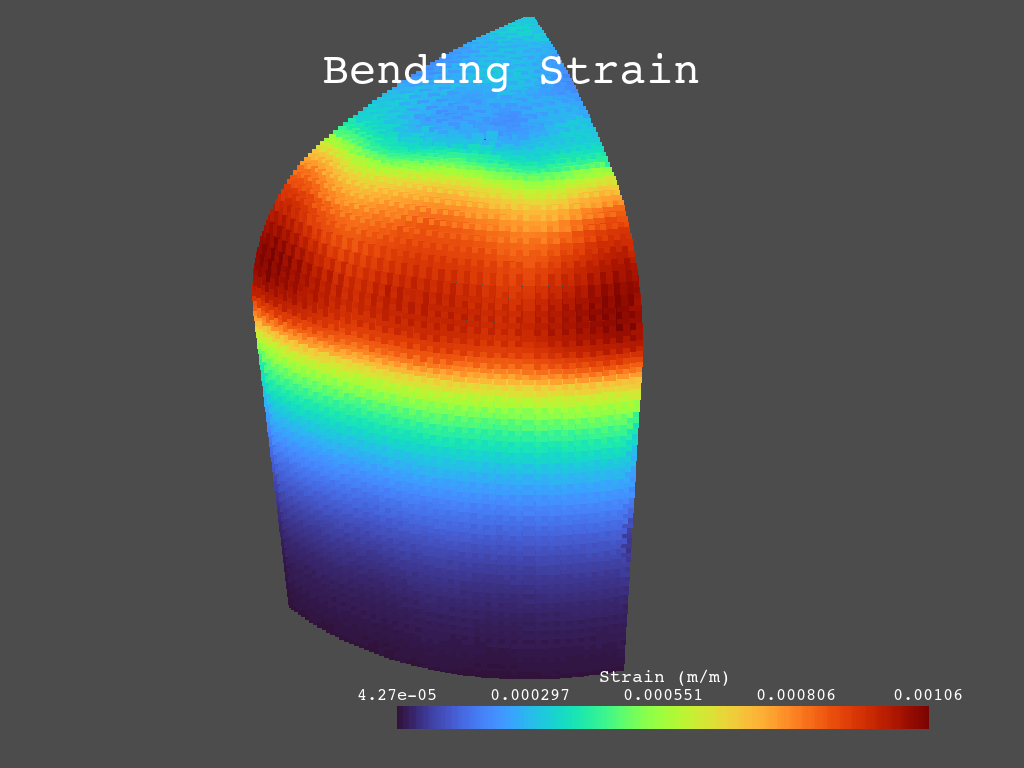

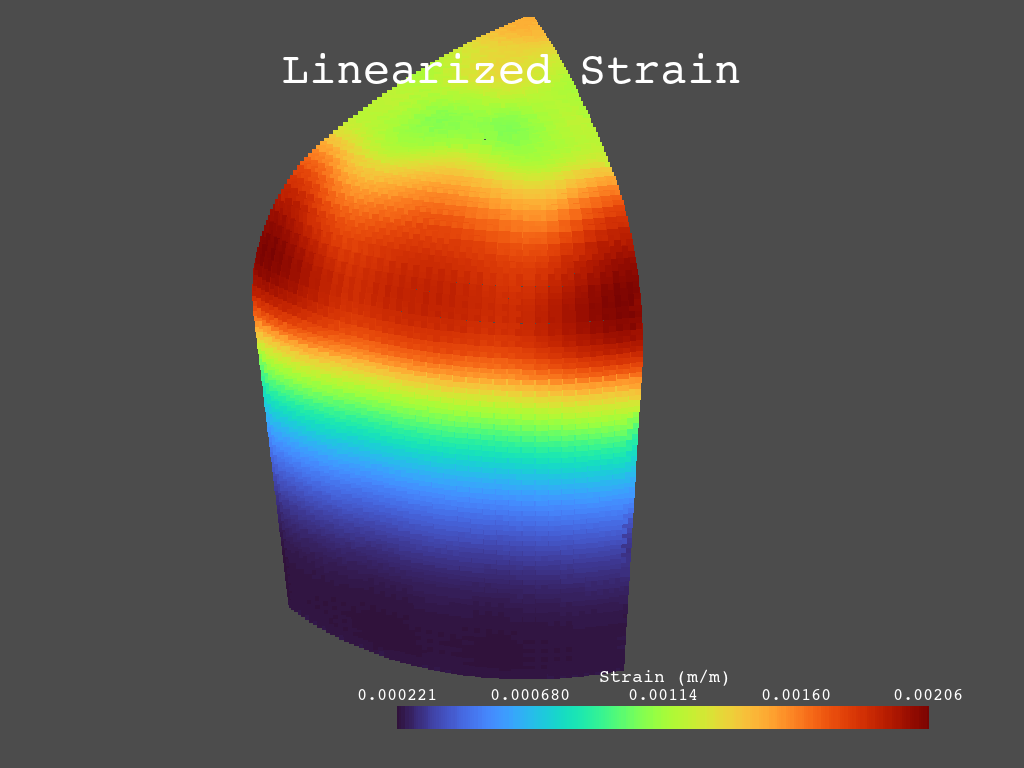

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: high


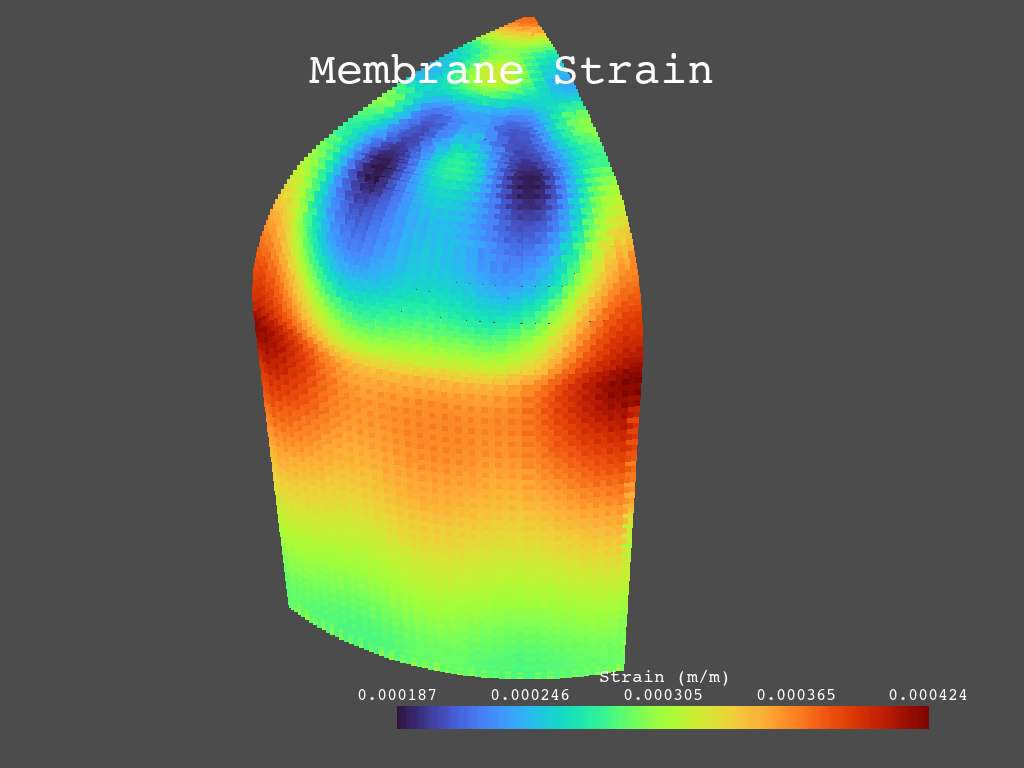

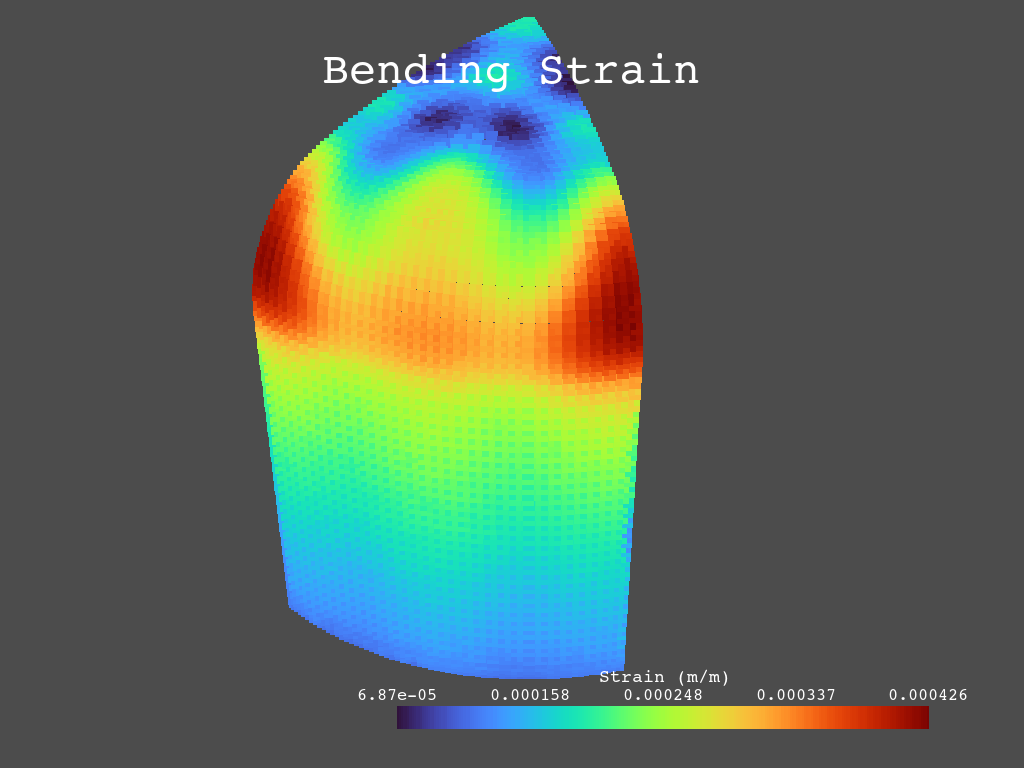

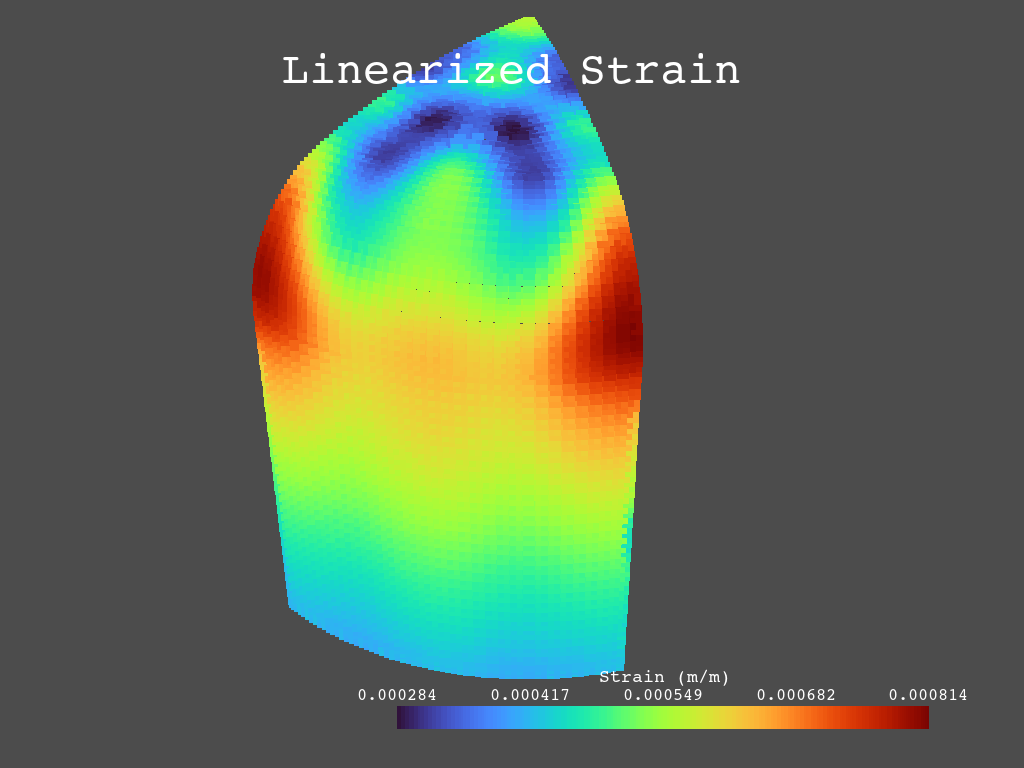

Max Membrane: [0.0002490689438024835, 0.0007524086397840643, 0.0011588698274631645, 0.00042389820194987937]
Max Bending: [0.00021830327399364972, 0.0007440346148130073, 0.0010599848122603934, 0.00042644684864803485]
Max Linearized: [0.0004640596834879423, 0.0014595318072554227, 0.0020587249519764756, 0.0008141344913568419]
____________________________________
Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: low


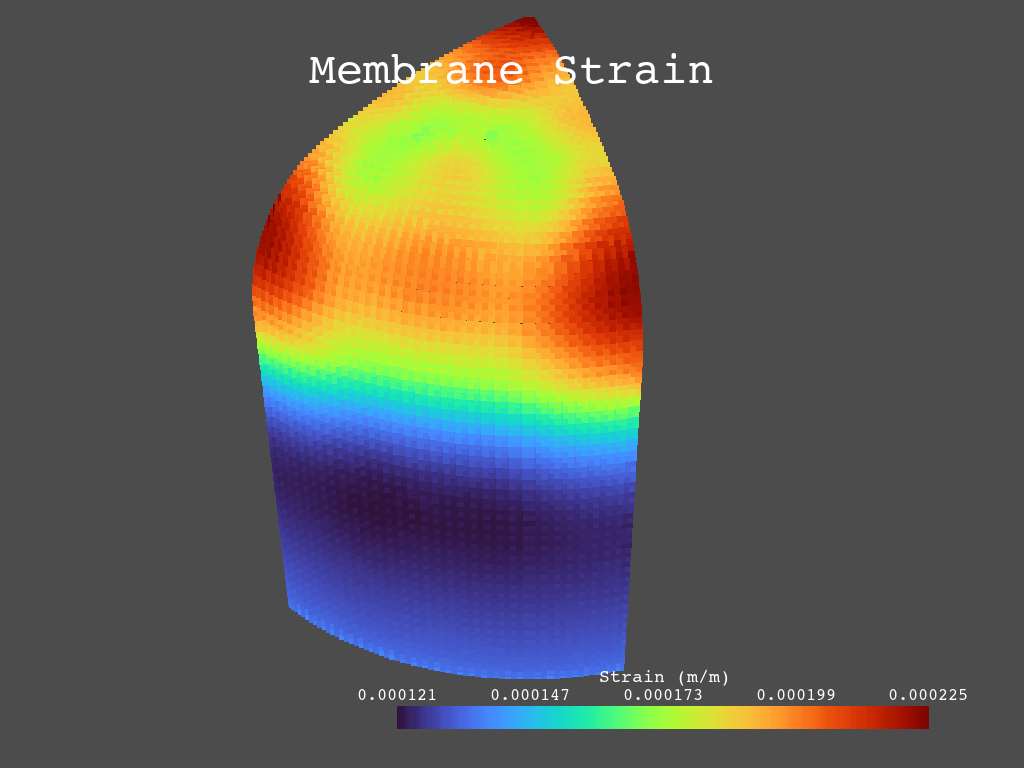

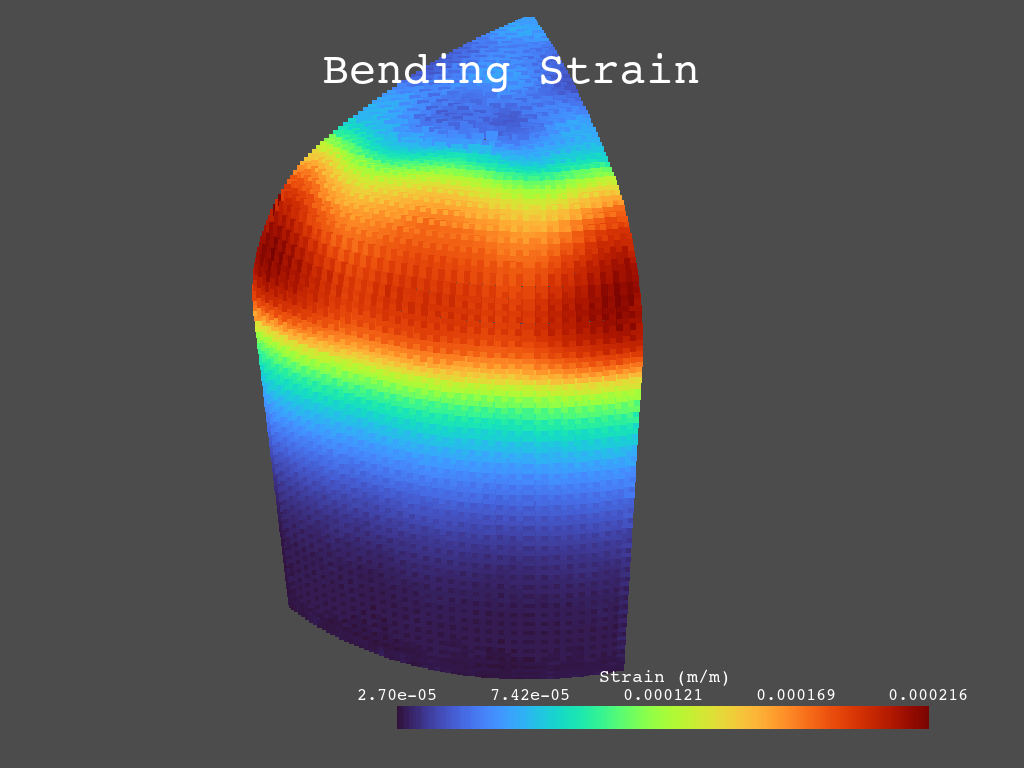

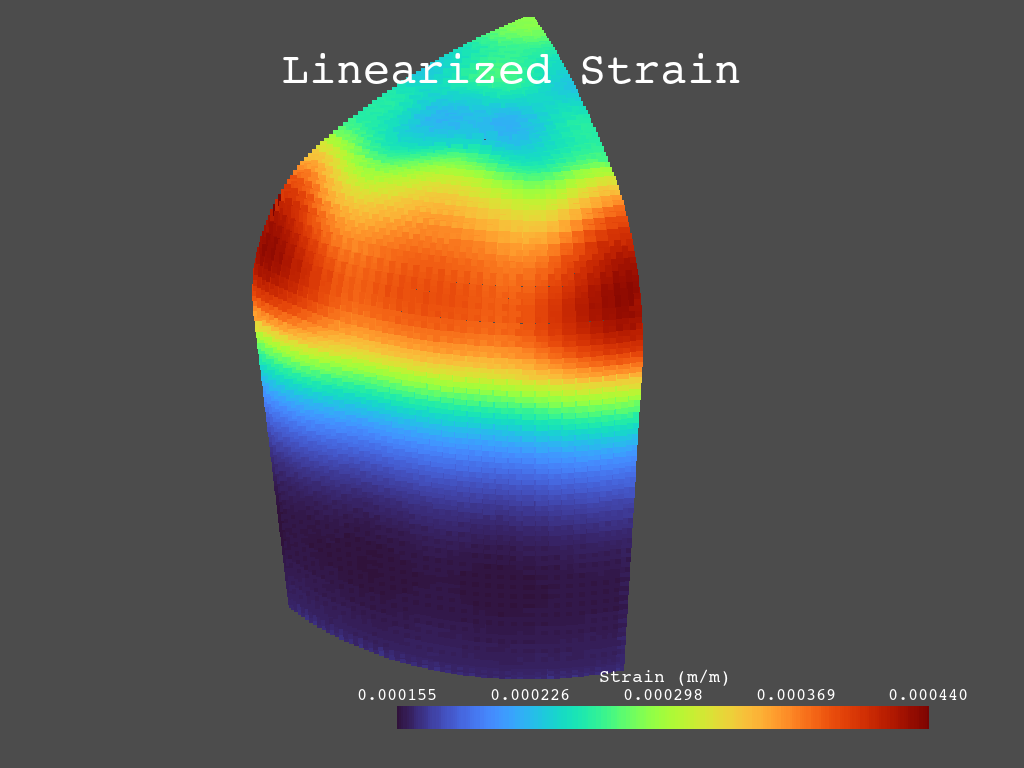

MemoryError: Unable to allocate 226. MiB for an array with shape (5448, 5448) and data type float64

In [21]:
strain_membrane, strain_bending, strain_linearized = plot_linearization(False)

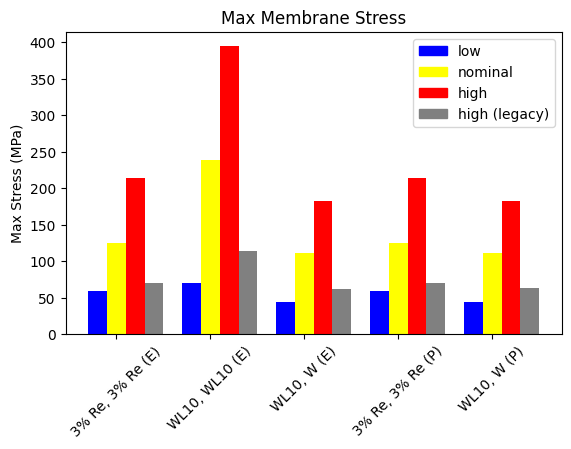

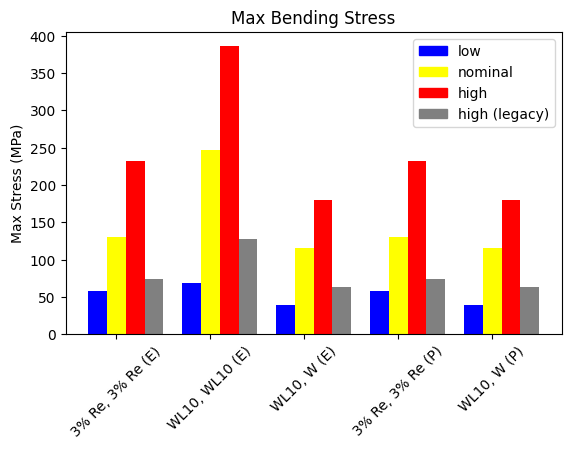

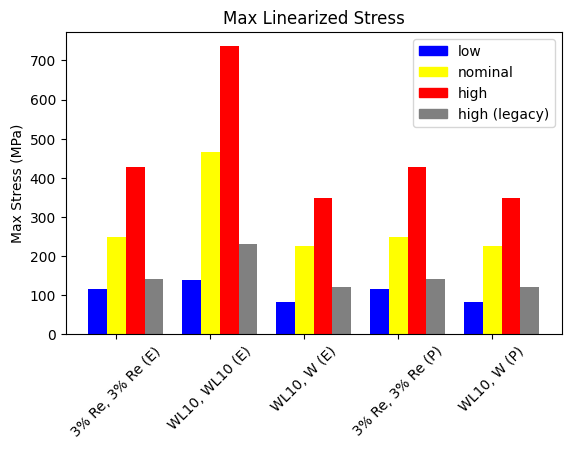

In [22]:
plot_bar_graph(stress_membrane, "Max Membrane Stress")
plot_bar_graph(stress_bending, "Max Bending Stress")
plot_bar_graph(stress_linearized, "Max Linearized Stress")

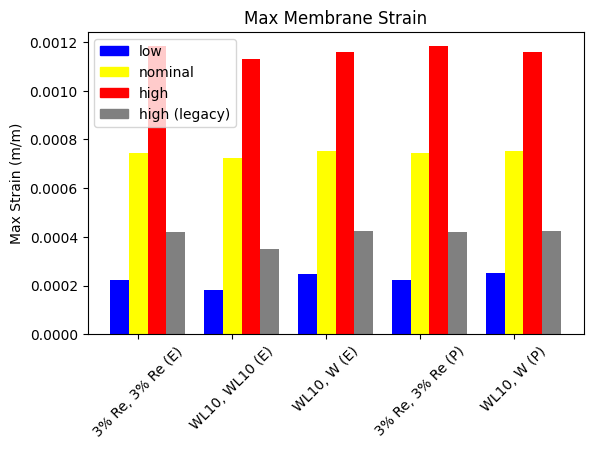

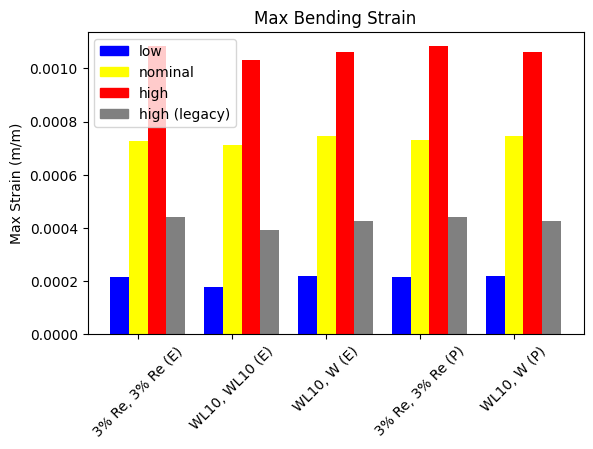

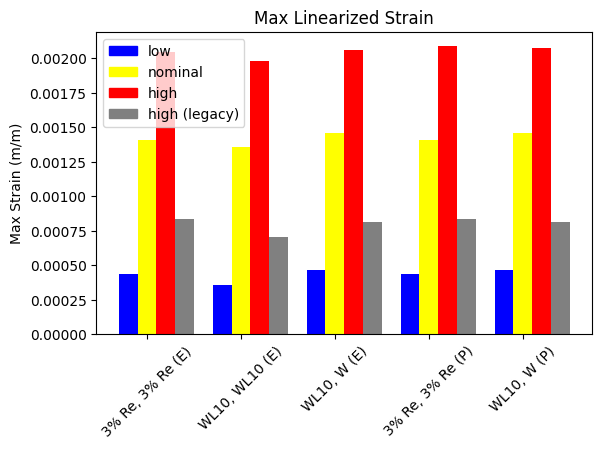

In [23]:
plot_bar_graph(strain_membrane, "Max Membrane Strain", stress=False)
plot_bar_graph(strain_bending, "Max Bending Strain", stress=False)
plot_bar_graph(strain_linearized, "Max Linearized Strain", stress=False)

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, elastic
Result:  SampleMaterial.W_3RHENIUM SampleMaterial.W_3RHENIUM False low
Result:  SampleMaterial.W_3RHENIUM SampleMaterial.W_3RHENIUM False nominal
Result:  SampleMaterial.W_3RHENIUM SampleMaterial.W_3RHENIUM False high2
Result:  SampleMaterial.W_3RHENIUM SampleMaterial.W_3RHENIUM False high
low: 1088.25533749824 MPa
nominal: 1299.0463682689501 MPa
high2: 1128.681767271242 MPa
high: 1360.1511308506185 MPa

Conductivity: wl10_roedig, Structural: wl10_roedig, elastic
Result:  SampleMaterial.WL10 SampleMaterial.WL10 False low
Result:  SampleMaterial.WL10 SampleMaterial.WL10 False nominal
Result:  SampleMaterial.WL10 SampleMaterial.WL10 False high2
Result:  SampleMaterial.WL10 SampleMaterial.WL10 False high
low: 1636.10419443889 MPa
nominal: 1835.8191923691857 MPa
high2: 1670.753410885445 MPa
high: 2604.4287539709767 MPa

Conductivity: wl10_roedig, Structural: pure_w, elastic
Result:  SampleMaterial.WL10 SampleMaterial.PURE_W 

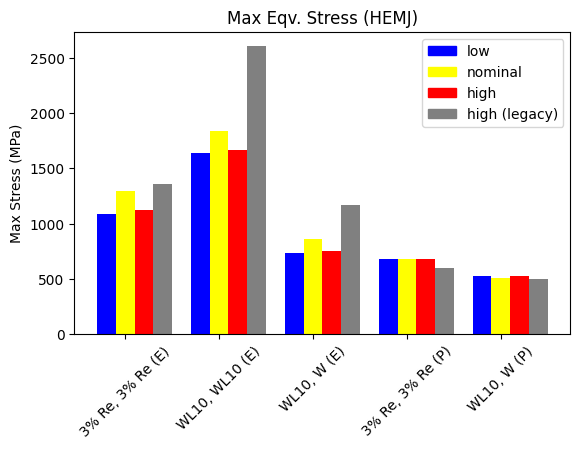

In [19]:
plot_eqv_stresses("Max Eqv. Stress (HEMJ)")